# Projeto MTR

0. Pegar o dataset de heart disease (e possivelmente de airbnb)
1. Manipular os dados para deixá-los prontos para treinamento por modelos de ML 
2. Pesquisar e escolher os modelos para serem testados (de preferência modelos que sabemos ter erros correlacionados)
3. Treinar modelos (tentar achar os melhores hiperparâmetros, usar validação cruzada de 5 ou 10 folds)
4. Construir assessores (treinados para tentar prever o erro dos modelos) (também tentar achar melhores hiperparâmetros):

    4.1. Um assessor para cada modelo (RandomForestRegressor ou algum outro)
    
    4.2. Um assessor multi-target para todos os modelos (RegressorChains (outputs relacionados) **e** Single Target Method (outputs independentes))
    
    4.3. Um assessor para cada "família" ou grupo de modelos de ML com erros correlacionados (RegressorChains)

5. Coletar resultados e tirar conclusões para apresentar

## Imports e funções

In [1]:
from utils import *
from MSVR import MSVR
from experiment_setup import ExpSetup, GroupedAssessor

/home/pbsl/pog/proj-mtr/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [2]:
DIR = 'churn'

seed = 2133330296#randint(0, 4294967295)
print(seed)

2133330296


In [3]:
setup = ExpSetup(DIR, seed, 0)

Xa_train, Xa_train_norm, Xa_test, Xa_test_norm, ya_train, ya_test, pred_corrls, pred_corrls2, performs = setup.assessorData()

/home/pbsl/pog/proj-mtr/experiment_setup.py:189: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(rdict)
/home/pbsl/pog/proj-mtr/experiment_setup.py:198: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.75       0.76388889 0.875      ... 0.90277778 0.23611111 0.04166667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.Xb_train_norm.loc[:,continuous_cols] = scaler1.fit_transform(self.Xb_train_norm.loc[:,continuous_cols], self.yb_train)
/home/pbsl/pog/proj-mtr/experiment_setup.py:202: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.31944444 0.06944444 0.23611

Nº de instâncias: 7043
[REGISTERED: DTREE]
[Training]

Accuracy:         0.9992
Recall:           0.9994
Precision:        0.9989
F1:               0.9992
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0008
1-maxProb dp:     0.0168

[Testing]

Accuracy:         0.7391
Recall:           0.5398
Precision:        0.4798
F1:               0.5080
AUROC:            0.6733
AUPR:             0.3745
1-maxProb média:  0.0007
1-maxProb dp:     0.0167

[REGISTERED: SGD]
[Training]

Accuracy:         0.7716
Recall:           0.8012
Precision:        0.7564
F1:               0.7782
AUROC:            0.8484
AUPR:             0.8241
1-maxProb média:  0.2514
1-maxProb dp:     0.1315

[Testing]

Accuracy:         0.7489
Recall:           0.7919
Precision:        0.4980
F1:               0.6114
AUROC:            0.8388
AUPR:             0.6145
1-maxProb média:  0.2403
1-maxProb dp:     0.1405

[REGISTERED: LR]
[Training]

Accuracy:         0.7792
Recall:           0.8193
Precision:

In [4]:
ya_train_copy = ya_train.copy()
ya_test_copy = ya_test.copy()
pred_corrls_copy = pred_corrls.copy()
pred_corrls2_copy = pred_corrls2.copy()

# Assessors

#### Análise de correlações

Conjunto de Treinamento:

O conjunto de teste dos modelos base já é o conjunto de treinamento dos assessores.

In [5]:
groups = {}
model_names = ['lr', 'kan', 'sgd', 'svm_linear'] # ['dtree', 'xgb', 'knn'] #list(performs.keys())

ya_train = ya_train_copy[model_names]
ya_test = ya_test_copy[model_names]
pred_corrls = pred_corrls_copy.loc[model_names, model_names]
pred_corrls2 = pred_corrls2_copy.loc[model_names, model_names]

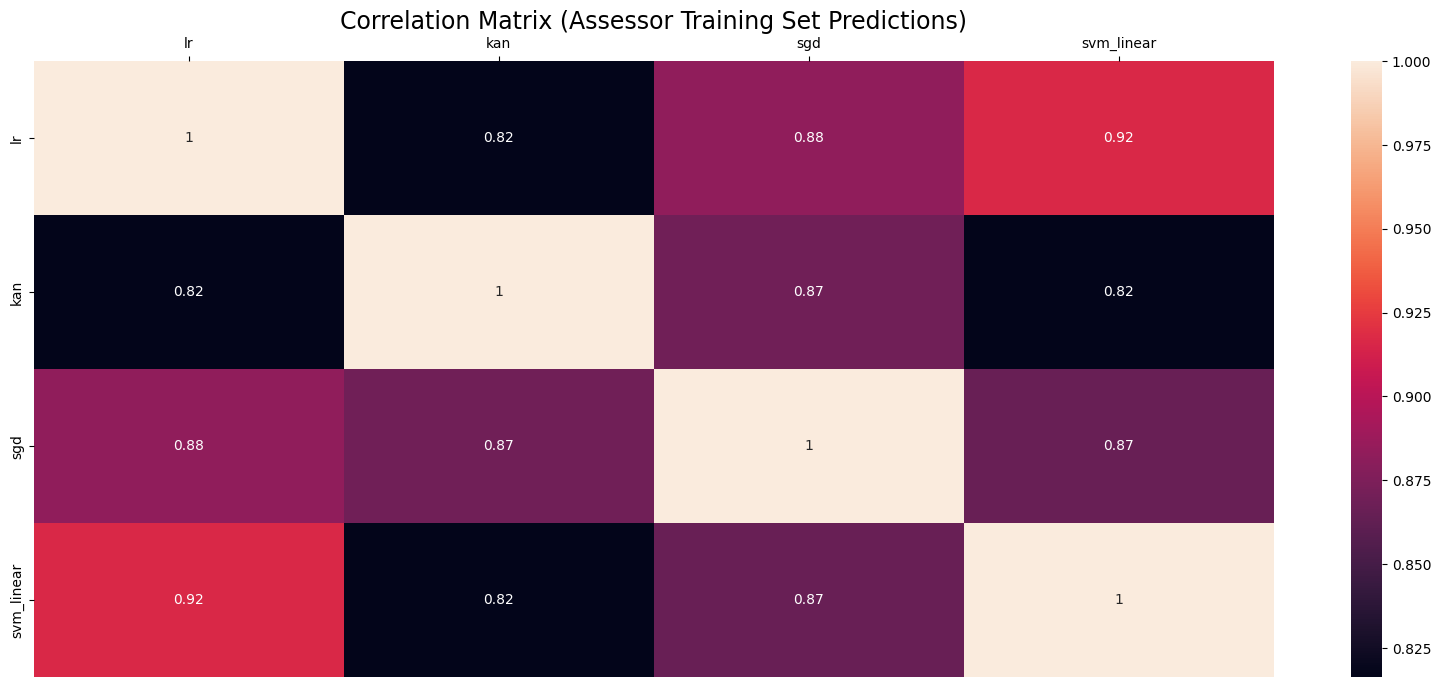

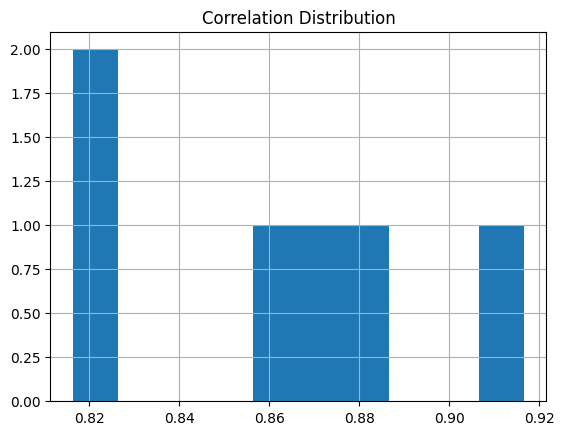

Training correlation distribution:
count    6.000000
mean     0.861177
std      0.039001
min      0.816338
25%      0.828882
50%      0.867475
75%      0.879248
max      0.916581
Name: corr, dtype: float64
[Saved image "cm_atrain.eps"]
[Saved image "cd_atrain.eps"]


In [6]:
correlation_matrix(pred_corrls, True, DIR, 'Assessor', 'Training')

In [7]:
MIN_SCORE = 0.85 #corrls_values['corr'].quantile(0.75)

print('Min_score:', MIN_SCORE)

groups['true_assessor_train'] = group_search(pred_corrls, MIN_SCORE)
groups['true_assessor_train']

Min_score: 0.85


[['lr', 'sgd', 'svm_linear'], ['sgd', 'kan']]

        Min_score: 0.65
        [['svm_rbf', 'svm_poly'],
        ['xgb', 'rforest', 'gb'],
        ['lr', 'kan', 'sgd', 'svm_linear', 'adab'],
        ['knn'],
        ['dtree'],
        ['mlp']] 

Conjunto de Teste:

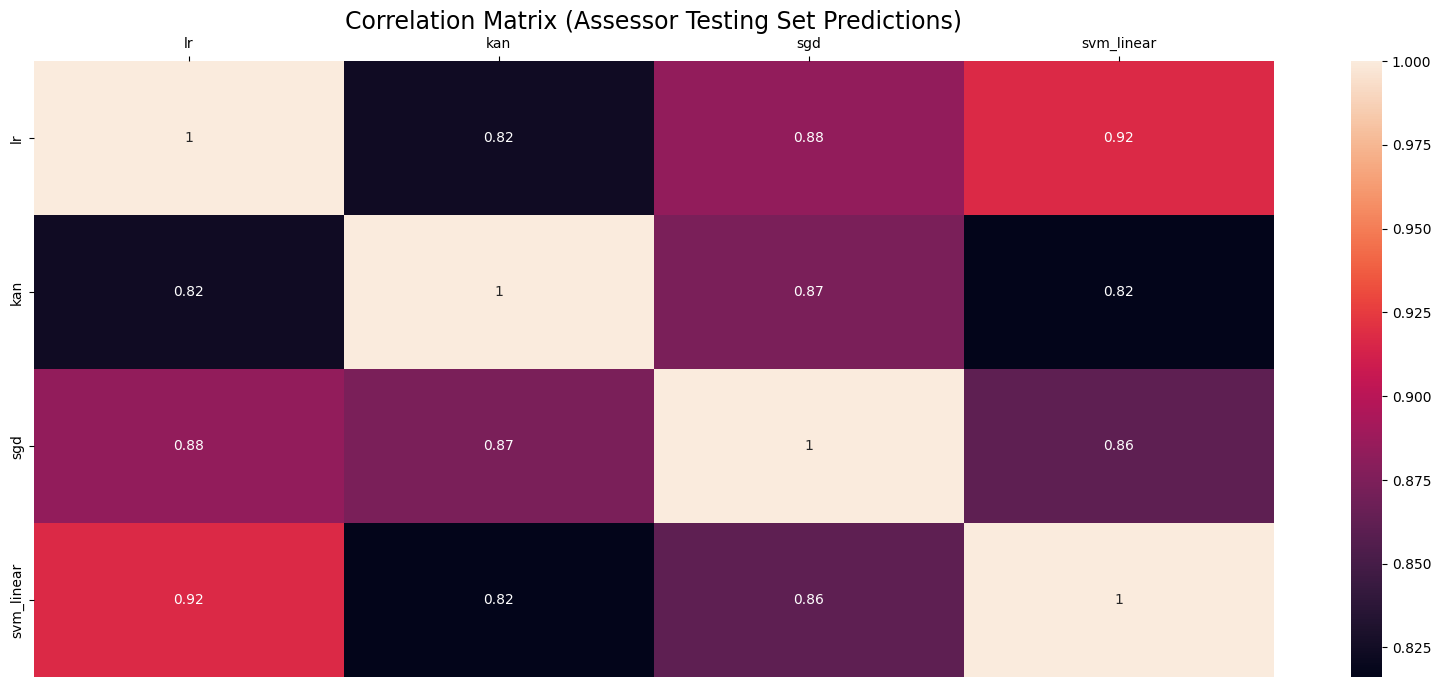

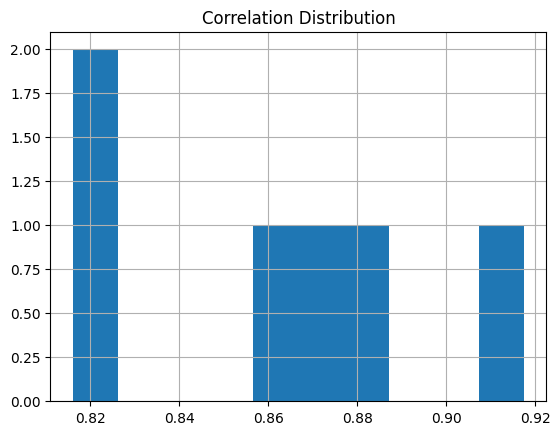

Testing correlation distribution:
count    6.000000
mean     0.862399
std      0.037956
min      0.816173
25%      0.833031
50%      0.866988
75%      0.880591
max      0.917409
Name: corr, dtype: float64
[Saved image "cm_atest.eps"]
[Saved image "cd_atest.eps"]


In [8]:
correlation_matrix(pred_corrls2, True, DIR, 'Assessor', 'Testing')

In [9]:
groups['true_assessor_test'] = group_search(pred_corrls2, MIN_SCORE)
groups['true_assessor_test']

[['lr', 'sgd', 'svm_linear'], ['sgd', 'kan']]

Diferença entre correlações do conjnuto de teste e de treinamento:
MSE:  0.0000
NMSE: 0.0024
MAE:  0.0021
NMAE: 0.0381
aRRMSE: 0.0486
aCC:  0.9993


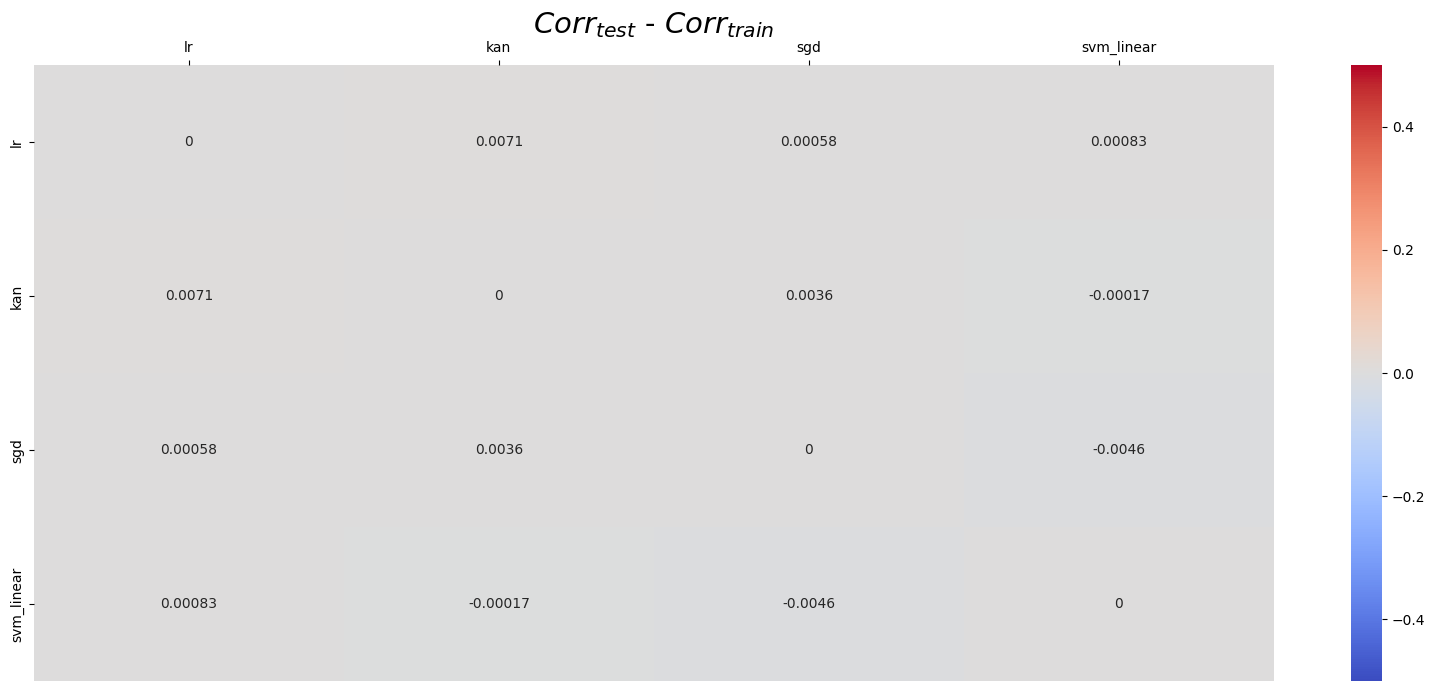

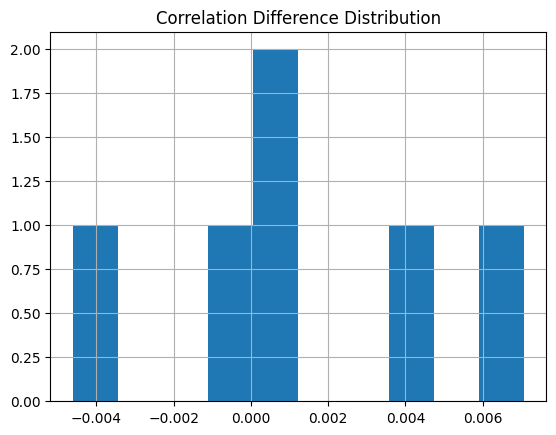

[Saved image "cmd_base.eps"]
[Saved image "cdd_base.eps"]


In [10]:
diff_corrls = pred_corrls2-pred_corrls
diff_corrls_values = corrlArray(diff_corrls)['corr']

print(f'''Diferença entre correlações do conjnuto de teste e de treinamento:
MSE:  {mse(pred_corrls, pred_corrls2):.4f}
NMSE: {nmse(pred_corrls, pred_corrls2):.4f}
MAE:  {mae(pred_corrls, pred_corrls2):.4f}
NMAE: {nmae(pred_corrls, pred_corrls2):.4f}
aRRMSE: {rrmse(pred_corrls, pred_corrls2):.4f}
aCC:  {corrCoeff(pred_corrls, pred_corrls2):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{test}$ - $Corr_{train}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

## Globais

In [11]:
parameters = {'max_depth':[None,10,20,30],
                    'criterion':['squared_error', 'poisson', 'friedman_mse'],
                    'min_samples_split':[2,5,10,20,40,60],
                    'min_samples_leaf':[1,2,10,30],
                    'n_estimators':[20,50,100,150]}

In [12]:
# Criando o MultiIndex
multi_index = multIdx('ST','MRT','MRT(g)','M-SVR','M-SVR(g)','RC','RC(g)', subindex=model_names)

metrics_cols = ['MSE', 'MAE', 'NMSE', 'NMAE', 'aRRMSE', 'aCC']
metrics_df = pd.DataFrame(columns=metrics_cols, index=multi_index)
diff_metrics = pd.DataFrame(columns=metrics_cols, index=['ST','MRT','MRT(g)','M-SVR','M-SVR(g)','RC','RC(g)'])

### Regressor Chain
(RC)

In [16]:
#study = OptunaStudy(Xa_train, ya_train, 30, seed)
#
#study.search(RegressorChain, cv=5)
#
#rc_params = study.best_params
#regchain = RegressorChain(RandomForestRegressor(random_state=seed).set_params(**rc_params),
#                          random_state=seed, cv=5, verbose=True).fit(Xa_train, ya_train)

In [13]:
regchain = RegressorChain(RandomForestRegressor(random_state=seed), random_state=seed, cv=5,
                          verbose=True, order='random').fit(Xa_train, ya_train)

[Chain] ................... (1 of 4) Processing order 3, total=   0.7s
[Chain] ................... (2 of 4) Processing order 0, total=   0.9s
[Chain] ................... (3 of 4) Processing order 2, total=   1.0s
[Chain] ................... (4 of 4) Processing order 1, total=   1.1s


In [14]:
metrics_df.loc['RC',:] = assr_performance(regchain, Xa_test, ya_test, Xa_train, ya_train)

metrics_df.loc['RC',:]

[TRAINING SET]
MSE: 0.0218
NMSE: 0.3473
MAE: 0.0859
NMAE: 0.4036
aRRMSE: 0.5640
aCC: 0.8070

[TESTING SET]
MSE: 0.0372
NMSE: 0.5812
MAE: 0.1259
NMAE: 0.5828
aRRMSE: 0.7623
aCC: 0.6526


MSE       MAE      NMSE      NMAE    aRRMSE       aCC
Model                                                                 
lr           0.04037  0.593845  0.133409  0.595198  0.770614  0.642325
kan         0.037354  0.594877  0.124027  0.588345  0.771283  0.642235
sgd         0.032487  0.558943  0.117195  0.566741  0.747625  0.667538
svm_linear  0.038629  0.576969  0.129084  0.580864  0.759585  0.658335

#### Análise das correlações

Melhorar esse cálculo de correlação para fazer melhor uso do 1-(probabilidade da classe correta)

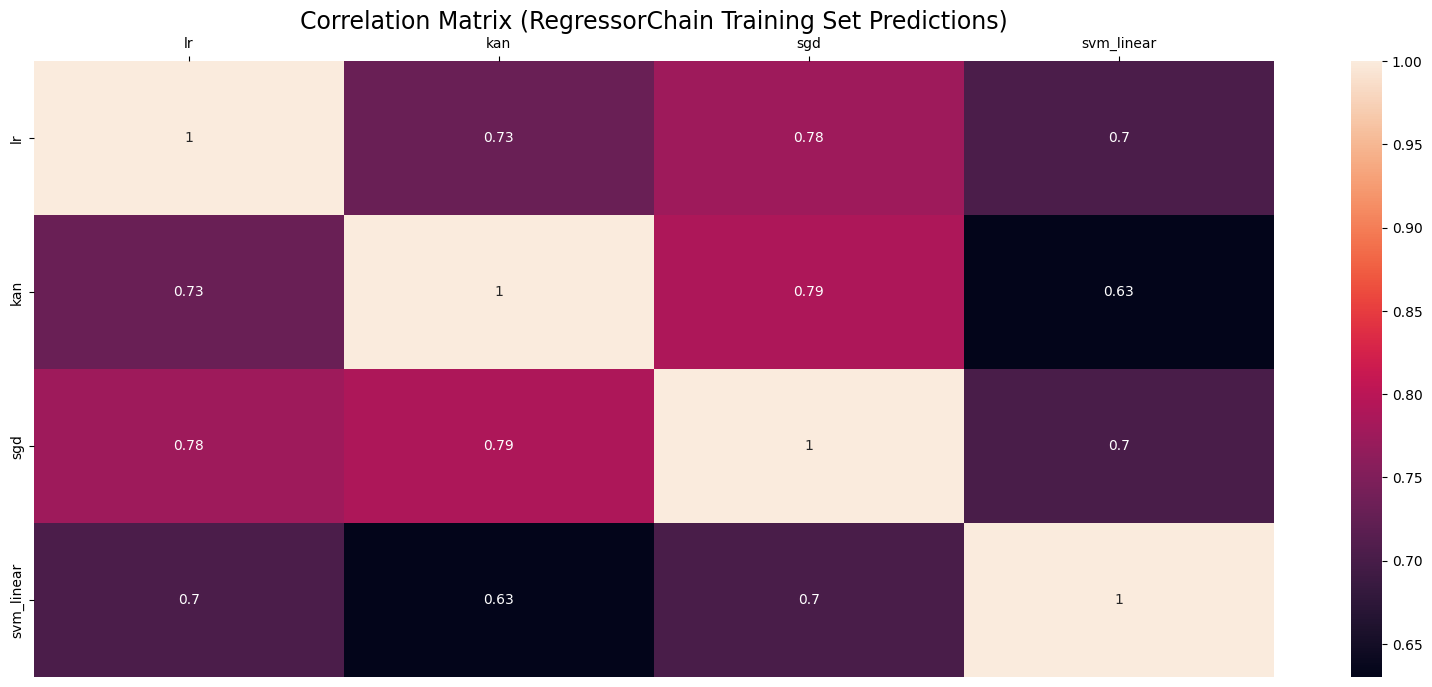

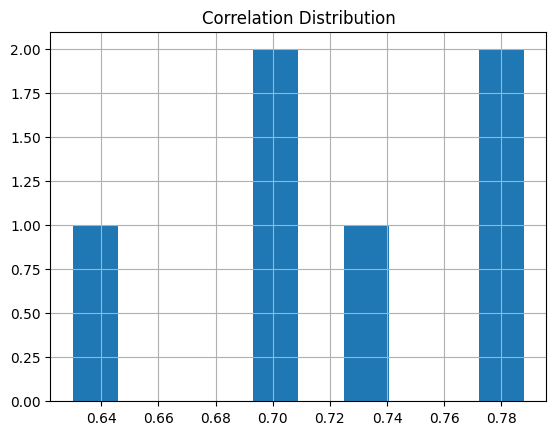

Training correlation distribution:
count    6.000000
mean     0.721428
std      0.057479
min      0.630155
25%      0.701903
50%      0.716582
75%      0.764418
max      0.787877
Name: corr, dtype: float64


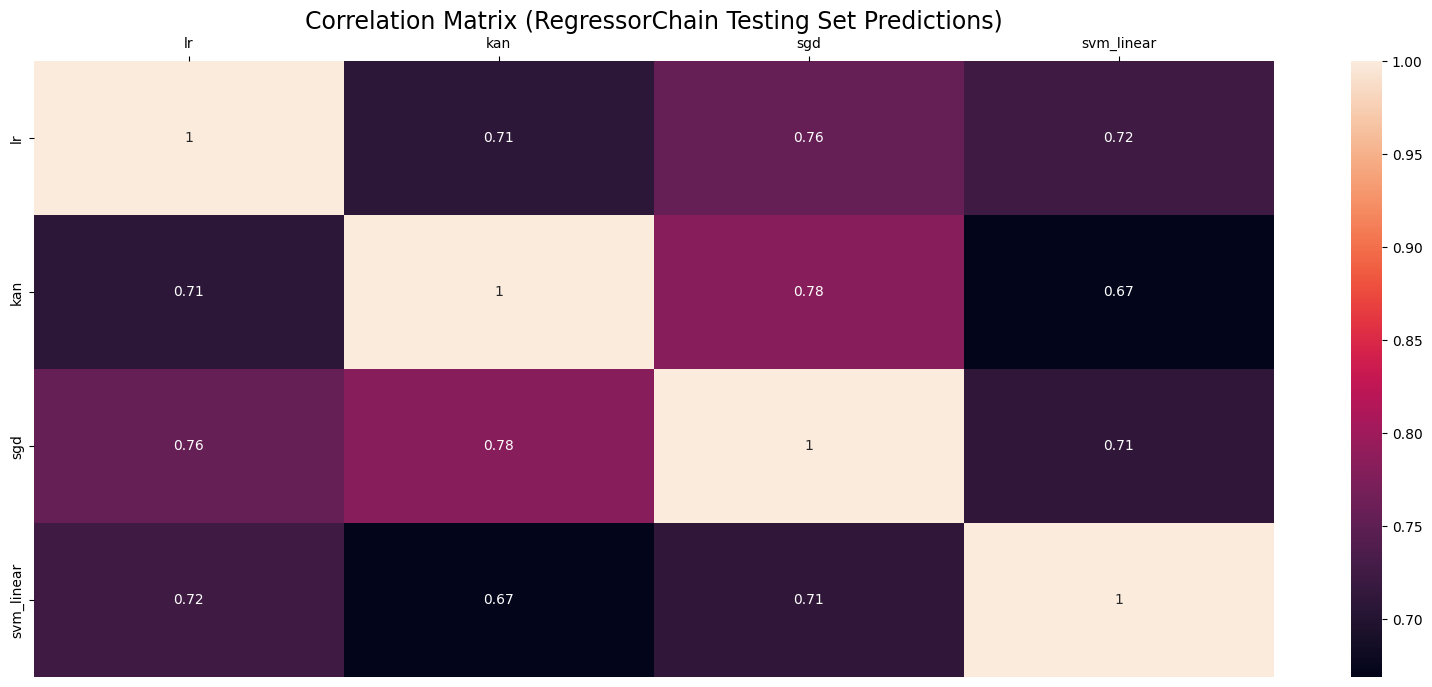

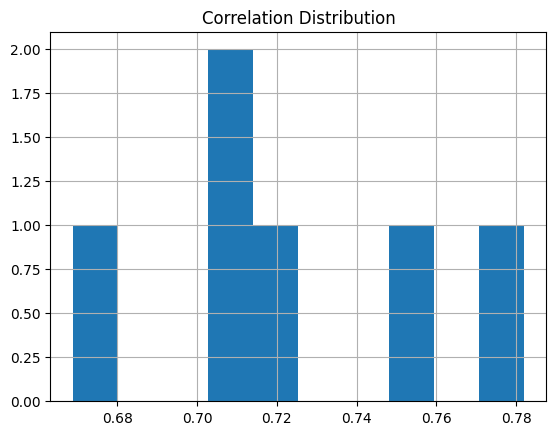

Testing correlation distribution:
count    6.000000
mean     0.725147
std      0.039599
min      0.668880
25%      0.709409
50%      0.717374
75%      0.748260
max      0.781947
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0149
NMSE: 0.1029
MAE: 3.5472
NMAE: 1.8701
aRRMSE: 1.8644
aCC: 0.9439


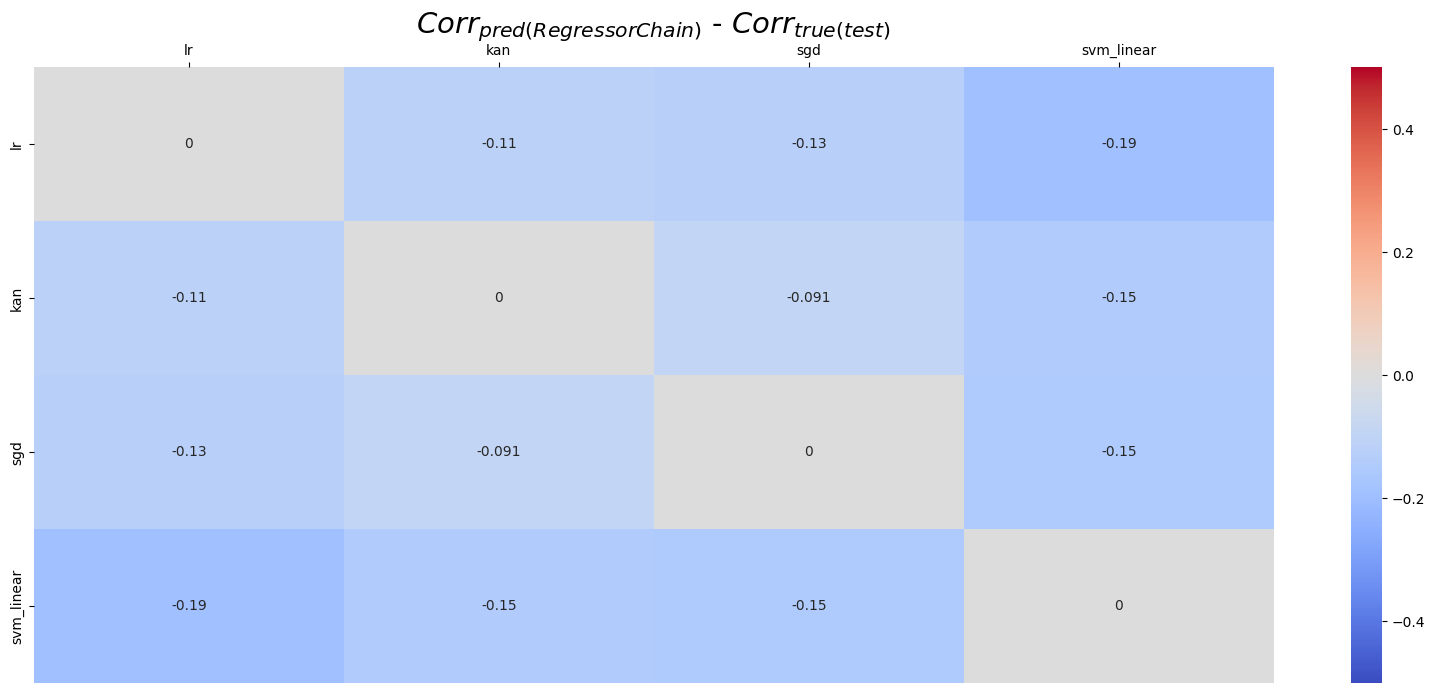

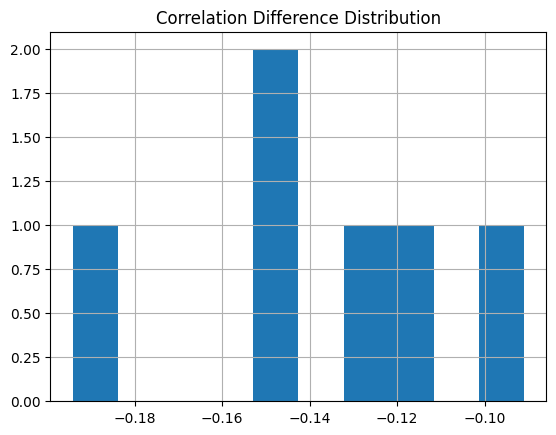

In [15]:
#regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
#                               index=Xa_train.index,
#                               columns=model_names).corr('kendall') 

results = correlation_pred_performance(regchain, Xa_test, ya_test, Xa_train, 
                                       min_score=MIN_SCORE, name="RegressorChain",
                                       show_plot=True, save_plot=None)

In [16]:
diff_metrics.loc['RC',:] = results['results']
diff_metrics.loc['RC',:]

MSE       0.014907
MAE       0.102939
NMSE      3.547209
NMAE      1.870117
aRRMSE    1.864438
aCC       0.943891
Name: RC, dtype: object

In [17]:
groups['regchain_assessor'] = results['groups']
groups['regchain_assessor']['test']

[['lr'], ['sgd'], ['svm_linear'], ['kan']]

In [17]:
regchain=None

### Ensemble of Regressor Chains

In [41]:
num_chains = 50
rc_ac = f'RC[{num_chains}]'

rc_ests = [RegressorChain(base_estimator=RandomForestRegressor(random_state=seed),
                          random_state=seed+i,
                          order='random', cv=5) for i in range(num_chains)]

rc_plus = GroupedAssessor(rc_ests).fit(Xa_train, ya_train)

: 

In [ ]:
# keeping the concat because multiple numbers of chains could be recorded
if(rc_ac in metrics_df.index):
    metrics_df.loc[rc_ac,:] = assr_performance(rc_plus, Xa_test, ya_test, Xa_train, ya_train)
else:
    new_df = pd.DataFrame(assr_performance(rc_plus, Xa_test, ya_test, Xa_train, ya_train), 
                          columns=metrics_cols,
                          index=multIdx(rc_ac, subindex=model_names))

    metrics_df = pd.concat([metrics_df, new_df])
metrics_df.loc[rc_ac,:]

[TRAINING SET]
MSE: 0.0184
NMSE: 0.2906
MAE: 0.0841
NMAE: 0.3931
aRRMSE: 0.5374
aCC: 0.8541

[TESTING SET]
MSE: 0.0353
NMSE: 0.5510
MAE: 0.1245
NMAE: 0.5763
aRRMSE: 0.7423
aCC: 0.6715


MSE       MAE      NMSE      NMAE    aRRMSE       aCC
Model                                                                 
lr          0.038647  0.568504  0.132285  0.590184  0.753992   0.65821
kan         0.035095  0.558896  0.121135  0.574625  0.747594  0.666297
sgd         0.030944  0.532388  0.115526  0.558672   0.72965  0.684631
svm_linear  0.036444  0.544324  0.129244   0.58158  0.737783  0.676692

#### Análise das correlações

Melhorar esse cálculo de correlação para fazer melhor uso do 1-(probabilidade da classe correta)

In [ ]:
#regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
#                               index=Xa_train.index,
#                               columns=model_names).corr('kendall') 
#50chains
results = correlation_pred_performance(rc_plus, Xa_test, ya_test, Xa_train, 
                                       min_score=MIN_SCORE, name=f"RegressorChain({num_chains})",
                                       show_plot=True, save_plot=None)

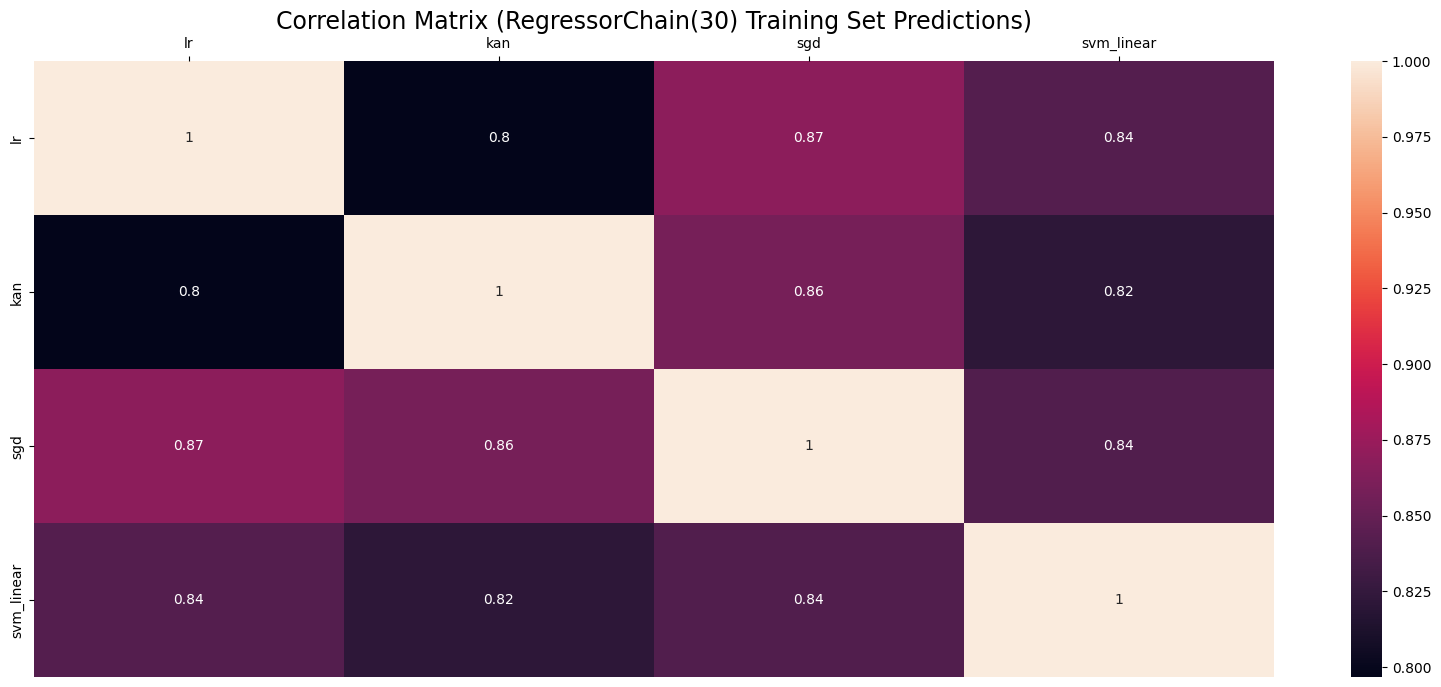

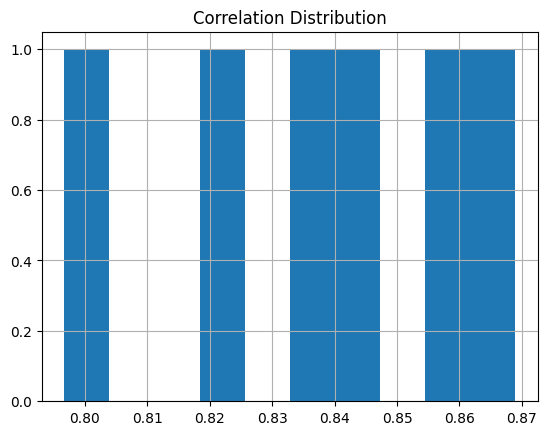

Training correlation distribution:
count    6.000000
mean     0.837786
std      0.025974
min      0.796713
25%      0.825868
50%      0.840758
75%      0.854186
max      0.868923
Name: corr, dtype: float64


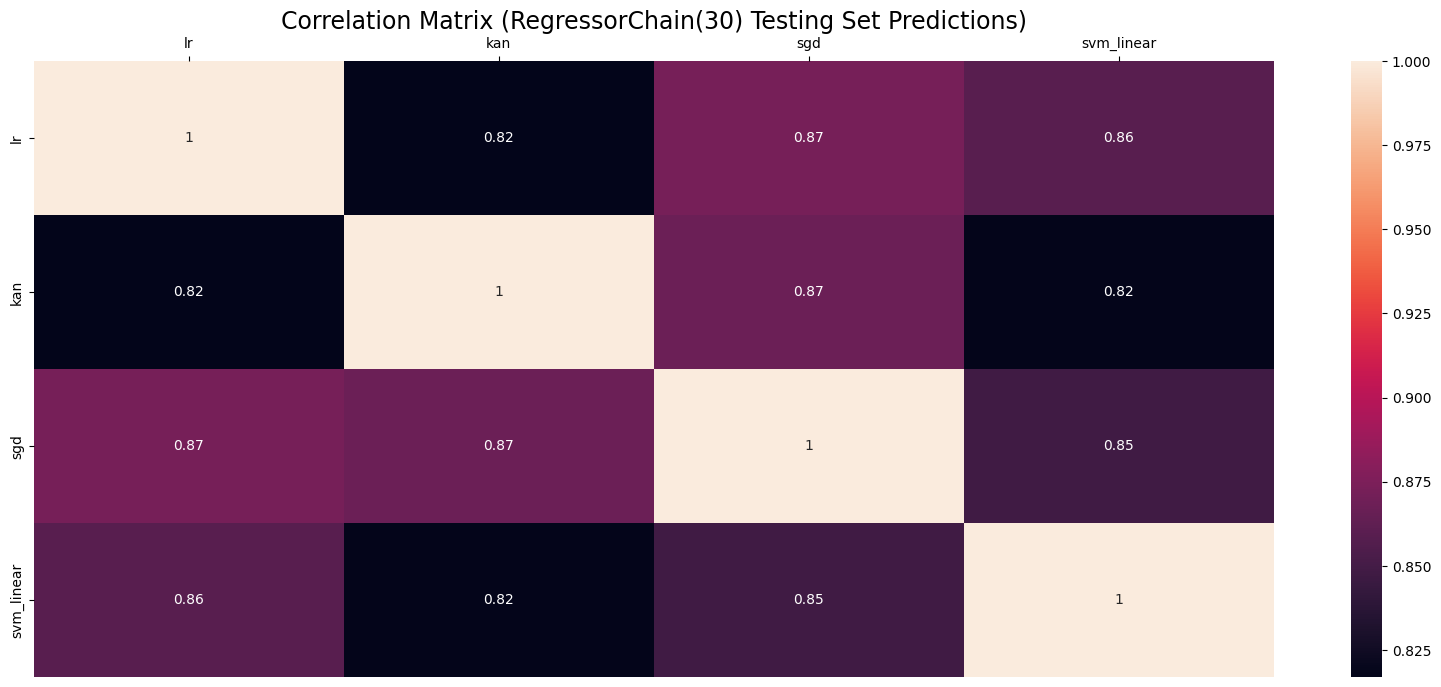

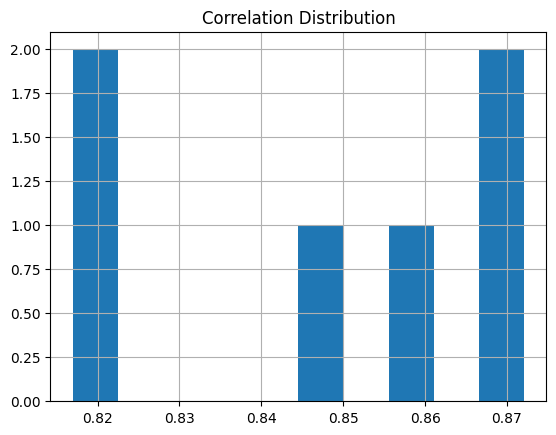

Testing correlation distribution:
count    6.000000
mean     0.847056
std      0.024177
min      0.816999
25%      0.825813
50%      0.853681
75%      0.865455
max      0.872073
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0005
NMSE: 0.0120
MAE: 0.1095
NMAE: 0.2192
aRRMSE: 0.2806
aCC: 0.9694


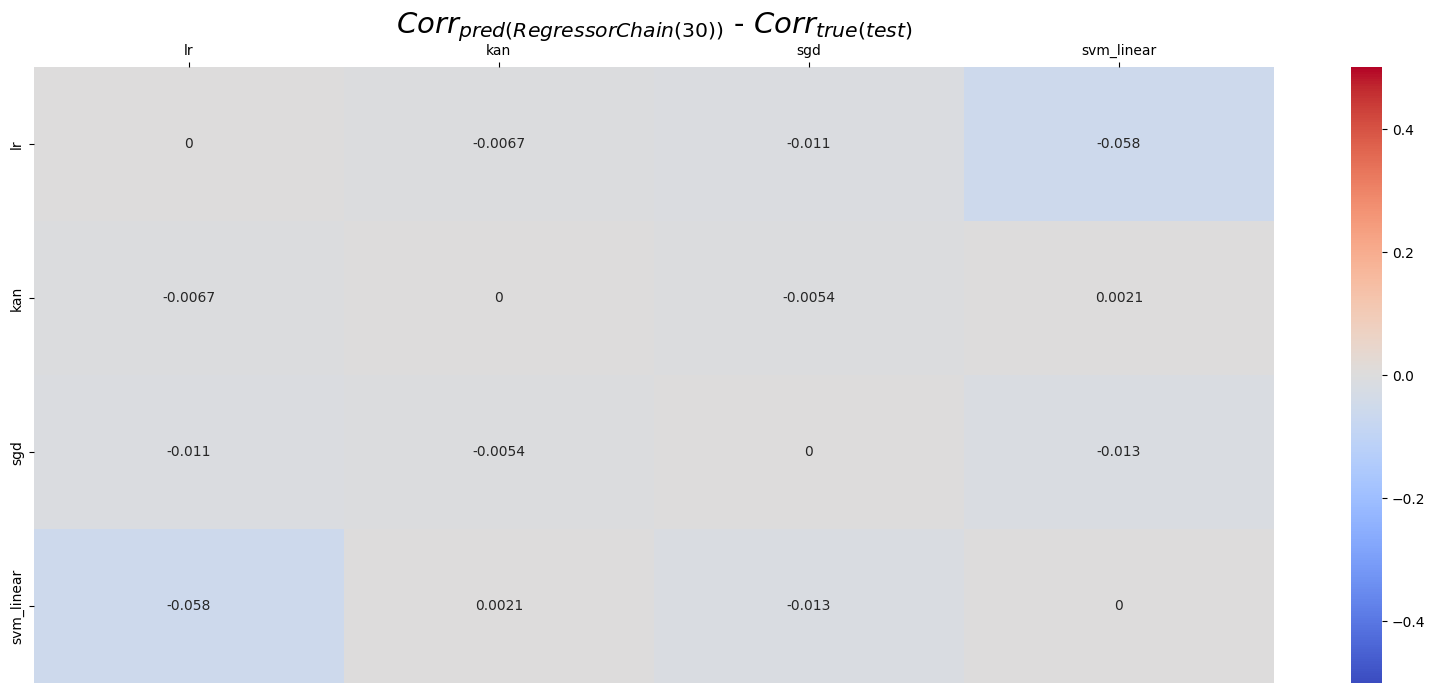

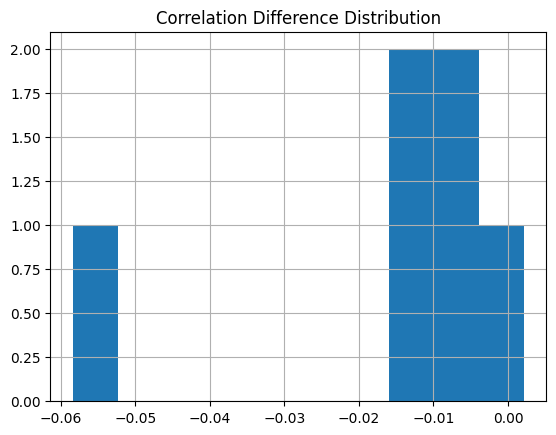

In [36]:
#regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
#                               index=Xa_train.index,
#                               columns=model_names).corr('kendall') 
#30chains
results = correlation_pred_performance(rc_plus, Xa_test, ya_test, Xa_train, 
                                       min_score=MIN_SCORE, name=f"RegressorChain({num_chains})",
                                       show_plot=True, save_plot=None)

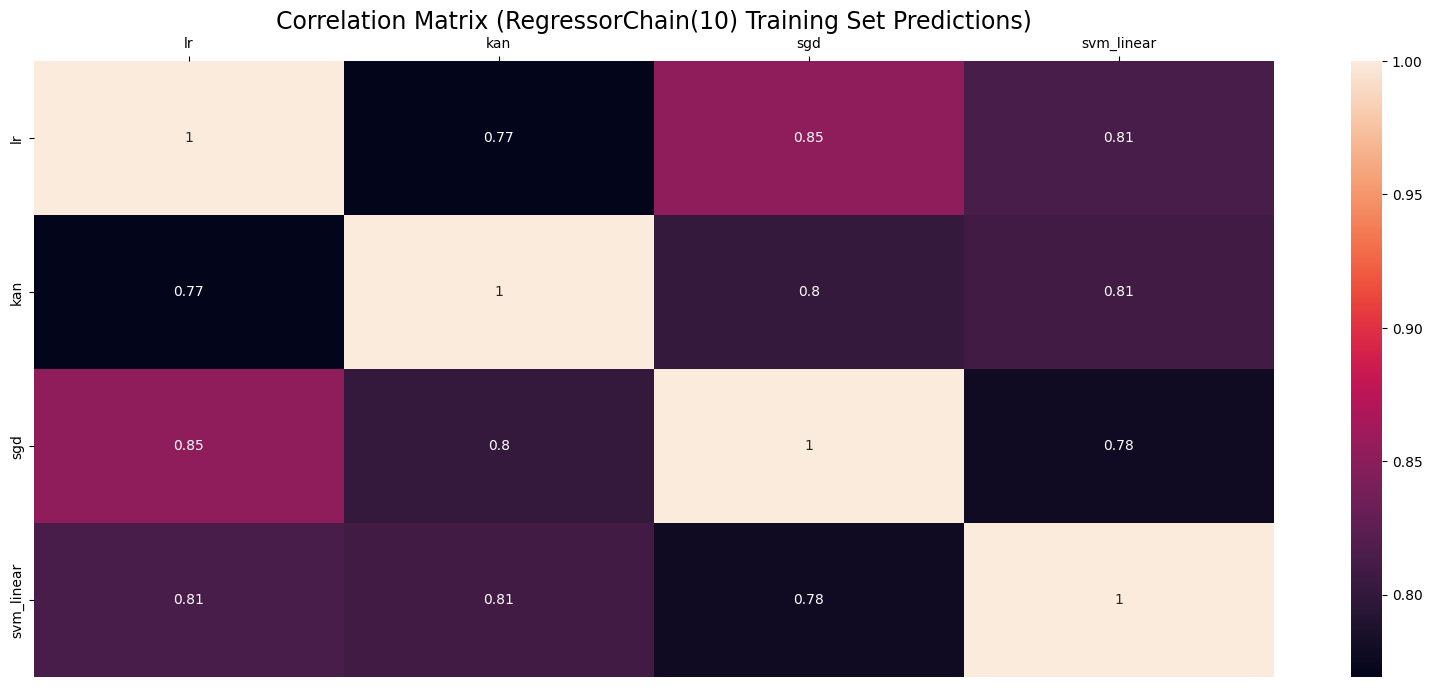

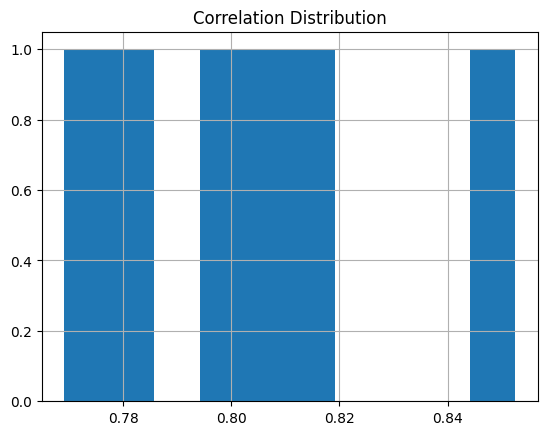

Training correlation distribution:
count    6.000000
mean     0.803913
std      0.029448
min      0.769146
25%      0.784123
50%      0.805000
75%      0.812279
max      0.852465
Name: corr, dtype: float64


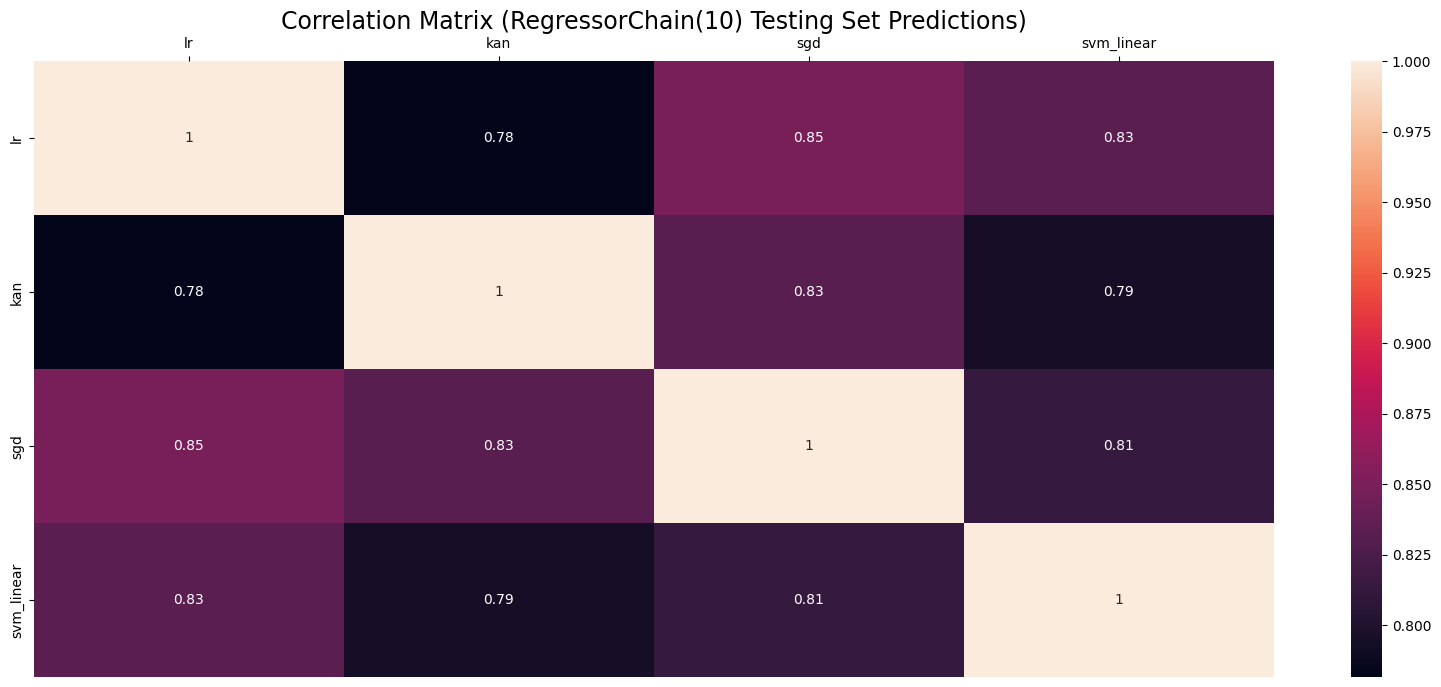

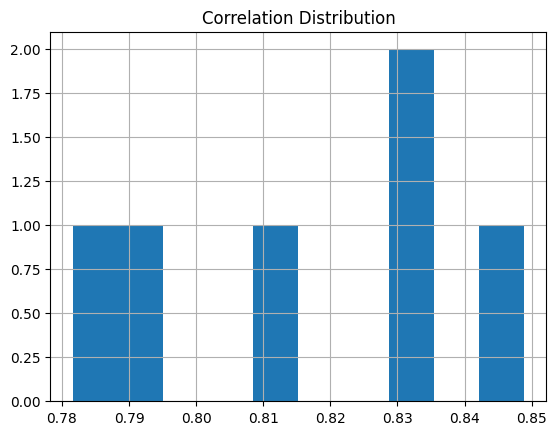

Testing correlation distribution:
count    6.000000
mean     0.817076
std      0.025650
min      0.781645
25%      0.798822
50%      0.822098
75%      0.833044
max      0.848857
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0018
NMSE: 0.0340
MAE: 0.4350
NMAE: 0.6209
aRRMSE: 0.6456
aCC: 0.9659


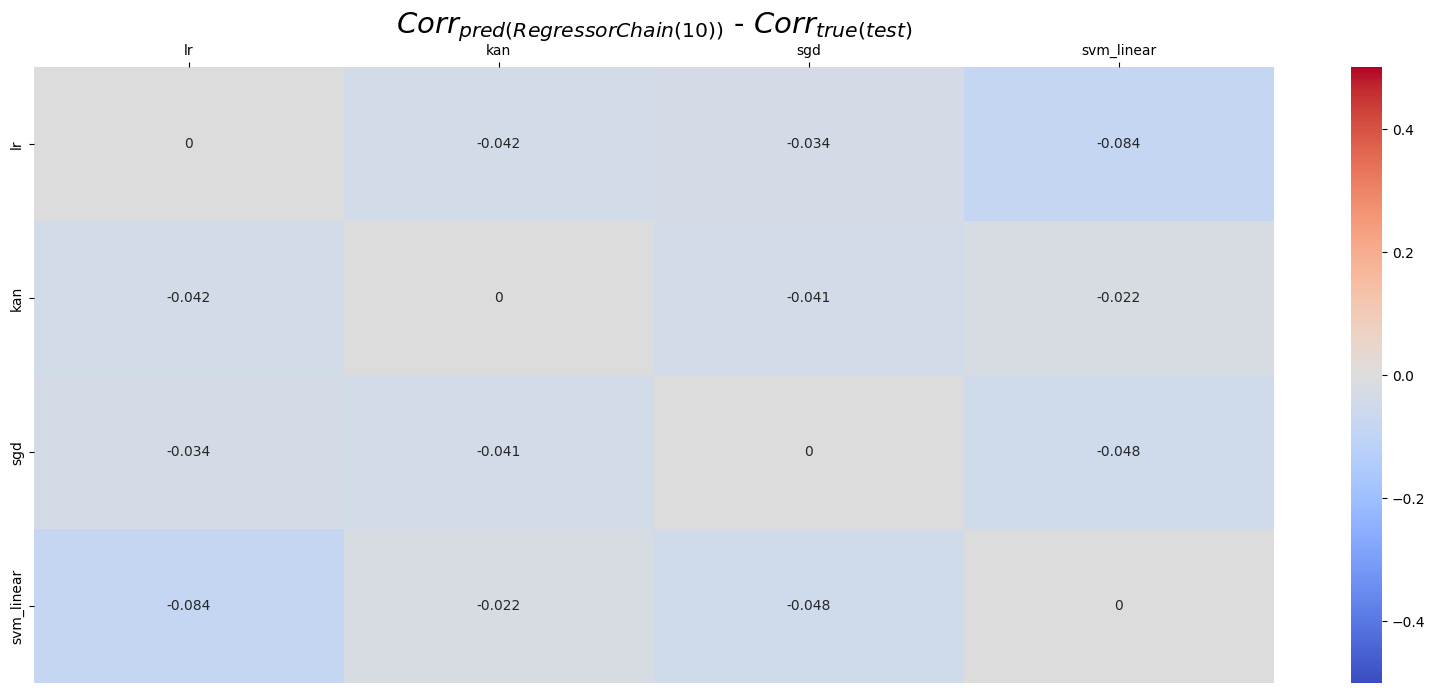

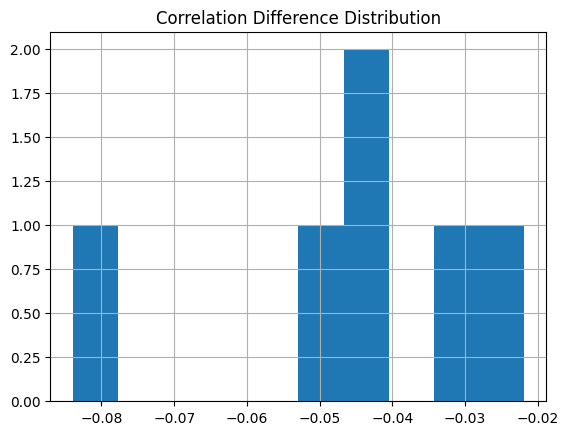

In [20]:
#regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
#                               index=Xa_train.index,
#                               columns=model_names).corr('kendall') 
#10chains
results = correlation_pred_performance(rc_plus, Xa_test, ya_test, Xa_train, 
                                       min_score=MIN_SCORE, name=f"RegressorChain({num_chains})",
                                       show_plot=True, save_plot=None)

In [ ]:
diff_metrics.loc[rc_ac,:] = results['results']
diff_metrics.loc[rc_ac,:]

MSE       0.000471
MAE       0.012041
NMSE      0.109491
NMAE      0.219158
aRRMSE    0.280645
aCC       0.969389
Name: RC[30], dtype: object

In [ ]:
groups[f'regchain{num_chains}_assessor'] = results['groups']
groups[f'regchain{num_chains}_assessor']['test']

[['lr', 'sgd'], ['lr', 'svm_linear'], ['sgd', 'kan']]

In [ ]:
rc_plus = None

### Multi-Output Random Forest Regressor 

In [19]:
mrf = RandomForestRegressor(random_state=seed).fit(Xa_train, ya_train)

In [20]:
metrics_df.loc['MRT',:] = assr_performance(mrf, Xa_test, ya_test, Xa_train, ya_train)

[TRAINING SET]
MSE: 0.0103
NMSE: 0.0998
MAE: 0.0670
NMAE: 0.2609
aRRMSE: 0.3143
aCC: 0.9667

[TESTING SET]
MSE: 0.0775
NMSE: 0.7410
MAE: 0.1885
NMAE: 0.7196
aRRMSE: 0.8577
aCC: 0.5131


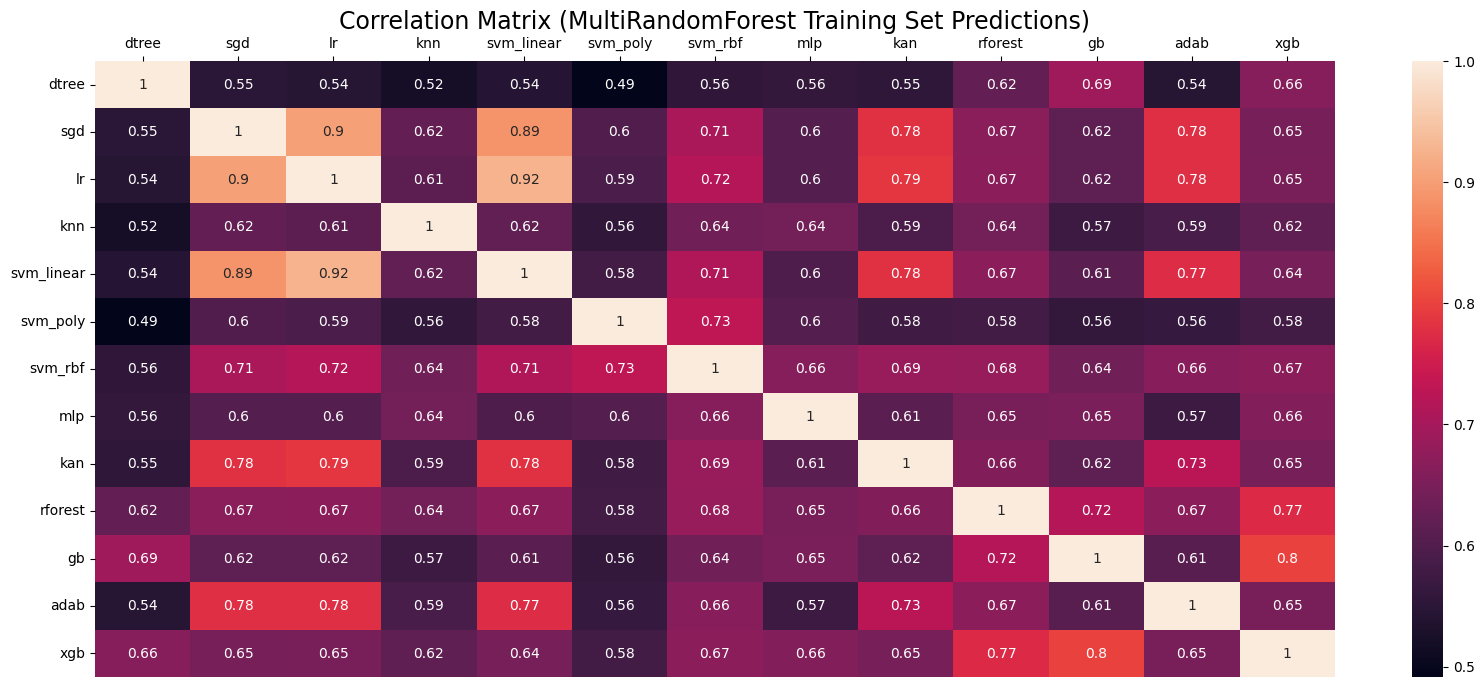

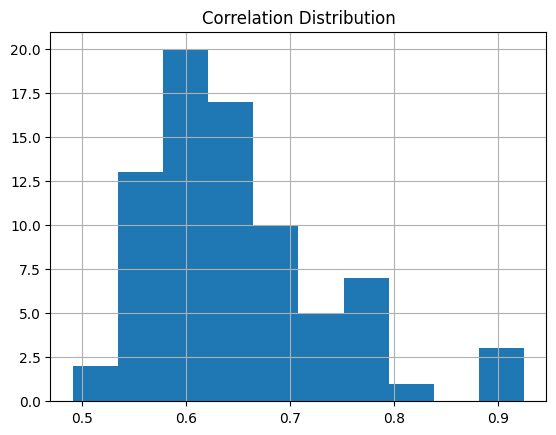

Training correlation distribution:
count    78.000000
mean      0.649394
std       0.086184
min       0.491501
25%       0.592814
50%       0.639770
75%       0.680961
max       0.924809
Name: corr, dtype: float64


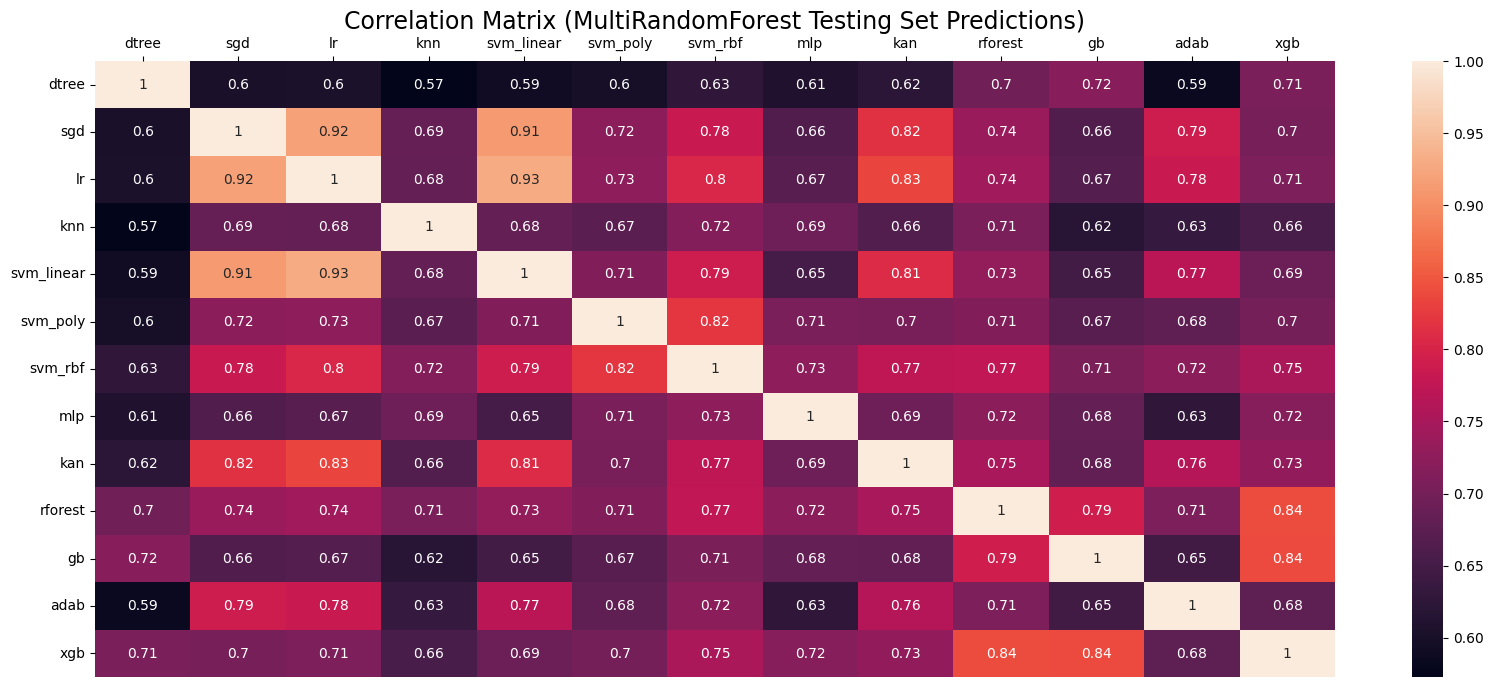

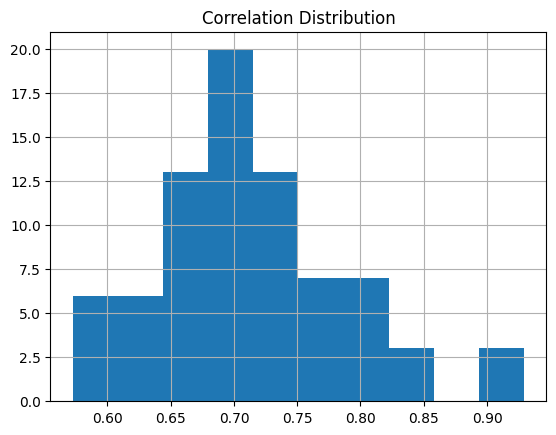

Testing correlation distribution:
count    78.000000
mean      0.713229
std       0.075439
min       0.572807
25%       0.667190
50%       0.705275
75%       0.751300
max       0.929167
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0288
NMSE: 0.1528
MAE: 1.2063
NMAE: 1.4591
aRRMSE: 1.0786
aCC: 0.9710


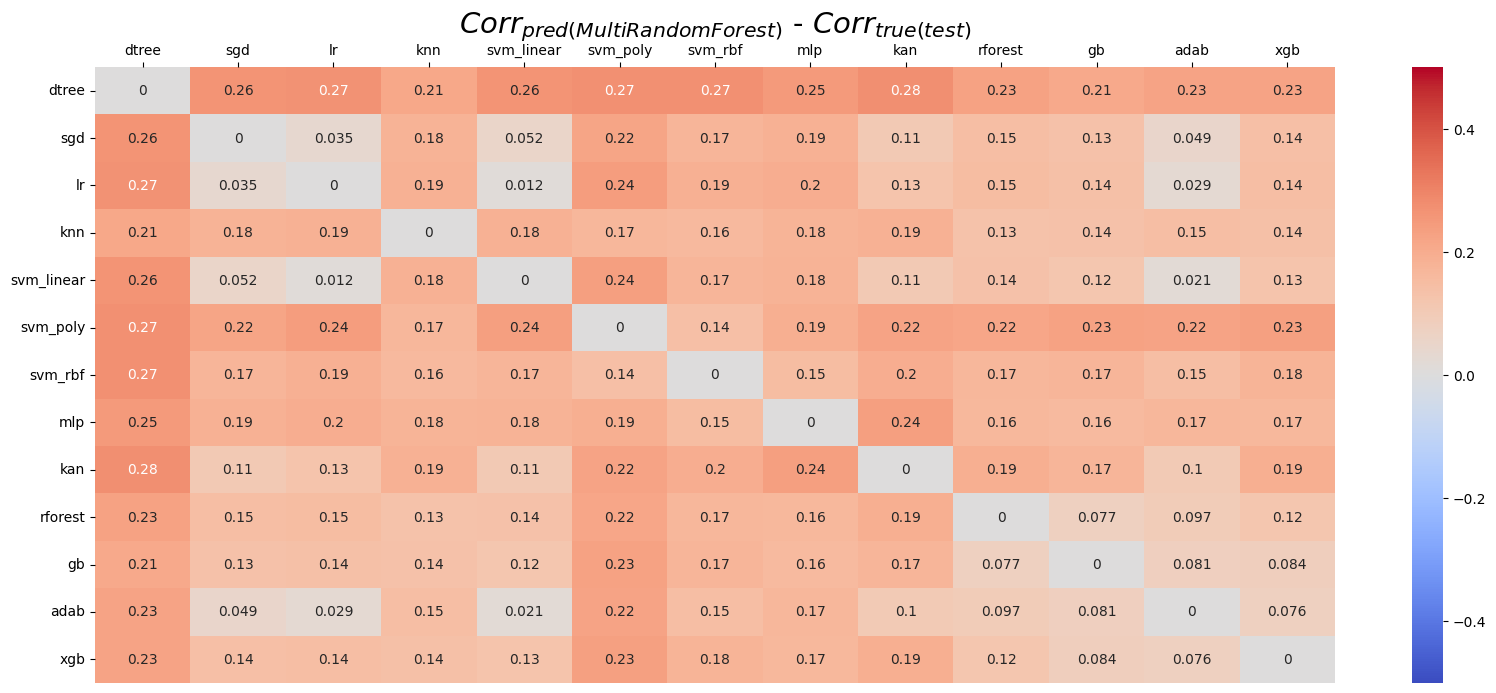

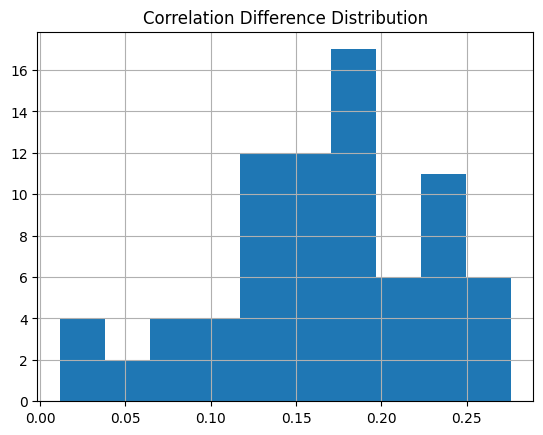

In [21]:
results = correlation_pred_performance(mrf, Xa_test, ya_test, Xa_train, 
                                       MIN_SCORE, name="MultiRandomForest")

In [22]:
diff_metrics.loc['MRT',:] = results['results']
diff_metrics.loc['MRT',:]

MSE       0.028811
MAE       0.152754
NMSE      1.206294
NMAE      1.459116
aRRMSE    1.078645
aCC       0.970998
Name: MRT, dtype: object

In [23]:
groups['mrf_assessor'] = results['groups']
groups['mrf_assessor']['test']

[['lr',
  'rforest',
  'svm_rbf',
  'svm_linear',
  'xgb',
  'kan',
  'svm_poly',
  'knn',
  'sgd'],
 ['lr',
  'rforest',
  'svm_rbf',
  'svm_linear',
  'xgb',
  'kan',
  'adab',
  'svm_poly',
  'sgd'],
 ['mlp', 'lr', 'rforest', 'svm_rbf', 'xgb', 'kan', 'svm_poly', 'gb', 'sgd'],
 ['mlp', 'lr', 'rforest', 'svm_rbf', 'xgb', 'kan', 'svm_poly', 'knn', 'sgd'],
 ['xgb', 'rforest', 'dtree', 'gb']]

### Multi-Output SVR

In [24]:
#msvr = MSVR()
#msvr.fit(np.asarray(Xa_train_norm), np.asarray(ya_train))
#msvr_params = product(svm_rbf_params)
#g_search = GridSearchCV(MSVR(), svm_rbf_params, scoring='neg_mean_squared_error', n_jobs=-1).fit(np.asarray(Xa_train_norm), np.asarray(ya_train))
#print(g_search.best_params_)
#msvr = g_search.best_estimator_

In [25]:
#study_norm = OptunaStudy(Xa_train_norm, ya_train.values, 200)
#study_norm.search(MSVR)

In [26]:
msvr = MSVR().fit(Xa_train_norm, ya_train.values)

In [27]:
metrics_df.loc['M-SVR',:] = assr_performance(msvr, Xa_test_norm, ya_test, Xa_train_norm, ya_train)

[TRAINING SET]
MSE: 0.0638
NMSE: 0.6471
MAE: 0.1816
NMAE: 0.7493
aRRMSE: 0.8012
aCC: 0.5936

[TESTING SET]
MSE: 0.0738
NMSE: 0.7293
MAE: 0.1958
NMAE: 0.7884
aRRMSE: 0.8510
aCC: 0.5121


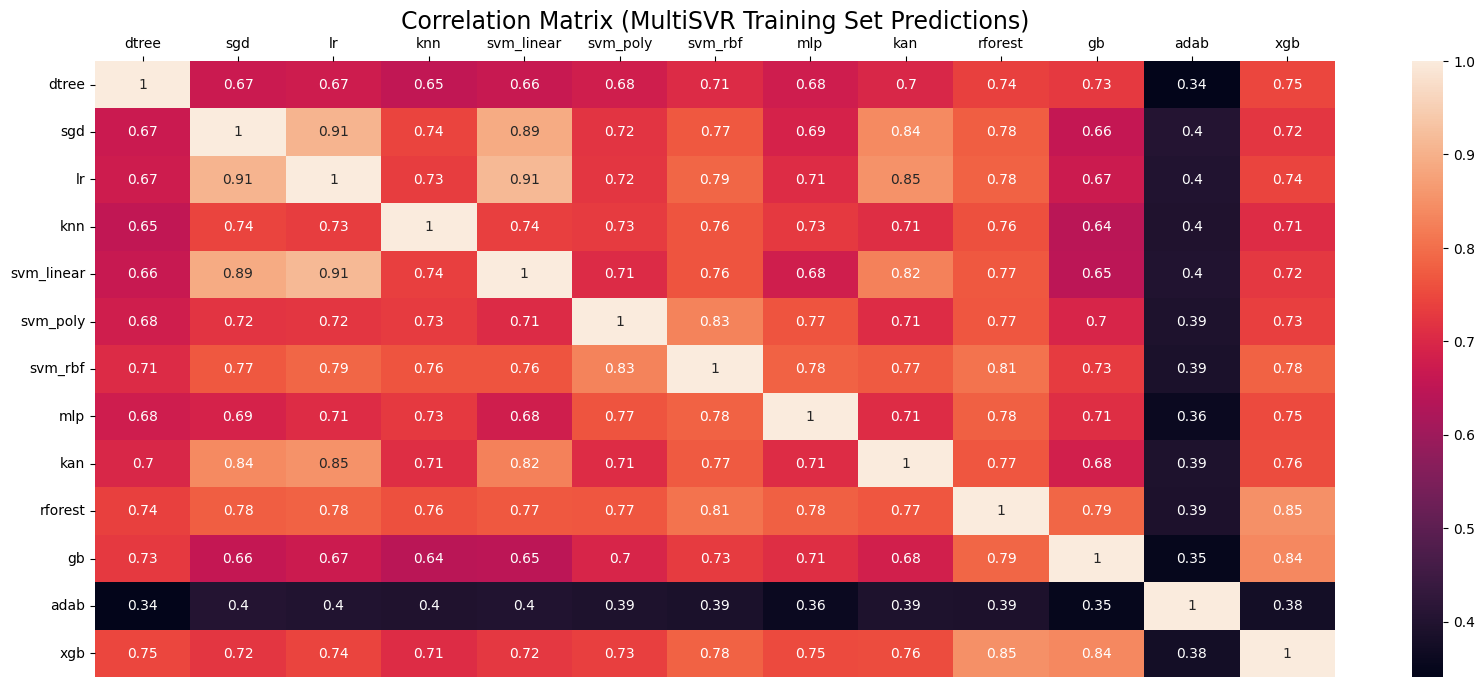

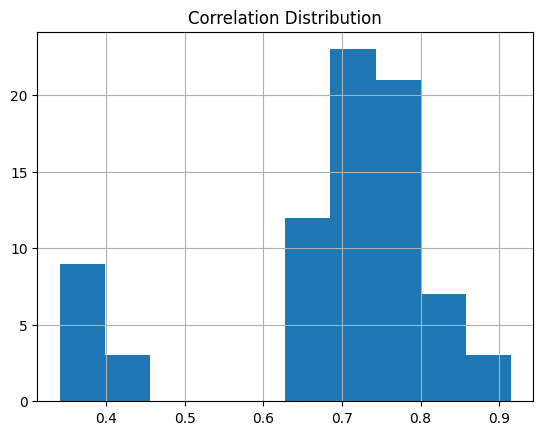

Training correlation distribution:
count    78.000000
mean      0.689237
std       0.143246
min       0.340751
25%       0.675307
50%       0.725917
75%       0.768832
max       0.914916
Name: corr, dtype: float64


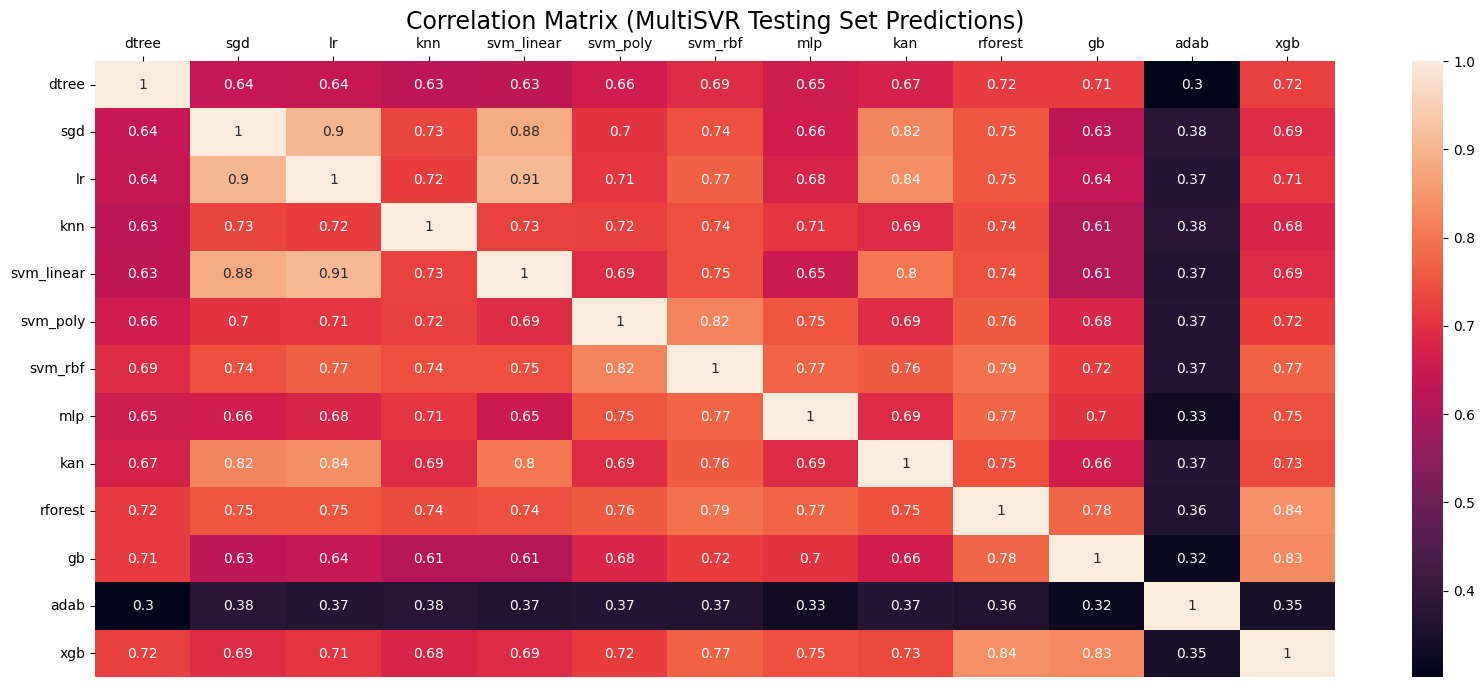

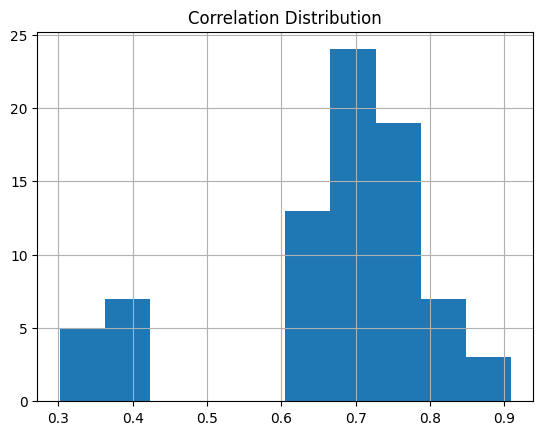

Testing correlation distribution:
count    78.000000
mean      0.668570
std       0.148023
min       0.301995
25%       0.644207
50%       0.706341
75%       0.751336
max       0.908680
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0398
NMSE: 0.1767
MAE: 1.6421
NMAE: 1.6685
aRRMSE: 1.2675
aCC: 0.6332


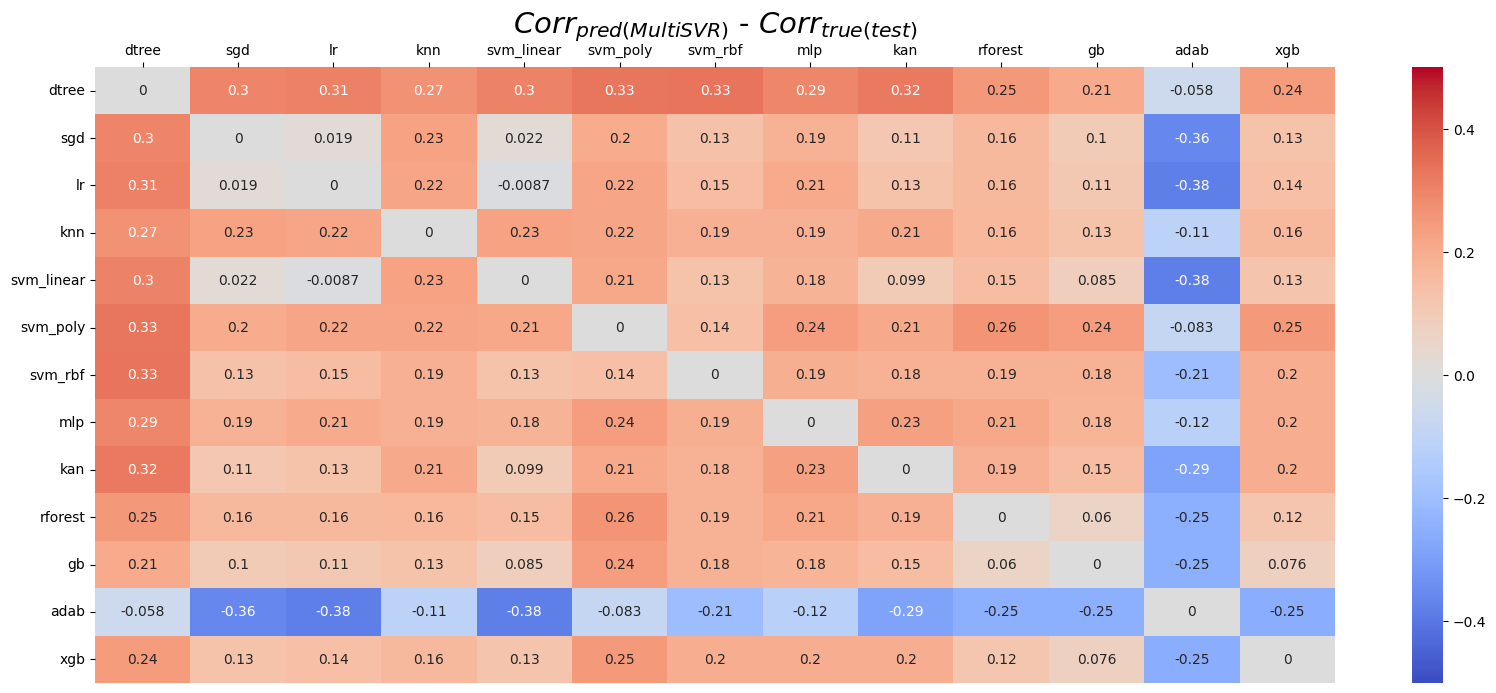

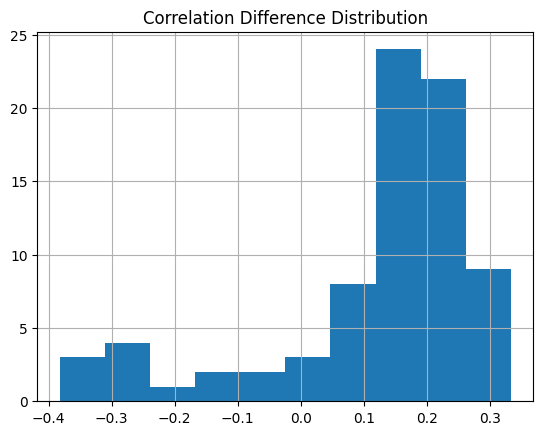

In [28]:
results = correlation_pred_performance(msvr, 
                                       pd.DataFrame(Xa_test_norm, index=Xa_test.index), 
                                       ya_test,
                                       pd.DataFrame(Xa_train_norm, index=Xa_train.index), 
                                       MIN_SCORE, name="MultiSVR")

In [29]:
diff_metrics.loc['M-SVR',:] = results['results']
diff_metrics.loc['M-SVR',:]

MSE       0.039805
MAE       0.176721
NMSE      1.642144
NMAE      1.668478
aRRMSE    1.267542
aCC       0.633198
Name: M-SVR, dtype: object

In [30]:
groups['msvr_assessor'] = results['groups']
groups['msvr_assessor']['test']

[['mlp',
  'lr',
  'rforest',
  'svm_rbf',
  'svm_linear',
  'xgb',
  'kan',
  'svm_poly',
  'knn',
  'sgd'],
 ['mlp', 'rforest', 'svm_rbf', 'xgb', 'kan', 'dtree', 'svm_poly', 'gb'],
 ['adab']]

### Multi-Output Regressor 
(ST)

In [23]:
single_tgt = MultiOutputRegressor(RandomForestRegressor(random_state=seed), 
                                  n_jobs=-1).fit(Xa_train, ya_train)

In [24]:
metrics_df.loc['ST',:] = assr_performance(single_tgt, Xa_test, ya_test, Xa_train, ya_train)

[TRAINING SET]
MSE: 0.0048
NMSE: 0.0752
MAE: 0.0437
NMAE: 0.2044
aRRMSE: 0.2742
aCC: 0.9694

[TESTING SET]
MSE: 0.0374
NMSE: 0.5837
MAE: 0.1244
NMAE: 0.5755
aRRMSE: 0.7640
aCC: 0.6529


#### Análise das correlações

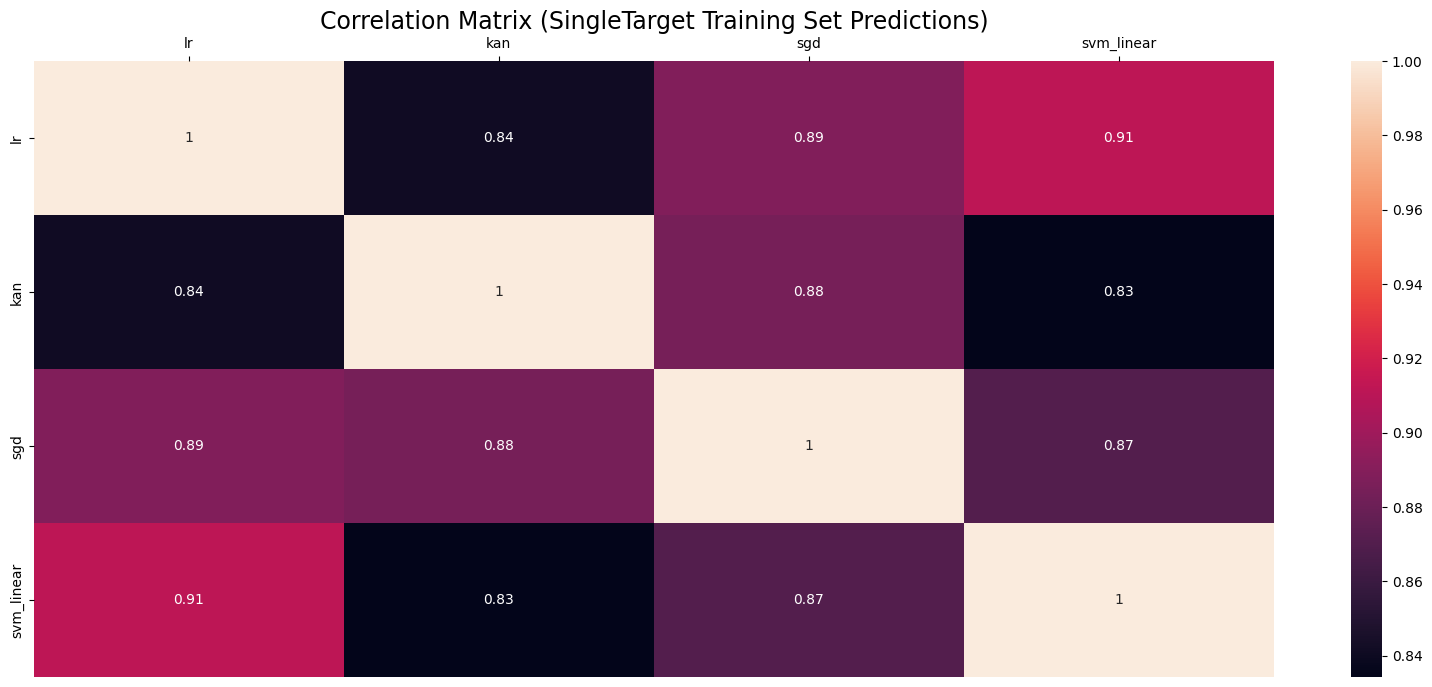

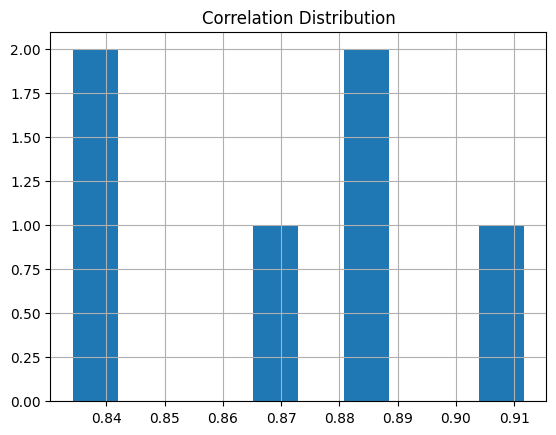

Training correlation distribution:
count    6.000000
mean     0.871655
std      0.029511
min      0.834291
25%      0.848519
50%      0.877162
75%      0.887305
max      0.911659
Name: corr, dtype: float64


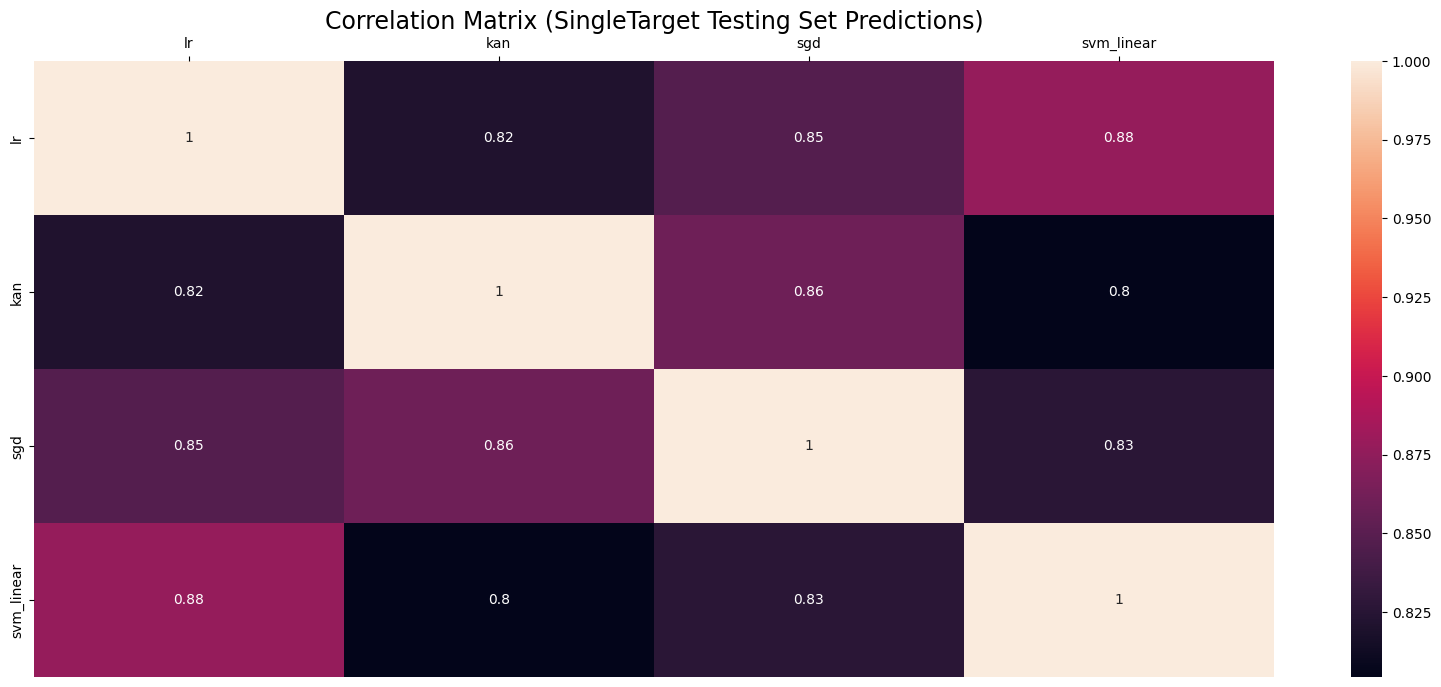

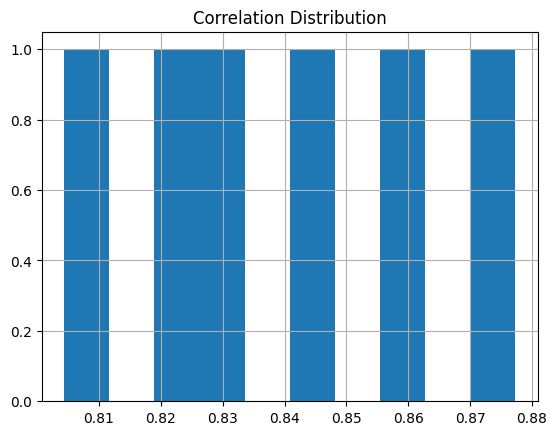

Testing correlation distribution:
count    6.000000
mean     0.839373
std      0.027063
min      0.804384
25%      0.822288
50%      0.836783
75%      0.856853
max      0.877289
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0006
NMSE: 0.0173
MAE: 0.1407
NMAE: 0.3208
aRRMSE: 0.3501
aCC: 0.9830


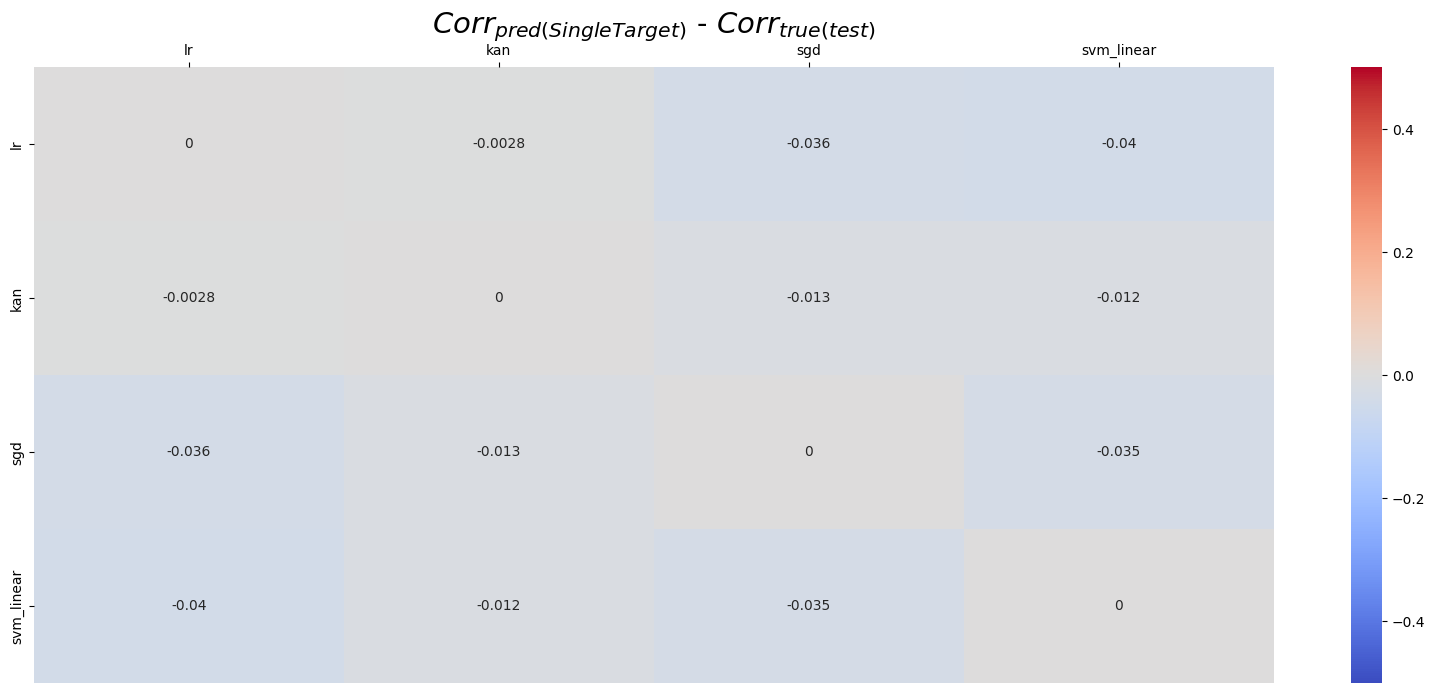

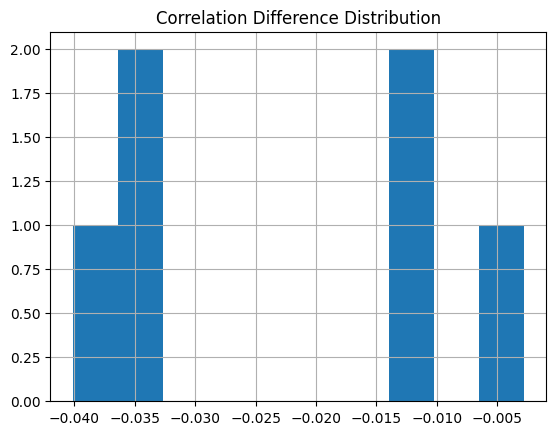

In [25]:
results = correlation_pred_performance(single_tgt, Xa_test, ya_test, Xa_train,
                                       MIN_SCORE, name="SingleTarget")

In [26]:
diff_metrics.loc['ST',:] = results['results']
diff_metrics.loc['ST',:]

MSE       0.000551
MAE       0.017269
NMSE      0.140664
NMAE       0.32082
aRRMSE    0.350057
aCC          0.983
Name: ST, dtype: object

In [27]:
groups['st_assessor'] = results['groups']
groups['st_assessor']['test']

[['lr', 'svm_linear'], ['sgd', 'kan']]

## Grupais

In [38]:
#keys = list(groups.keys())
#for i in range(len(keys)):
#    for j in range(i+1, len(keys)):
#        print(f'{keys[i]}({len(groups[keys[i]])}) & {keys[j]}({len(groups[keys[j]])}):')
#        count = 0
#        for g in groups[keys[i]]:
#            if(g in groups[keys[j]]):
#                print(g)
#                count += 1
#        print(f'Número de grupos em comum: {count}\n\n')

In [28]:
for g in groups['true_assessor_train']:
    if(len(g)!=1):
        teste = []
        for i, m in enumerate(g):
            for n in g[i+1:]:
                teste.append(pred_corrls.loc[m,n])
        print(g)
        print(f'total: {np.mean(teste)}\n')

['lr', 'sgd', 'svm_linear']
total: 0.8882314253865937

['sgd', 'kan']
total: 0.8693757637363885



### Regressor Chain

In [29]:
#[RegressorChain(base_estimator=RandomForestRegressor(random_state=seed),
#                random_state=seed,
#                order='random', cv=5) for _ in range(num_chains)]

rcg = GroupedAssessor([RegressorChain(base_estimator=RandomForestRegressor(random_state=seed),
                                      random_state=seed,
                                      order='random', 
                                      cv=5) for _ in range(len(groups['true_assessor_train']))])

rcg.fit(Xa_train, ya_train, groups=groups['true_assessor_train'])

[TRAINING SET]
MSE: 0.0190
NMSE: 0.2983
MAE: 0.0789
NMAE: 0.3694
aRRMSE: 0.5175
aCC: 0.8383

[TESTING SET]
MSE: 0.0371
NMSE: 0.5786
MAE: 0.1256
NMAE: 0.5810
aRRMSE: 0.7605
aCC: 0.6548


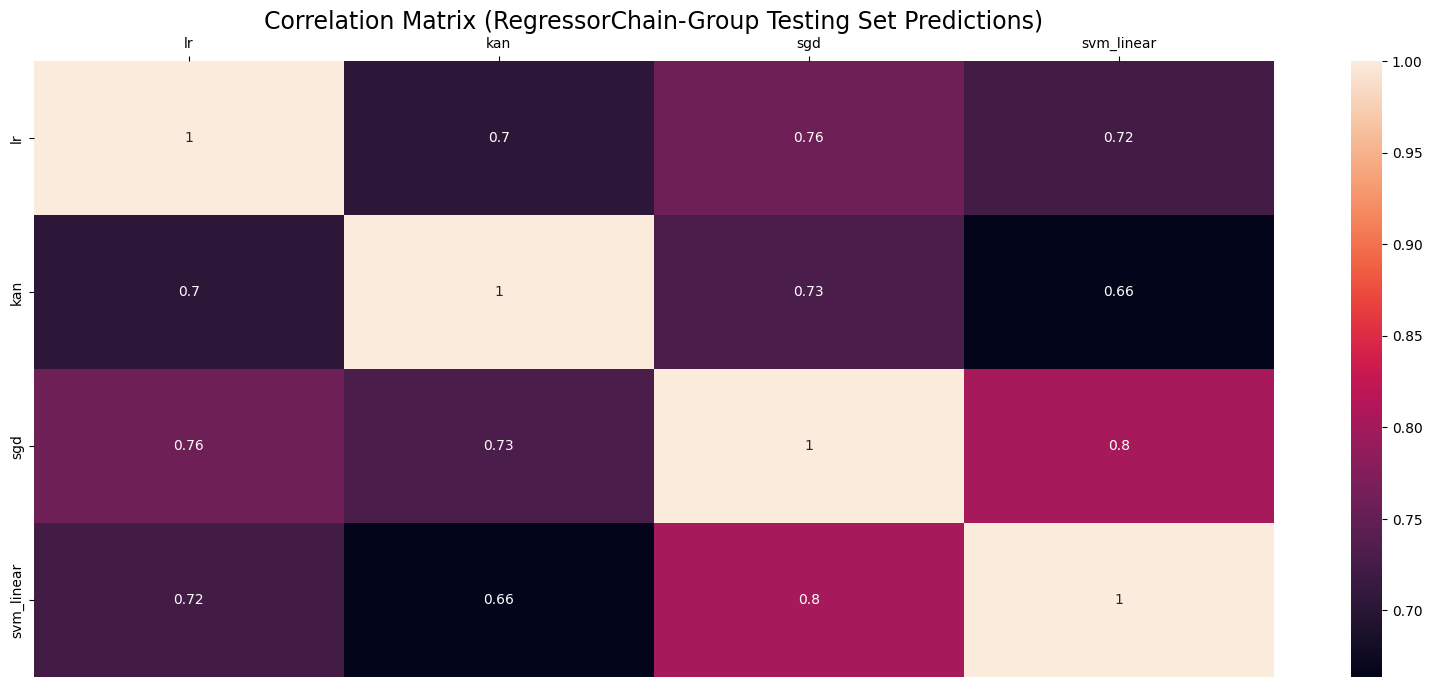

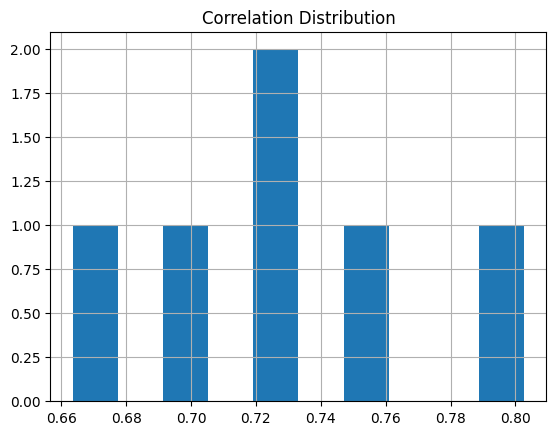

Testing correlation distribution:
count    6.000000
mean     0.730169
std      0.047284
min      0.663629
25%      0.708770
50%      0.726516
75%      0.750781
max      0.802629
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0144
NMSE: 0.0992
MAE: 3.3605
NMAE: 1.7964
aRRMSE: 1.8275
aCC: 0.9161


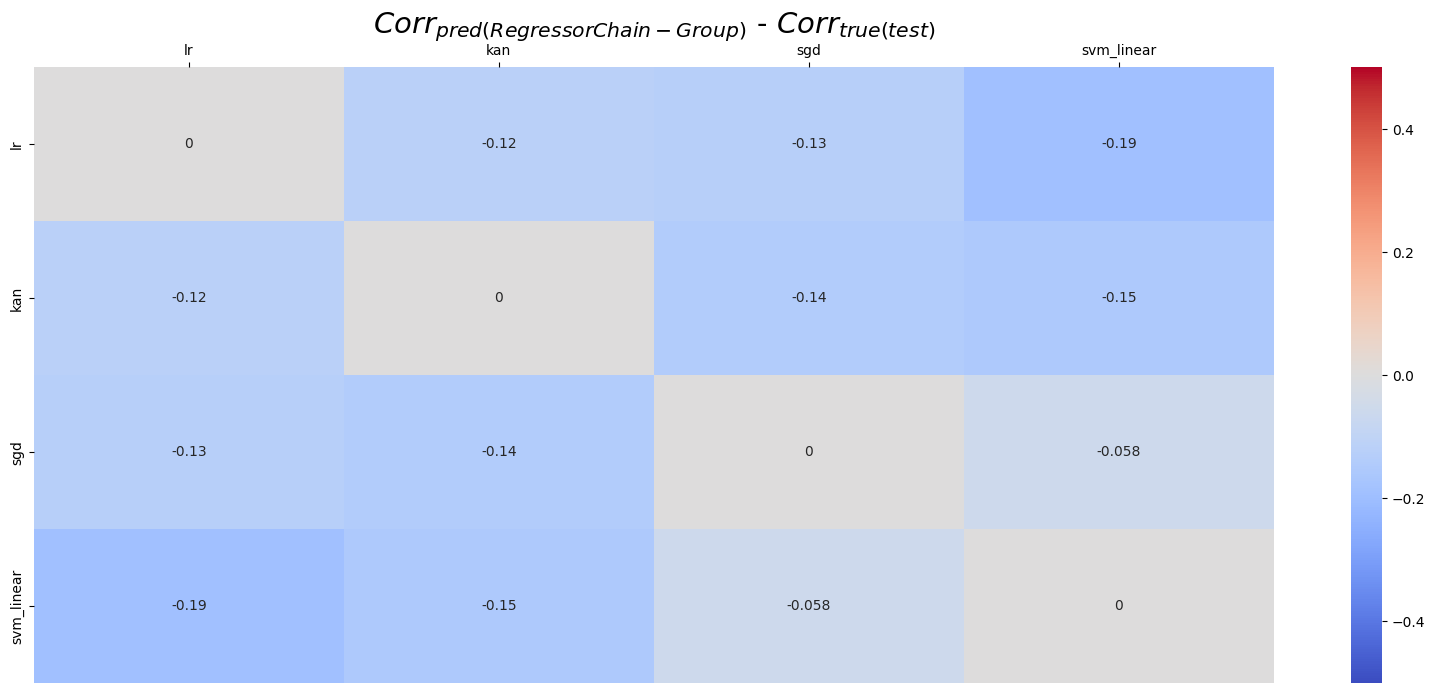

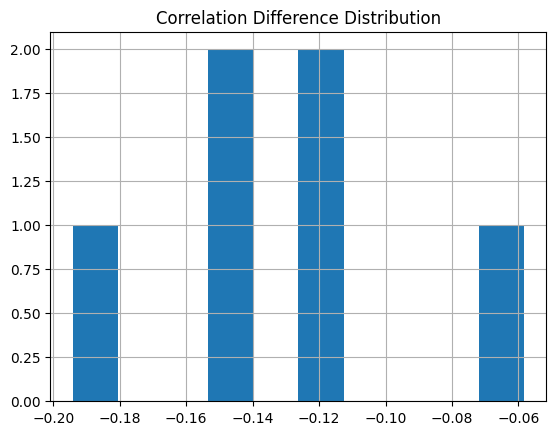

[['lr'], ['sgd'], ['svm_linear'], ['kan']]


In [30]:
metrics_df.loc['RC(g)',:] = assr_performance(rcg, Xa_test, ya_test, Xa_train, ya_train)

results = correlation_pred_performance(rcg, Xa_test, ya_test, min_score=MIN_SCORE, name="RegressorChain-Group")

diff_metrics.loc['RC(g)',:] = results['results']

groups['rcg_assessor'] = results['groups']
print(groups['rcg_assessor']['test'])

In [31]:
results

{'results': [0.014366009870071278,
  0.09917262436310684,
  np.float64(3.3604957700143228),
  np.float64(1.796393942433553),
  np.float64(1.8274526664244597),
  np.float64(0.9161043070095591)],
 'groups': {'test': [['lr'], ['sgd'], ['svm_linear'], ['kan']]}}

In [28]:
rcg = None

### Ensemble of Regressor Chains

In [39]:
#rcg = GroupedAssessor(RegressorChain, model_names, random_state=seed)
#rcg.fit(Xa_train, ya_train, groups['true_assessor_train'], base_estimator=RandomForestRegressor(random_state=seed), 
#        random_state=seed, order='random', cv=5)

#rcg_plus = GroupedAssessor(VotingRegressor, model_names, random_state=seed,
#                           estimators=rc_ests, n_jobs=-1)

rcg_ac = f'RC[{num_chains}](g)'

rcg_plus = GroupedAssessor([GroupedAssessor([RegressorChain(
                                                base_estimator=RandomForestRegressor(random_state=seed),
                                                random_state=seed+i,
                                                order='random', cv=5) for i in range(num_chains)]
                                            ) for _ in range(len(groups['true_assessor_train']))])

rcg_plus.fit(Xa_train, ya_train, groups=groups['true_assessor_train'])

In [ ]:
# keeping the concat because multiple numbers of chains could be recorded
#50chains
if(rcg_ac in metrics_df.index):
    metrics_df.loc[rcg_ac,:] = assr_performance(rcg_plus, Xa_test, ya_test, Xa_train, ya_train)
else:
    new_df = pd.DataFrame(assr_performance(rcg_plus, Xa_test, ya_test, Xa_train, ya_train), 
                          columns=metrics_cols,
                          index=multIdx(rcg_ac, subindex=model_names))

    metrics_df = pd.concat([metrics_df, new_df])

results = correlation_pred_performance(rcg_plus, Xa_test, ya_test, min_score=MIN_SCORE, name=f"RegressorChain[{num_chains}]-Group")

diff_metrics.loc[rcg_ac,:] = results['results']

groups[f'rcg({num_chains})_assessor'] = results['groups']
print(groups[f'rcg({num_chains})_assessor']['test'])

[TRAINING SET]
MSE: 0.0149
NMSE: 0.2343
MAE: 0.0755
NMAE: 0.3523
aRRMSE: 0.4837
aCC: 0.8889

[TESTING SET]
MSE: 0.0356
NMSE: 0.5566
MAE: 0.1244
NMAE: 0.5755
aRRMSE: 0.7460
aCC: 0.6683


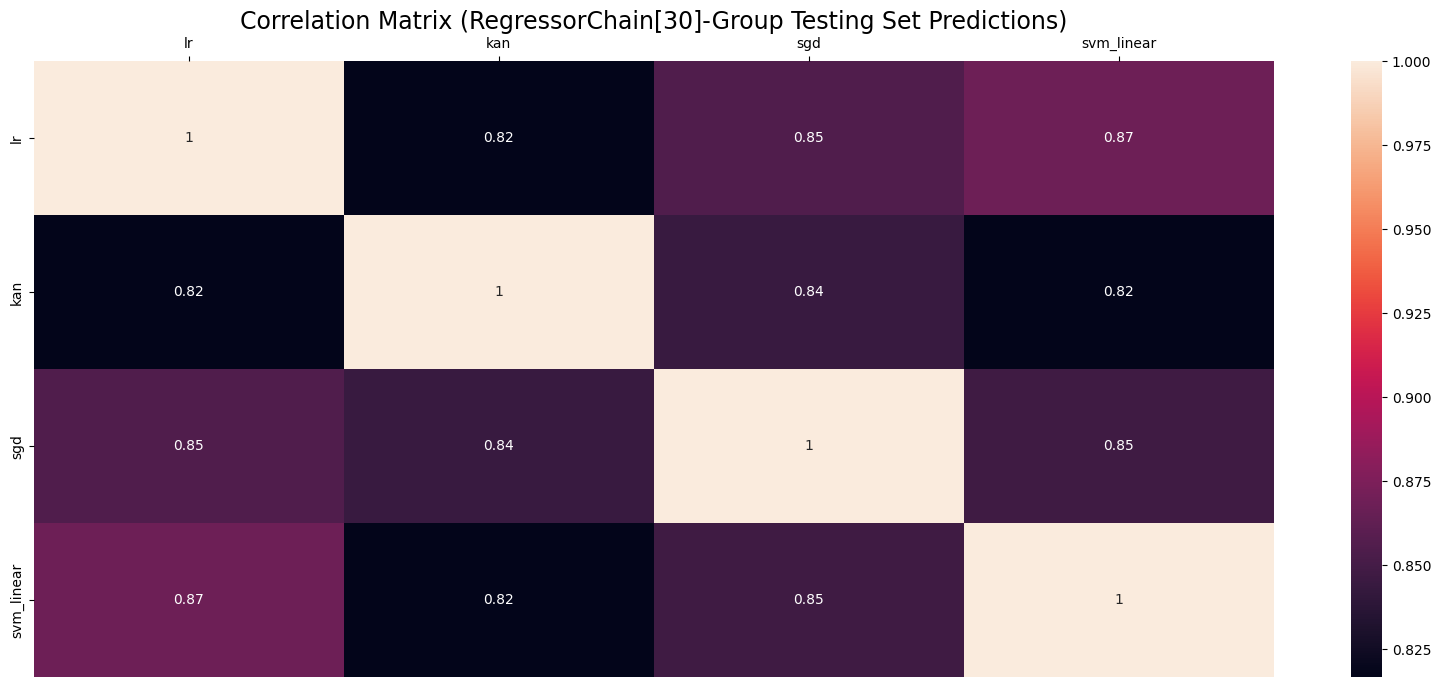

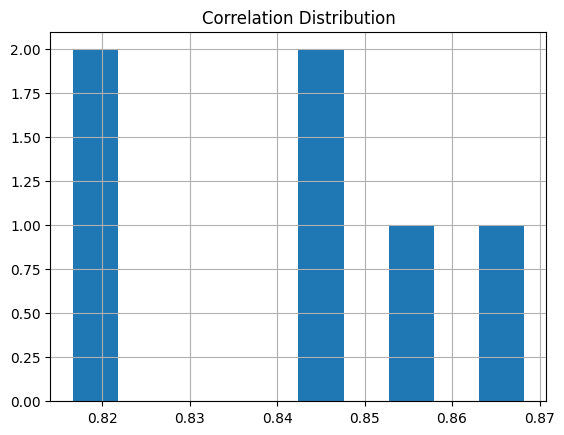

Testing correlation distribution:
count    6.000000
mean     0.841317
std      0.020695
min      0.816663
25%      0.823888
50%      0.845567
75%      0.852814
max      0.868218
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0005
NMSE: 0.0160
MAE: 0.1317
NMAE: 0.2977
aRRMSE: 0.3511
aCC: 0.9751


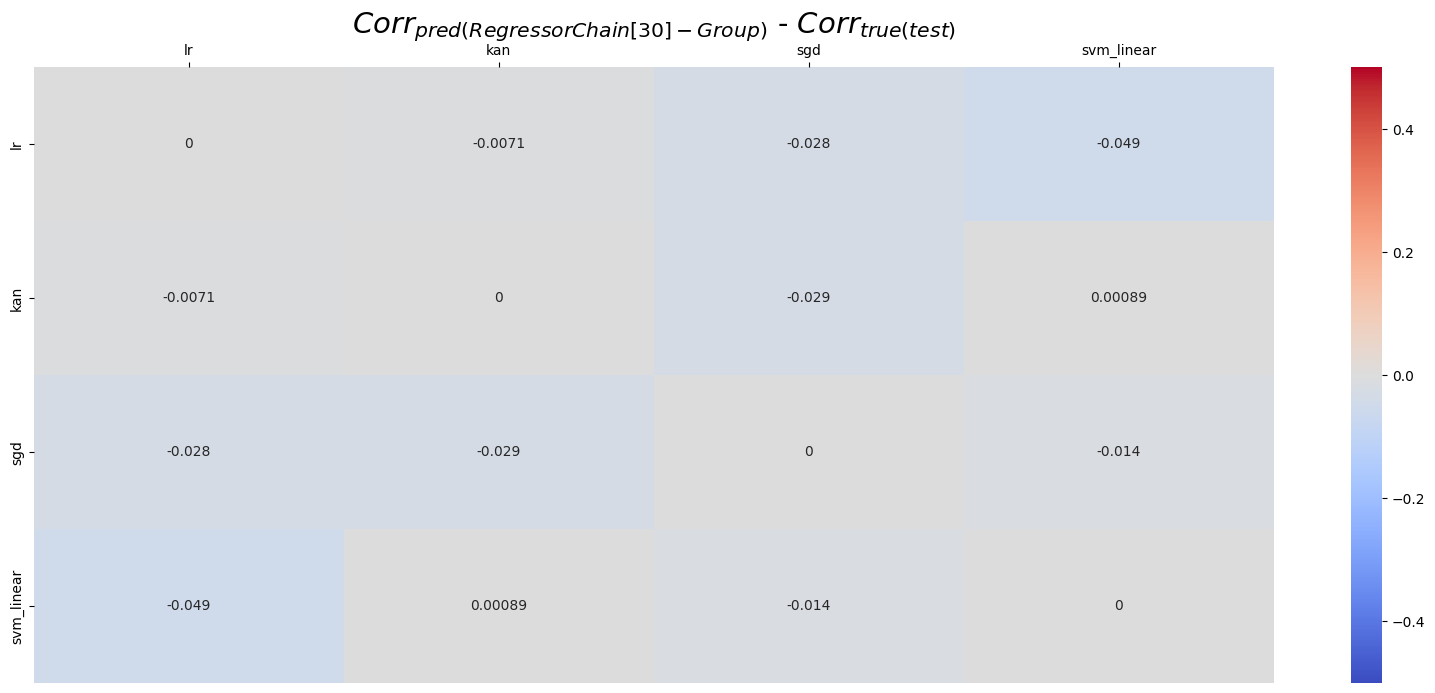

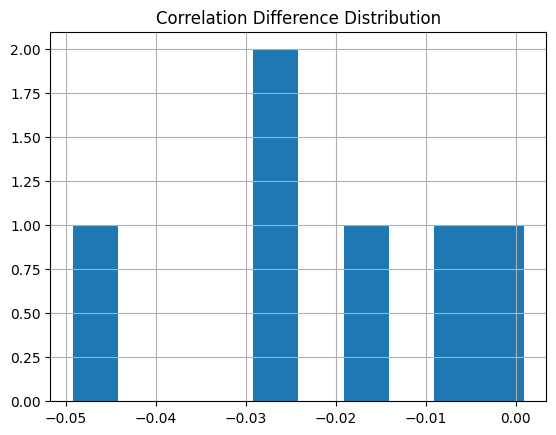

[['lr', 'sgd'], ['lr', 'svm_linear'], ['kan']]


In [40]:
# keeping the concat because multiple numbers of chains could be recorded
#30chains
if(rcg_ac in metrics_df.index):
    metrics_df.loc[rcg_ac,:] = assr_performance(rcg_plus, Xa_test, ya_test, Xa_train, ya_train)
else:
    new_df = pd.DataFrame(assr_performance(rcg_plus, Xa_test, ya_test, Xa_train, ya_train), 
                          columns=metrics_cols,
                          index=multIdx(rcg_ac, subindex=model_names))

    metrics_df = pd.concat([metrics_df, new_df])

results = correlation_pred_performance(rcg_plus, Xa_test, ya_test, min_score=MIN_SCORE, name=f"RegressorChain[{num_chains}]-Group")

diff_metrics.loc[rcg_ac,:] = results['results']

groups[f'rcg({num_chains})_assessor'] = results['groups']
print(groups[f'rcg({num_chains})_assessor']['test'])

[TRAINING SET]
MSE: 0.0151
NMSE: 0.2373
MAE: 0.0760
NMAE: 0.3547
aRRMSE: 0.4869
aCC: 0.8874

[TESTING SET]
MSE: 0.0357
NMSE: 0.5578
MAE: 0.1245
NMAE: 0.5761
aRRMSE: 0.7468
aCC: 0.6675


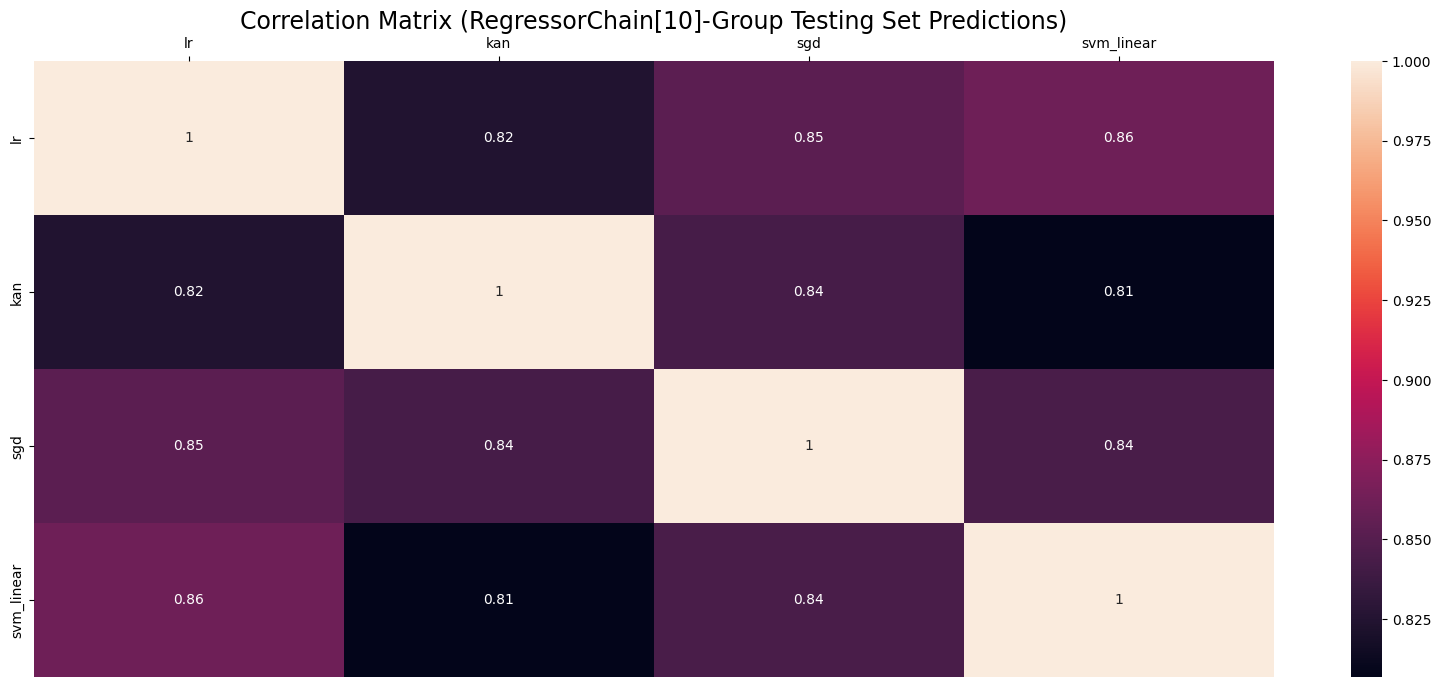

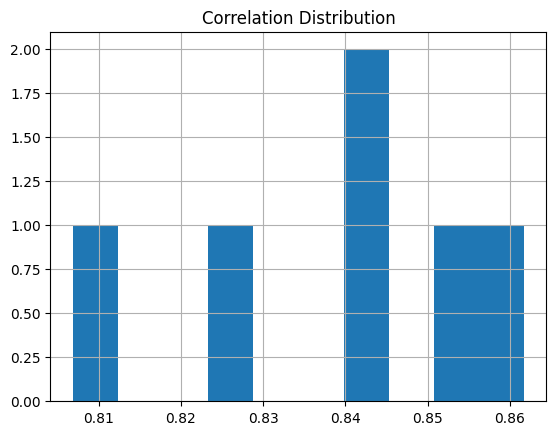

Testing correlation distribution:
count    6.000000
mean     0.838650
std      0.019928
min      0.806889
25%      0.828811
50%      0.843338
75%      0.850324
max      0.861715
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0007
NMSE: 0.0179
MAE: 0.1629
NMAE: 0.3313
aRRMSE: 0.3895
aCC: 0.9695


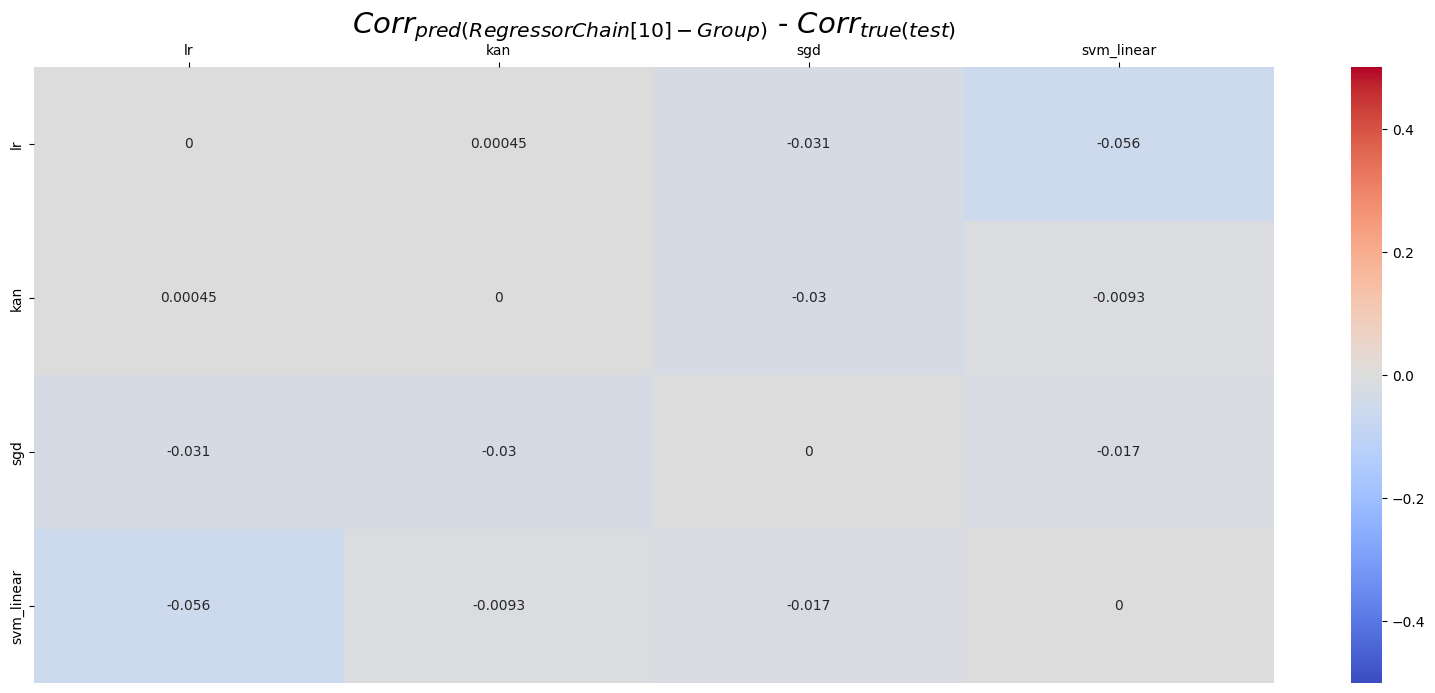

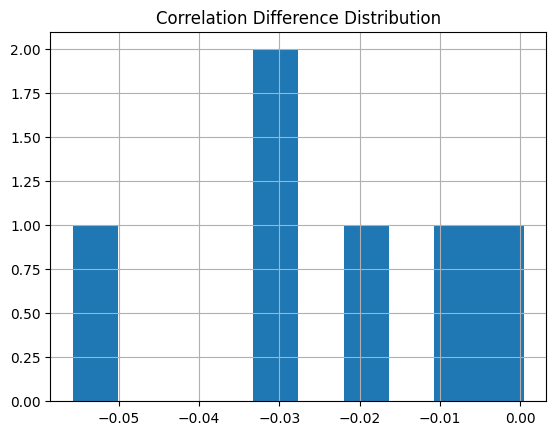

[['lr', 'sgd'], ['lr', 'svm_linear'], ['kan']]


In [33]:
# keeping the concat because multiple numbers of chains could be recorded
#10chains
if(rcg_ac in metrics_df.index):
    metrics_df.loc[rcg_ac,:] = assr_performance(rcg_plus, Xa_test, ya_test, Xa_train, ya_train)
else:
    new_df = pd.DataFrame(assr_performance(rcg_plus, Xa_test, ya_test, Xa_train, ya_train), 
                          columns=metrics_cols,
                          index=multIdx(rcg_ac, subindex=model_names))

    metrics_df = pd.concat([metrics_df, new_df])

results = correlation_pred_performance(rcg_plus, Xa_test, ya_test, min_score=MIN_SCORE, name=f"RegressorChain[{num_chains}]-Group")

diff_metrics.loc[rcg_ac,:] = results['results']

groups[f'rcg({num_chains})_assessor'] = results['groups']
print(groups[f'rcg({num_chains})_assessor']['test'])

In [31]:
rcg_plus = None

### Multi-Output SVR

In [ ]:
msvrg = GroupedAssessor([MSVR() for _ in range(len(groups['true_assessor_train']))])

msvrg.fit(Xa_train_norm, ya_train, groups['true_assessor_train'])

c:\Users\pedro\Documents\NOVOdeltadelta\pog\meu\proj-mtr\MSVR.py:74: RuntimeWarning: divide by zero encountered in divide
  a = 2 * C * (u - epsi) / u
c:\Users\pedro\Documents\NOVOdeltadelta\pog\meu\proj-mtr\MSVR.py:74: RuntimeWarning: divide by zero encountered in divide
  a = 2 * C * (u - epsi) / u


[TRAINING SET]
MSE: 0.0716
NMSE: 0.7840
MAE: 0.1894
NMAE: 0.8278
aRRMSE: 0.8695
aCC: 0.5485

[TESTING SET]
MSE: 0.0802
NMSE: 0.8254
MAE: 0.2006
NMAE: 0.8448
aRRMSE: 0.8991
aCC: 0.4799


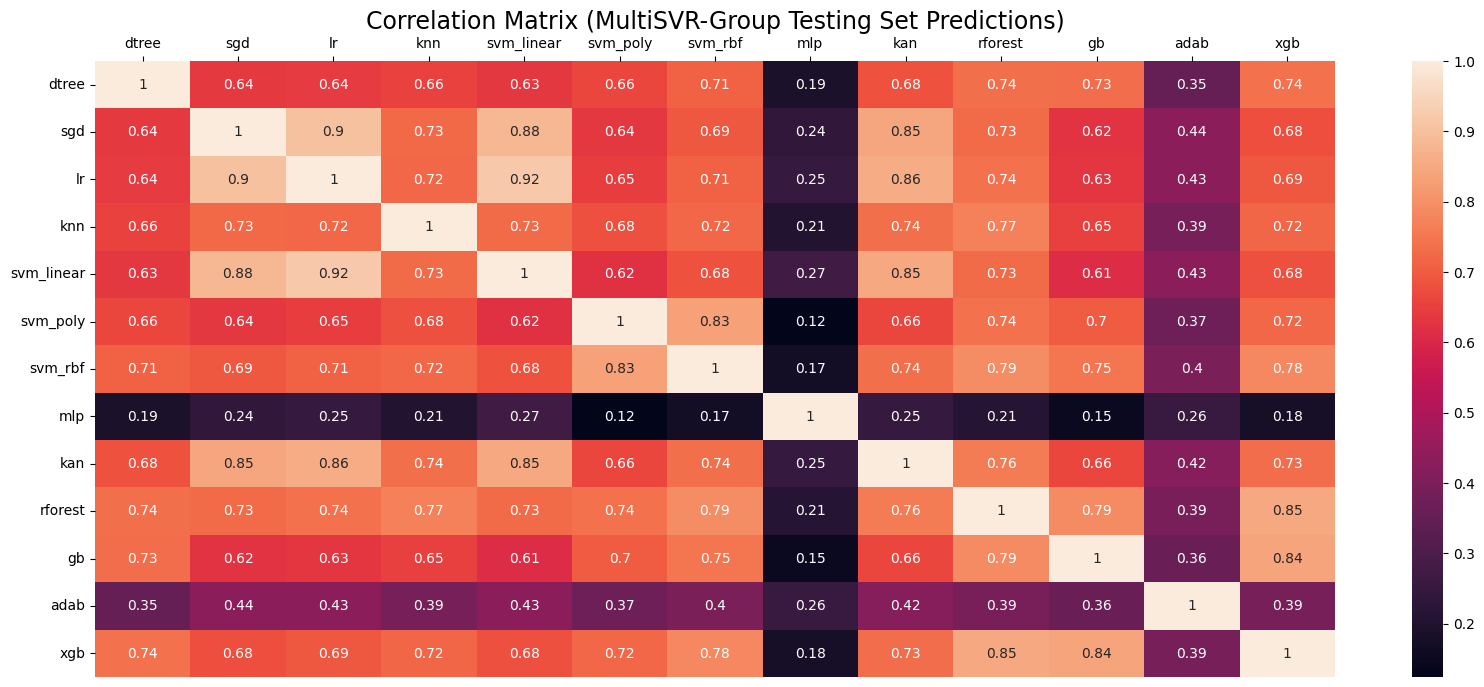

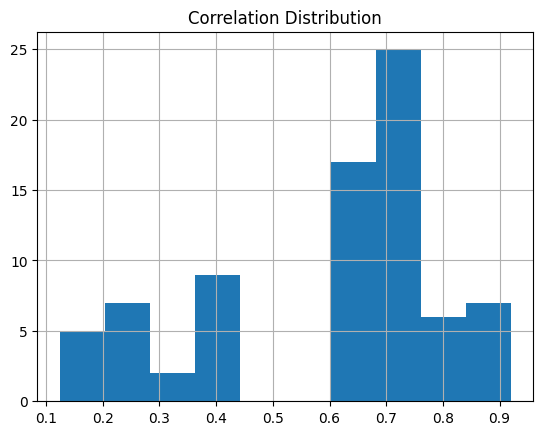

Testing correlation distribution:
count    78.000000
mean      0.600884
std       0.214307
min       0.124314
25%       0.422323
50%       0.678512
75%       0.735569
max       0.919881
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0439
NMSE: 0.1821
MAE: 1.8827
NMAE: 1.7511
aRRMSE: 1.3410
aCC: 0.5953


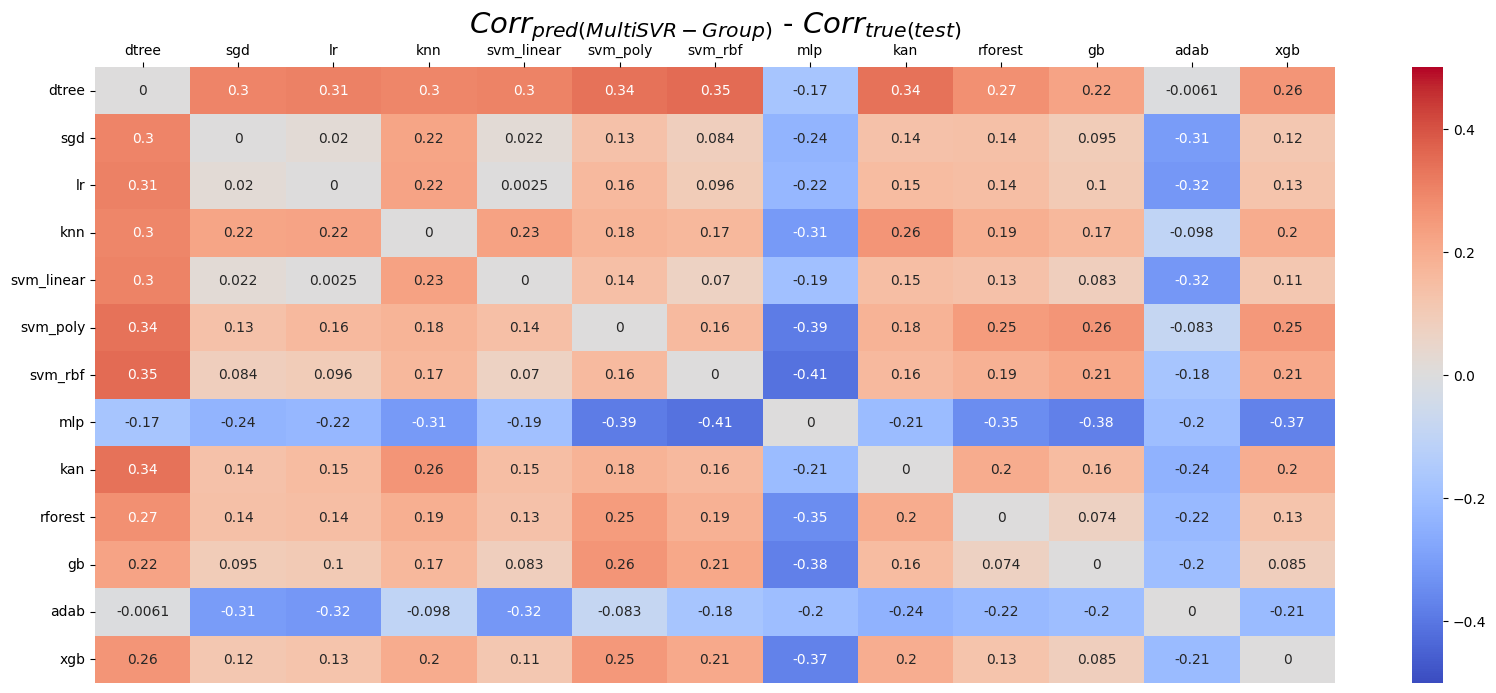

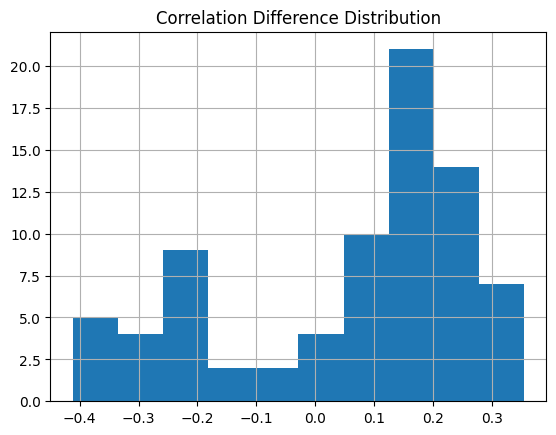

[['mlp'], ['rforest', 'svm_rbf', 'xgb', 'kan', 'dtree', 'svm_poly', 'gb'], ['lr', 'rforest', 'svm_rbf', 'svm_linear', 'xgb', 'kan', 'knn', 'sgd'], ['rforest', 'svm_rbf', 'xgb', 'kan', 'dtree', 'svm_poly', 'knn'], ['adab']]


In [44]:
metrics_df.loc['M-SVR(g)',:] = assr_performance(msvrg, Xa_test_norm, ya_test, Xa_train_norm, ya_train)

results = correlation_pred_performance(msvrg, pd.DataFrame(Xa_test_norm, index=Xa_test.index), 
                                       ya_test, min_score=MIN_SCORE, name="MultiSVR-Group")

diff_metrics.loc['M-SVR(g)',:] = results['results']

groups['msvrg_assessor'] = results['groups']
print(groups['msvrg_assessor']['test'])

### Multi-Target Random Forest Regressor

In [ ]:
mrfg = GroupedAssessor([RandomForestRegressor(random_state=seed) for _ in range(len(groups['true_assessor_train']))])

mrfg.fit(Xa_train, ya_train, groups['true_assessor_train'])

c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[TRAINING SET]
MSE: 0.0103
NMSE: 0.0996
MAE: 0.0666
NMAE: 0.2563
aRRMSE: 0.3141
aCC: 0.9660

[TESTING SET]
MSE: 0.0772
NMSE: 0.7313
MAE: 0.1874
NMAE: 0.7067
aRRMSE: 0.8513
aCC: 0.5200


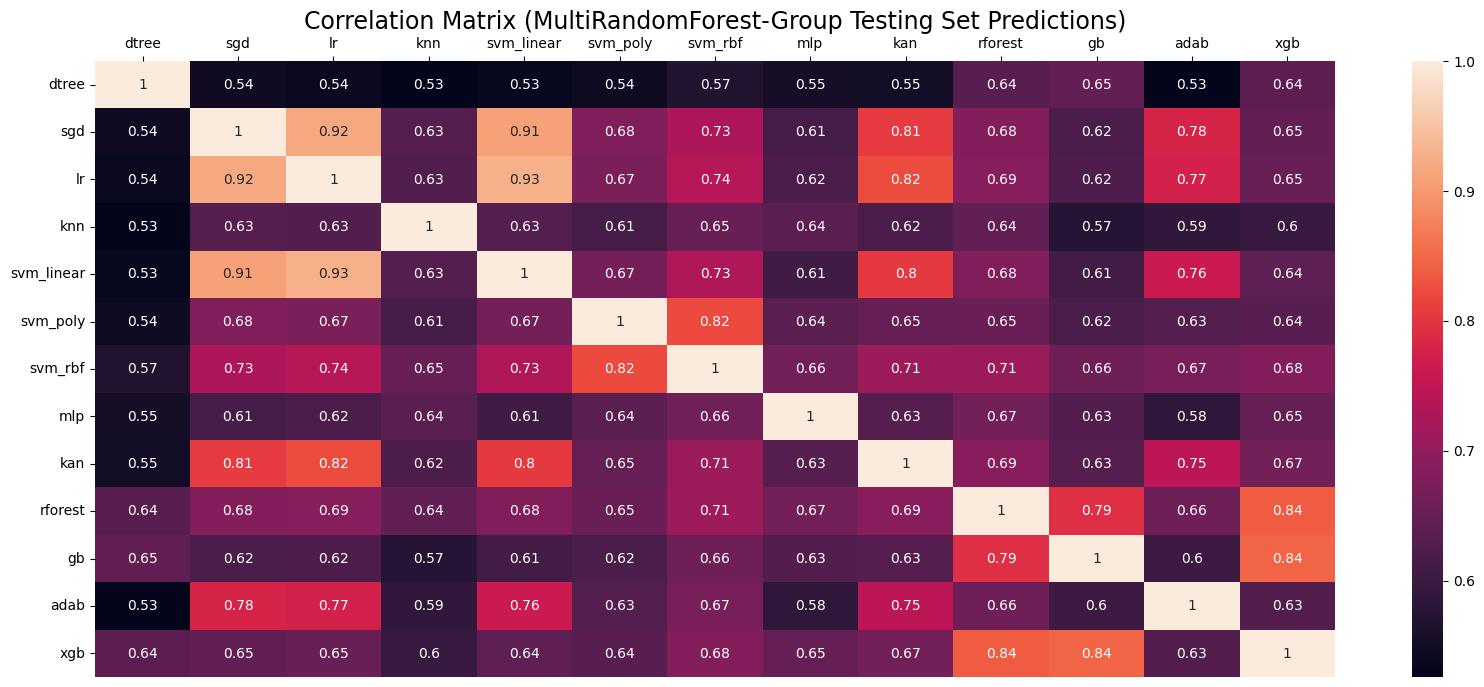

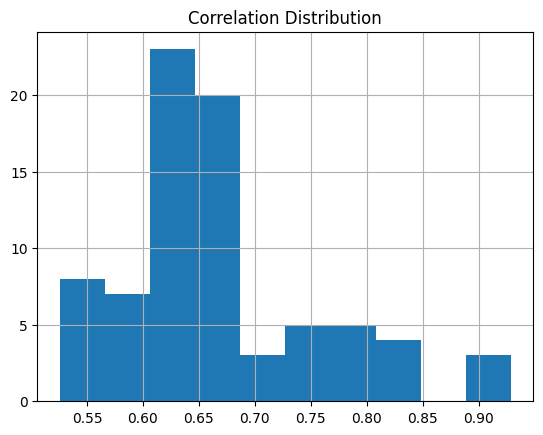

Testing correlation distribution:
count    78.000000
mean      0.667226
std       0.090310
min       0.525744
25%       0.619699
50%       0.647656
75%       0.687940
max       0.928777
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0154
NMSE: 0.1103
MAE: 0.6356
NMAE: 1.0473
aRRMSE: 0.7821
aCC: 0.9780


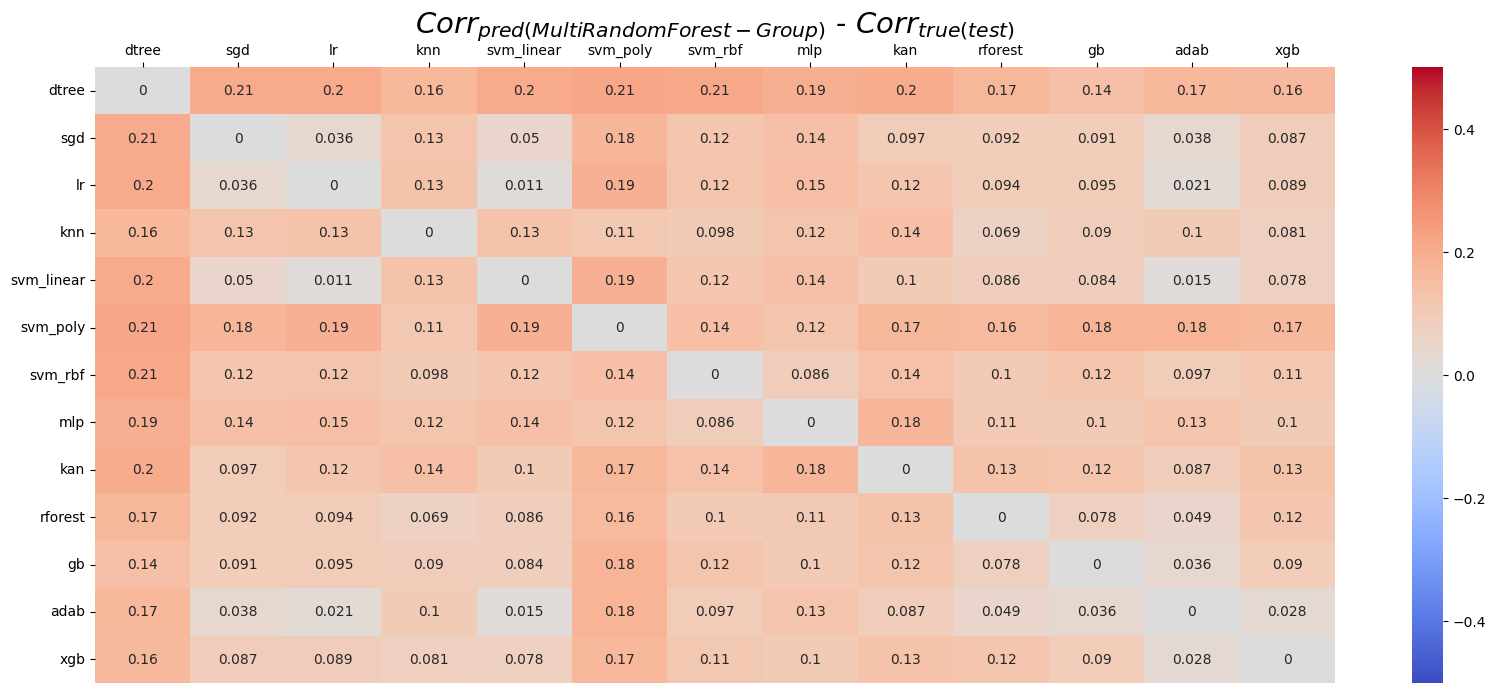

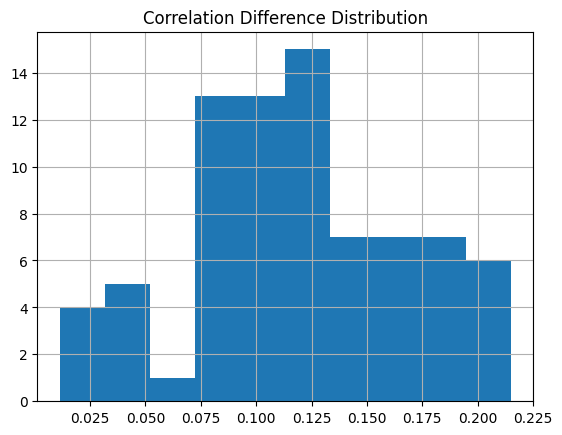

[['dtree'], ['mlp', 'xgb', 'rforest', 'svm_rbf'], ['lr', 'rforest', 'svm_rbf', 'svm_linear', 'kan', 'svm_poly', 'sgd'], ['lr', 'rforest', 'svm_rbf', 'svm_linear', 'kan', 'adab', 'sgd'], ['lr', 'rforest', 'svm_rbf', 'xgb', 'kan'], ['gb', 'rforest', 'svm_rbf', 'xgb'], ['knn', 'svm_rbf']]


In [46]:
metrics_df.loc['MRT(g)',:] = assr_performance(mrfg, Xa_test, ya_test, Xa_train, ya_train)

results = correlation_pred_performance(mrfg, Xa_test, ya_test, min_score=MIN_SCORE, name="MultiRandomForest-Group")

diff_metrics.loc['MRT(g)',:] = results['results']

groups['mrfg_assessor'] = results['groups']
print(groups['mrfg_assessor']['test'])

In [47]:
#keys = list(groups.keys())
#OBJV = len(groups['true_assessor_test'])
#for i in range(len(keys)):
#    if('test' in keys[i] and keys[i] != 'true_assessor_test'):
#        print(f'{keys[i]}({len(groups[keys[i]])}) & true_assessor_test({OBJV}):')
#        count = 0
#        for g in groups[keys[i]]:
#            if(g in groups['true_assessor_test']):
#                print(g)
#                count += 1
#        print(f'Número de grupos em comum: {count}\n\n')

## Análises

In [ ]:
results_df = metrics_df.dropna().copy()
results_df = results_df.reset_index()

results_df

Assessor       Model       MSE       MAE      NMSE      NMAE    aRRMSE  \
0        ST       dtree  0.181723  0.909715  0.337815    0.8446   0.95379   
1        ST         sgd  0.032892  0.565911  0.115303  0.557592  0.752271   
2        ST          lr  0.040547  0.596436  0.131403  0.586247  0.772293   
3        ST         knn  0.116835  0.842509  0.263283  0.798898  0.917883   
4        ST  svm_linear  0.038628  0.576955  0.129083  0.580858  0.759575   
..      ...         ...       ...       ...       ...       ...       ...   
86    RC(g)         kan  0.041679  0.784798  0.133938  0.685187  0.885888   
87    RC(g)     rforest  0.063073  0.824896  0.202312    0.8717  0.908238   
88    RC(g)          gb  0.137709  0.870389  0.270384  0.802271  0.932946   
89    RC(g)        adab  0.000074  0.275801  0.002625  0.336503  0.525168   
90    RC(g)         xgb   0.11083  0.965389  0.275095  0.961565  0.982542   

         aCC  
0   0.335972  
1   0.665716  
2   0.642698  
3   0.422981  
4   0.658345  
..       ...  
86  0.504878  
87  0.509928  
88  0.390141  
89  0.851247  
90  0.392785  

[91 rows x 8 columns]

In [ ]:
diff_results = diff_metrics.dropna().reset_index(names=['Assessor'])
diff_results.to_csv(f'data/{DIR}/results_diff_RC.csv') # MUDAR PARA O NORMAL
diff_results

Assessor       MSE       MAE      NMSE      NMAE    aRRMSE       aCC
0        ST   0.01319  0.098584  0.539985  0.938679  0.719079  0.975422
1       MRT  0.028811  0.152754  1.206294  1.459116  1.078645  0.970998
2    MRT(g)  0.015385   0.11029  0.635642  1.047279  0.782089  0.977977
3     M-SVR  0.039805  0.176721  1.642144  1.668478  1.267542  0.633198
4  M-SVR(g)  0.043913  0.182072  1.882668  1.751085  1.341004  0.595334
5        RC  0.013986  0.102654  0.575558  0.967698  0.747608  0.930882
6     RC(g)  0.010658  0.083729  0.427877  0.789696  0.639437  0.887476

In [ ]:
win_table = pd.DataFrame(index=results_df['Assessor'].unique(), columns=results_df.drop(columns=['Assessor', 'Model']).columns)

for mt in ['MSE', 'MAE', 'NMSE', 'NMAE', 'aRRMSE']:
    assr_wins = results_df.loc[results_df.groupby("Model")[mt].idxmin(), ["Model", "Assessor", mt]]
    win_table[mt] = assr_wins['Assessor'].value_counts()

assr_wins = results_df.loc[results_df.groupby("Model")['aCC'].idxmin(), ["Model", "Assessor", 'aCC']]
win_table['aCC'] = assr_wins['Assessor'].value_counts()

win_table = win_table.fillna(0)
win_table.to_csv(f'data/{DIR}/win_table_RC.csv') # MUDAR PARA NORMAL
win_table

MSE  MAE  NMSE  NMAE  aRRMSE  aCC
ST        0.0  0.0   4.0   4.0     0.0  2.0
MRT       0.0  0.0   0.0   0.0     0.0  1.0
MRT(g)    0.0  0.0   2.0   2.0     0.0  0.0
M-SVR     9.0  9.0   1.0   1.0     9.0  2.0
M-SVR(g)  3.0  3.0   2.0   2.0     3.0  2.0
RC        0.0  0.0   0.0   0.0     0.0  2.0
RC(g)     1.0  1.0   4.0   4.0     1.0  4.0

In [ ]:
summary = results_df.drop(columns=['Model']).groupby(['Assessor']).agg(['mean', 'std'])
summary.to_csv(f'data/{DIR}/results_RC.csv') # MUDAR PARA O NORMAL
summary

MSE                 MAE                NMSE            \
              mean       std      mean       std      mean       std   
Assessor                                                               
M-SVR     0.073825  0.050925  0.729316  0.123559  0.195793  0.089777   
M-SVR(g)  0.080182  0.058931  0.825433  0.265948  0.200602  0.086517   
MRT       0.077513  0.052700  0.740974  0.128985  0.188526  0.087897   
MRT(g)    0.077169  0.052455  0.731313  0.139942  0.187375  0.088265   
RC        0.076159  0.051453  0.711582  0.164042  0.191172  0.088400   
RC(g)     0.079909  0.052512  0.746634  0.190111  0.194831  0.091482   
ST        0.077238  0.052389  0.718691  0.173026  0.187028  0.088659   

              NMAE              aRRMSE                 aCC            
              mean       std      mean       std      mean       std  
Assessor                                                              
M-SVR     0.788365  0.142694  0.851018  0.074216  0.512075  0.114317  
M-SVR(g)  0.844762  0.238982  0.899104  0.135889  0.479893  0.154129  
MRT       0.719642  0.097723  0.857689  0.076088  0.513075  0.117313  
MRT(g)    0.706707  0.114057  0.851329  0.084250  0.520028  0.124384  
RC        0.713539  0.135711  0.837257  0.107074  0.527468  0.138758  
RC(g)     0.723199  0.168008   0.85584  0.123908  0.514929  0.148628  
ST        0.694894  0.140664  0.840784  0.112934   0.52815  0.143526

In [53]:
results_df_c = results_df.copy()

In [51]:
class_palette = sns.color_palette()[:7]

In [ ]:
from torch import relu
from torch import Tensor

class_palette = [
                 sns.color_palette('bright')[3], relu(Tensor(sns.color_palette()[3])-Tensor([0.2]*3)).tolist(),
                 sns.color_palette('bright')[2], relu(Tensor(sns.color_palette()[2])-Tensor([0.15]*3)).tolist(),
                 sns.color_palette('bright')[0], relu(Tensor(sns.color_palette()[0])-Tensor([0.15]*3)).tolist(),
                 sns.color_palette('bright')[8], relu(Tensor(sns.color_palette()[8])-Tensor([0.15]*3)).tolist(),
                 ]

In [ ]:
#temp = results_df.drop(index=results_df[results_df['Assessor'].str.contains('M-SVR')].index) #.copy()

for mt in ['MSE', 'NMSE', 'MAE', 'NMAE', 'aRRMSE', 'aCC']:
    plt.title(f'Boxplot {mt}s')
    temp = results_df.loc[:,['Assessor','Model',mt]].copy()
    if((temp[mt] > 1.2).any()):
        dicio = {}
        for a in temp['Assessor'].unique():
            out_limits = (temp.loc[temp["Assessor"]==a,mt]>1.2).sum()
            if(out_limits > 0):
                dicio[a] = a + "*"*out_limits
        temp = temp.replace(dicio)
        plt.ylim(bottom=temp[mt].min()-0.017,top=temp.loc[temp[mt]<1.2,mt].max()+0.017)
    imgplt = sns.boxplot(temp, y=mt, x='Assessor', hue='Assessor', palette=class_palette)
    plt.tight_layout()
    plt.show(imgplt)
    #imgplt.figure.savefig(f'data/{DIR}/imgs/bp_{mt.lower()}.eps', format='eps', dpi=300)

In [ ]:
for mt in ['MSE', 'NMSE', 'MAE', 'NMAE', 'aRRMSE', 'aCC']:
    plt.figure(figsize=(12, 6))
    imgplt = sns.barplot(data=results_df, x='Model', y=mt, hue='Assessor', palette=class_palette, edgecolor='black', linewidth=0.5)
    plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0, title='Assessor Type')
    plt.title(f'{mt} by Model & Assessor')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show(imgplt)
    #imgplt.figure.savefig(f'data/{DIR}/imgs/bar_{mt.lower()}.eps', format='eps', dpi=300)

In [ ]:
for mt in diff_metrics.columns:
    plt.figure(figsize=(12, 6))
    imgplt = sns.barplot(data=diff_results.loc[:,['Assessor', mt]], x='Assessor', y=mt, hue='Assessor', palette=class_palette)
    plt.title(f"{mt} between Values and Predictions Correlations")
    plt.tight_layout()
    plt.show(imgplt)
    #imgplt.figure.savefig(f'data/{DIR}/imgs/bardiff_{mt.lower()}.eps', format='eps', dpi=300)

---

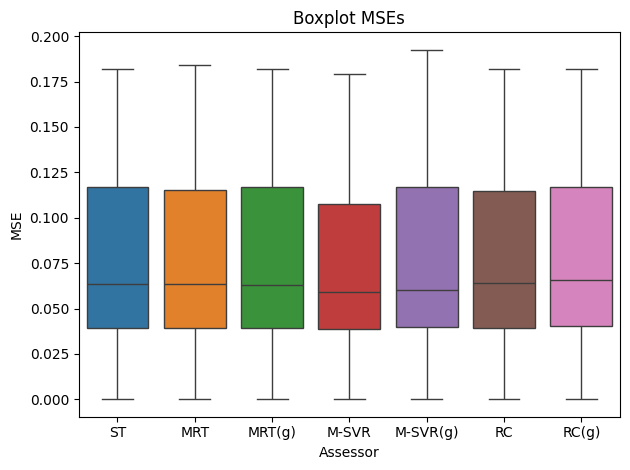

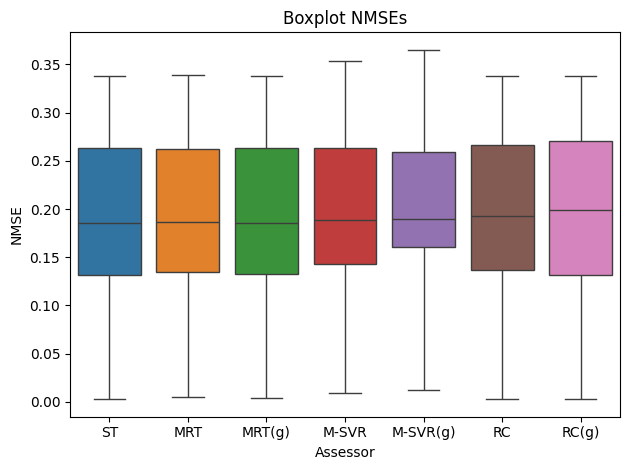

C:\Users\pedro\AppData\Local\Temp\ipykernel_19956\1332952985.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = temp.replace(dicio)


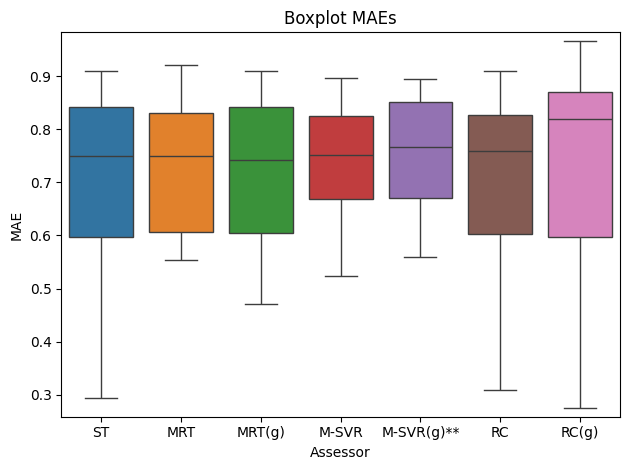

C:\Users\pedro\AppData\Local\Temp\ipykernel_19956\1332952985.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = temp.replace(dicio)


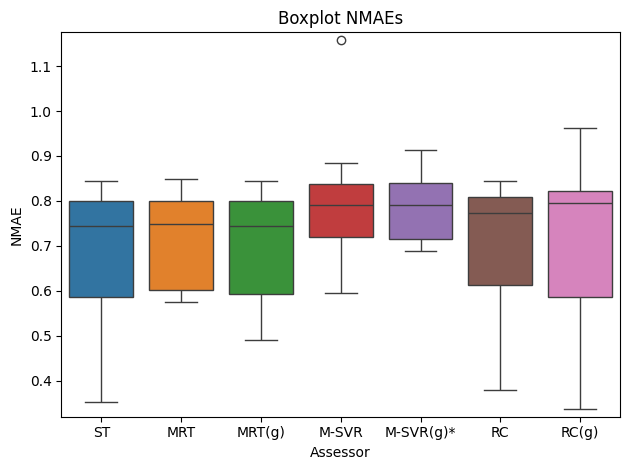

C:\Users\pedro\AppData\Local\Temp\ipykernel_19956\1332952985.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = temp.replace(dicio)


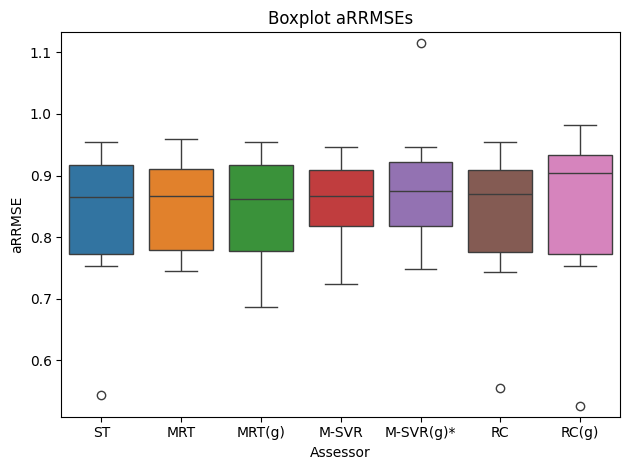

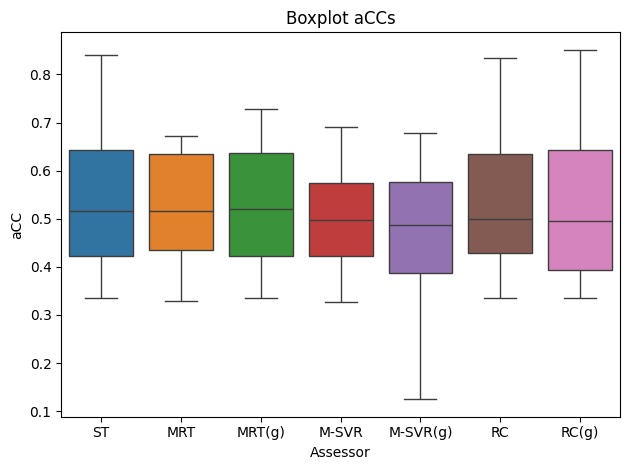

In [54]:
#temp = results_df.drop(index=results_df[results_df['Assessor'].str.contains('M-SVR')].index) #.copy()

for mt in ['MSE', 'NMSE', 'MAE', 'NMAE', 'aRRMSE', 'aCC']:
    plt.title(f'Boxplot {mt}s')
    temp = results_df.loc[:,['Assessor','Model',mt]].copy()
    if((temp[mt] > 1.2).any()):
        dicio = {}
        for a in temp['Assessor'].unique():
            out_limits = (temp.loc[temp["Assessor"]==a,mt]>1.2).sum()
            if(out_limits > 0):
                dicio[a] = a + "*"*out_limits
        temp = temp.replace(dicio)
        plt.ylim(bottom=temp[mt].min()-0.017,top=temp.loc[temp[mt]<1.2,mt].max()+0.017)
    imgplt = sns.boxplot(temp, y=mt, x='Assessor', hue='Assessor', palette=class_palette)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/{DIR}/imgs/bp_{mt.lower()}.eps', format='eps', dpi=300)

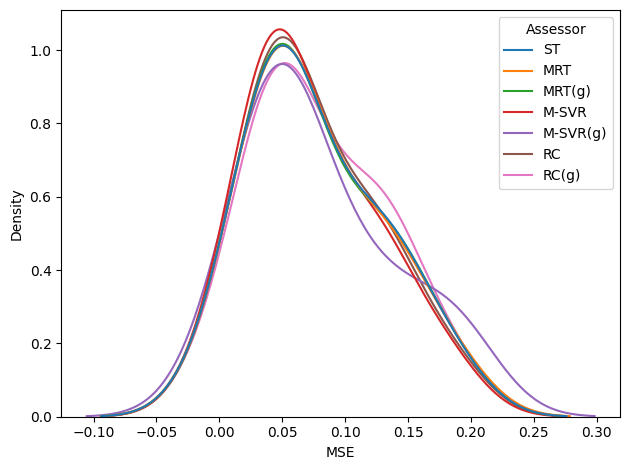

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


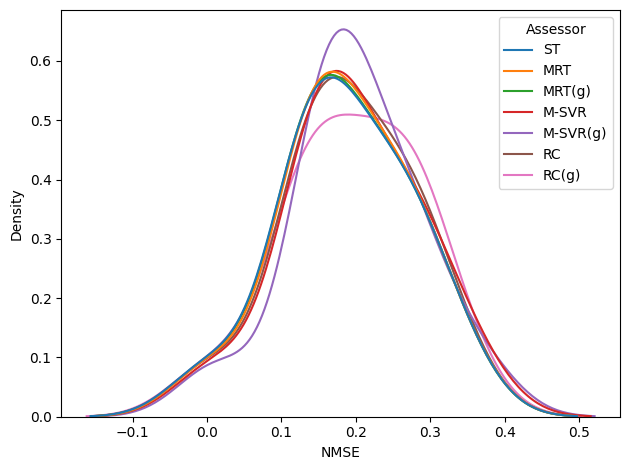

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


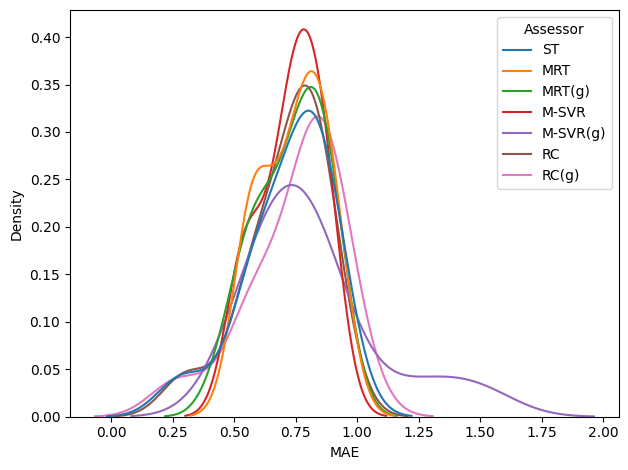

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
C:\Users\pedro\AppData\Local\Temp\ipykernel_19956\1270300147.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = temp.replace(dicio)


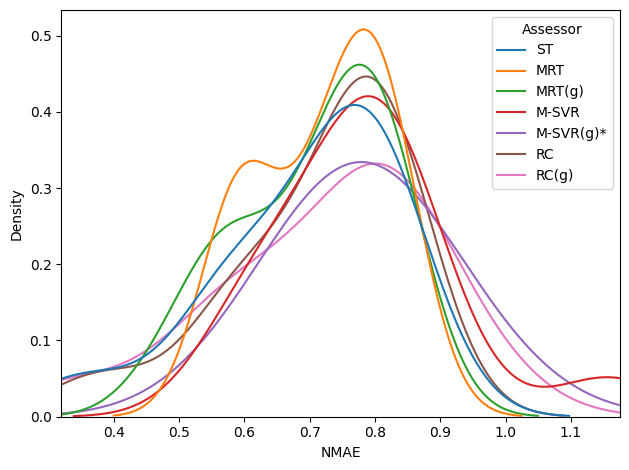

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


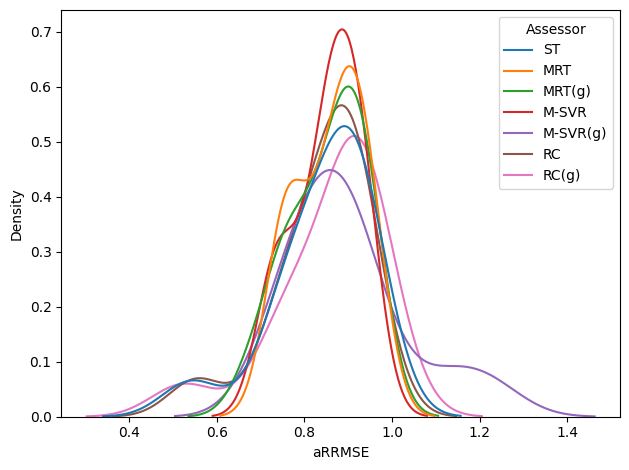

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


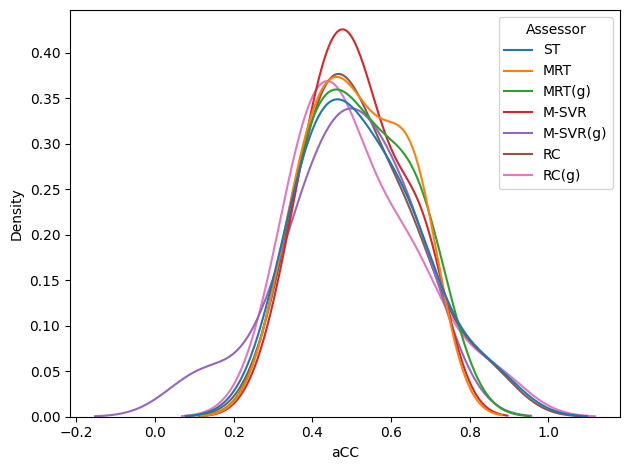

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [55]:
for mt in ['MSE', 'NMSE', 'MAE', 'NMAE', 'aRRMSE', 'aCC']:
    temp = results_df.loc[:,['Assessor','Model',mt]].copy()
    if((temp[mt] > 1.5).any()):
        dicio = {}
        for a in temp['Assessor'].unique():
            out_limits = (temp.loc[temp["Assessor"]==a,mt]>1.5).sum()
            if(out_limits > 0):
                dicio[a] = a + "*"*out_limits
        temp = temp.replace(dicio)
        plt.xlim(temp[mt].min()-0.017,temp.loc[temp[mt]<1.5,mt].max()+0.017)
    imgplt = sns.kdeplot(temp, x=mt, hue='Assessor', palette=class_palette)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/{DIR}/imgs/kde_{mt.lower()}.eps', format='eps', dpi=300)

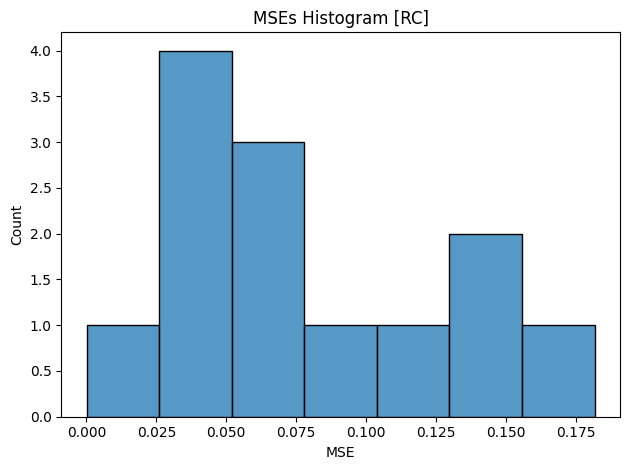

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


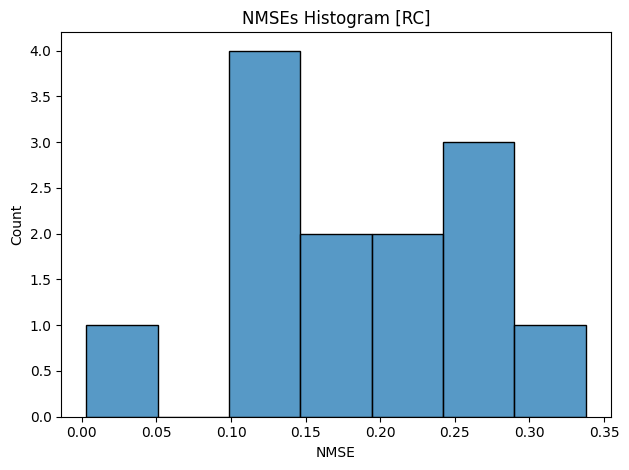

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


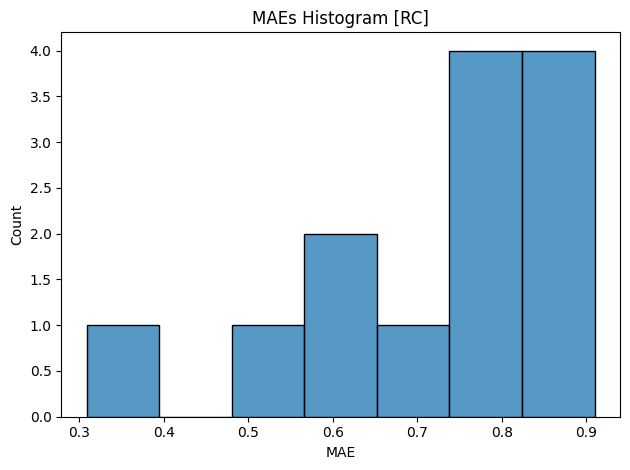

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


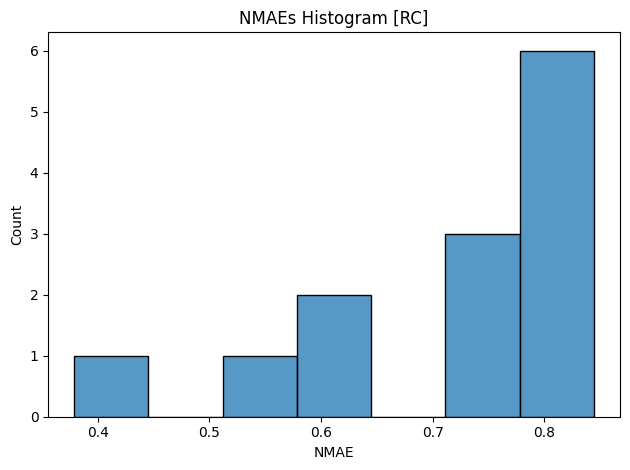

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


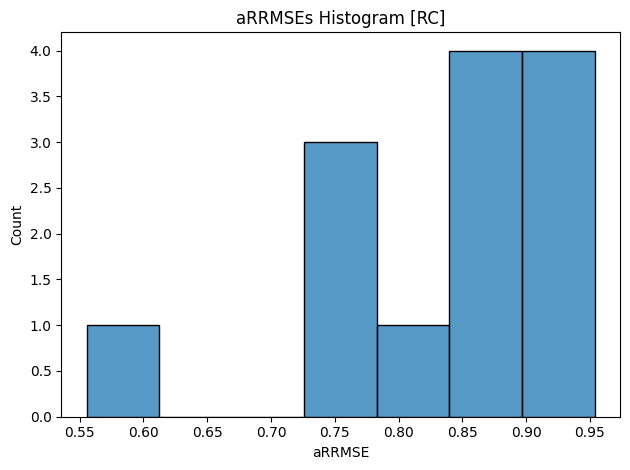

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


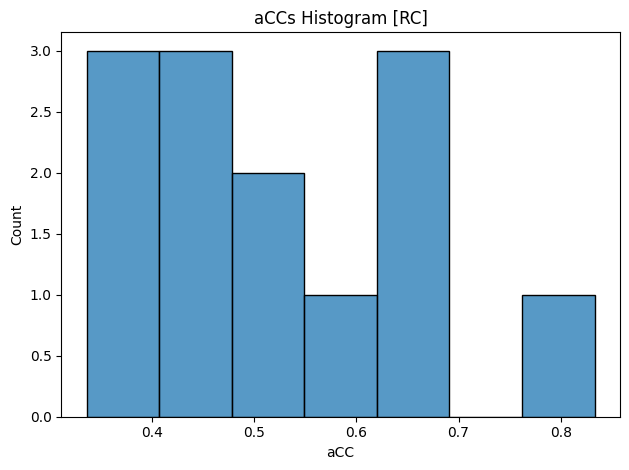

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


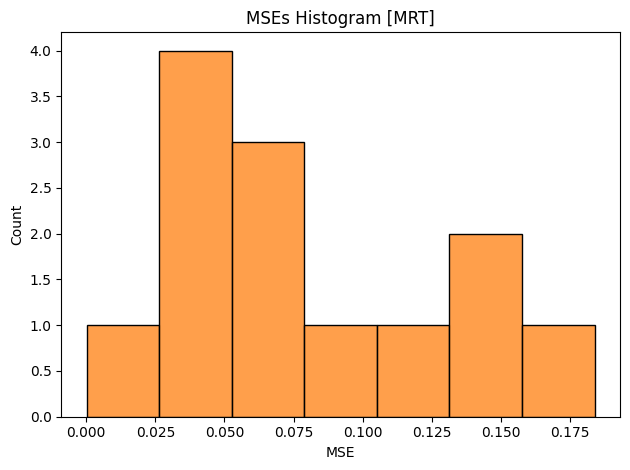

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


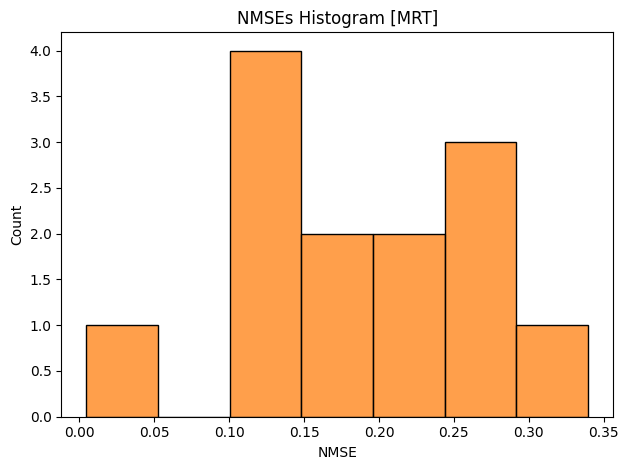

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


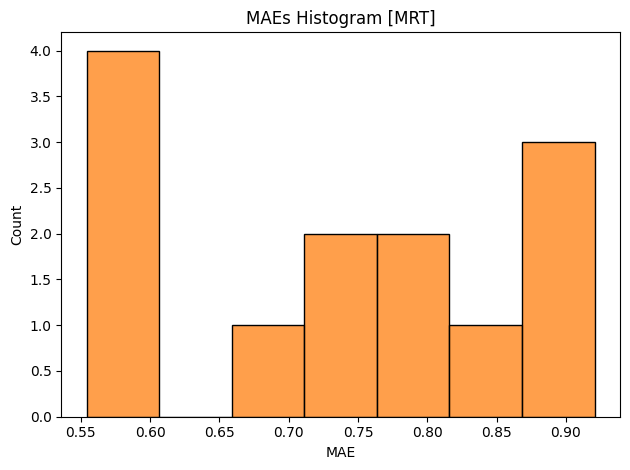

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


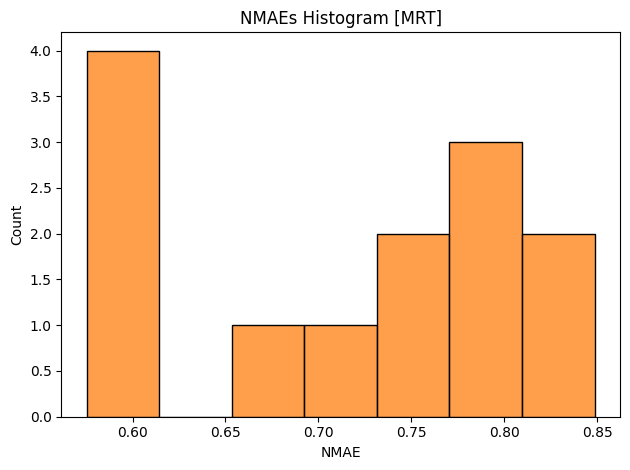

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


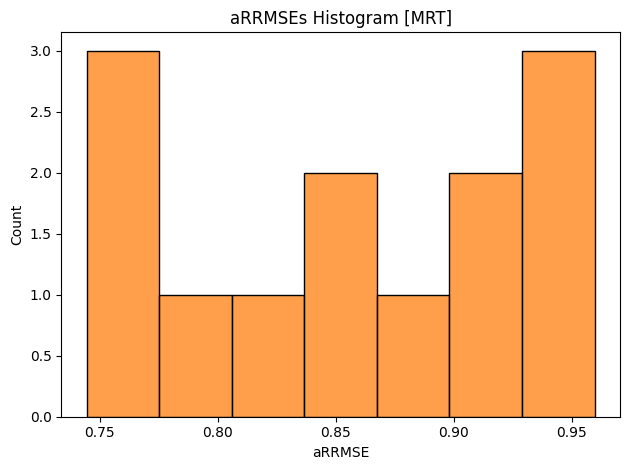

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


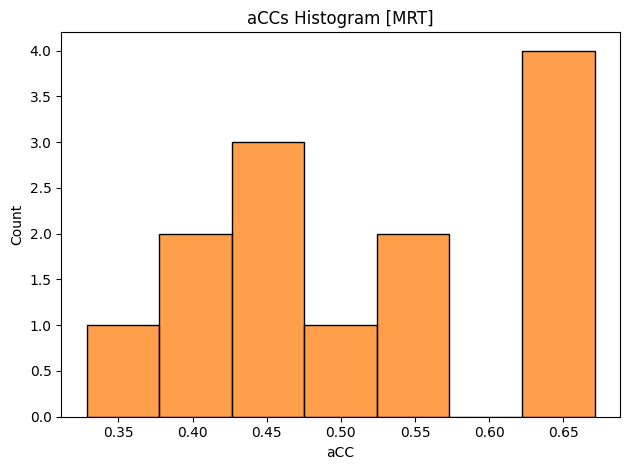

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


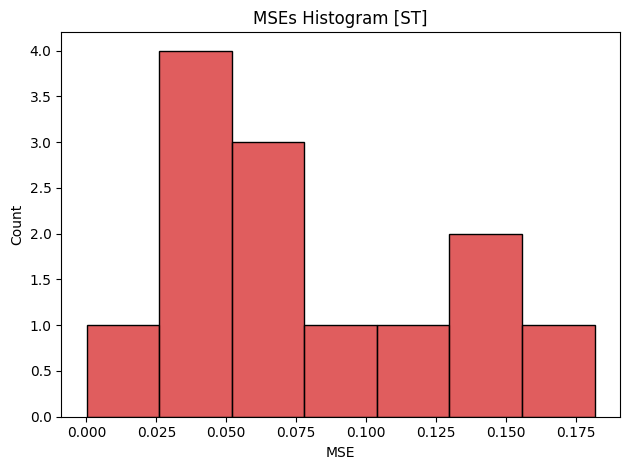

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


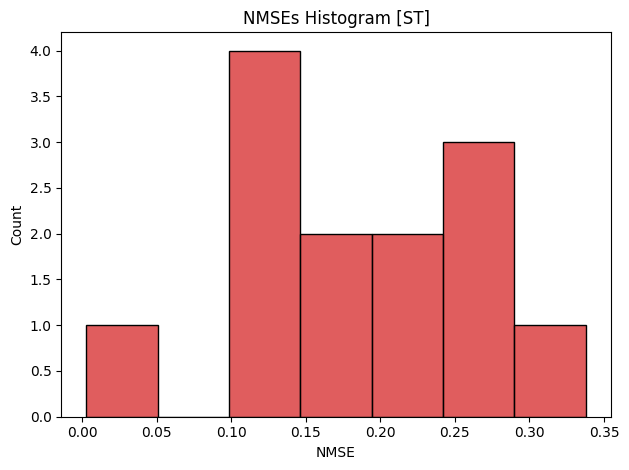

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


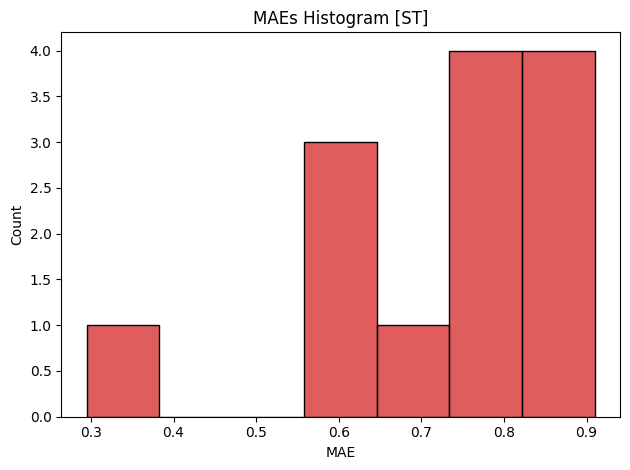

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


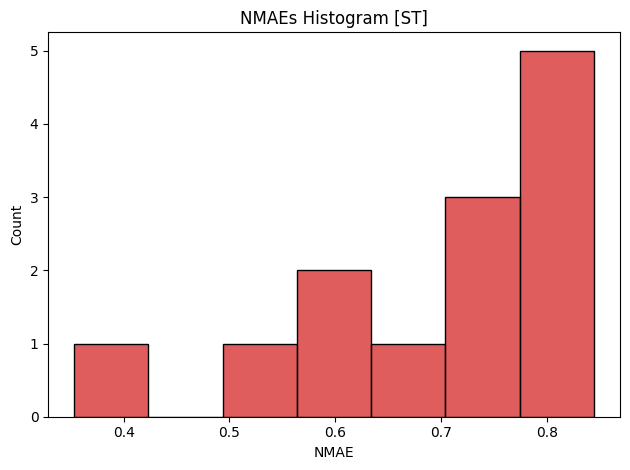

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


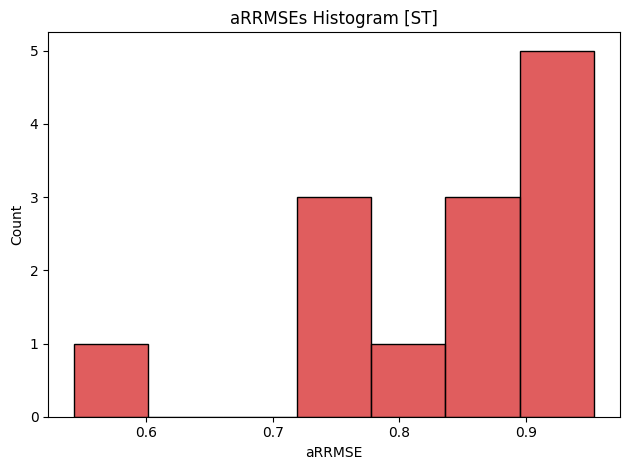

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


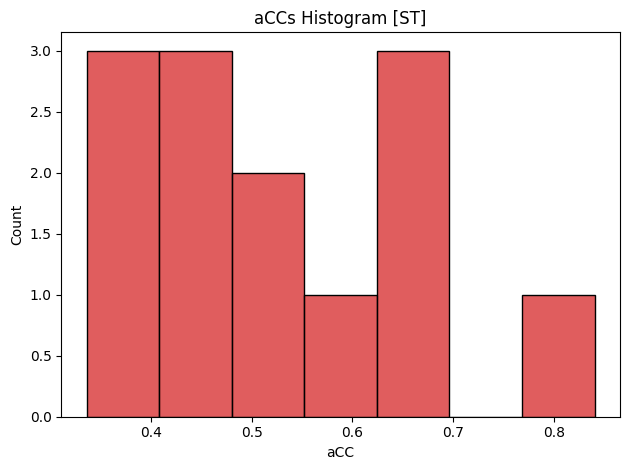

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


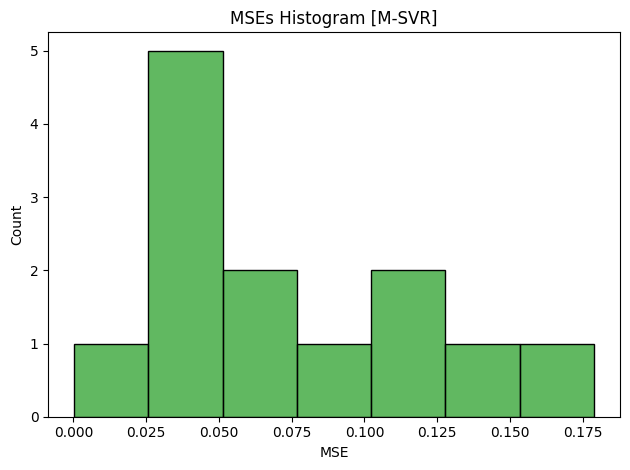

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


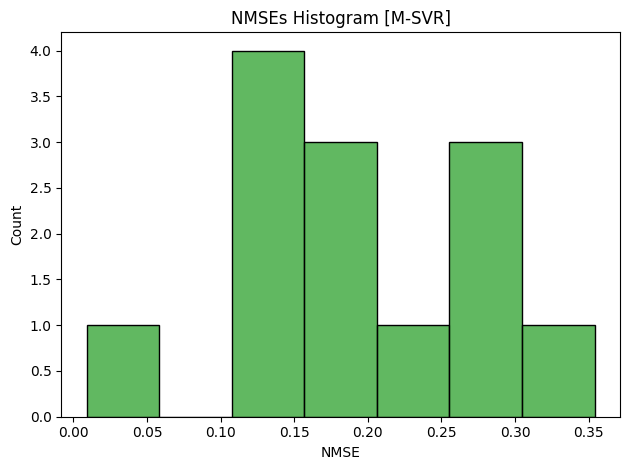

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


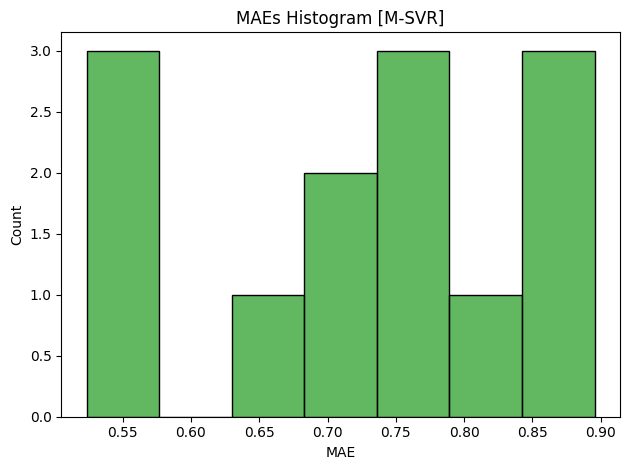

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


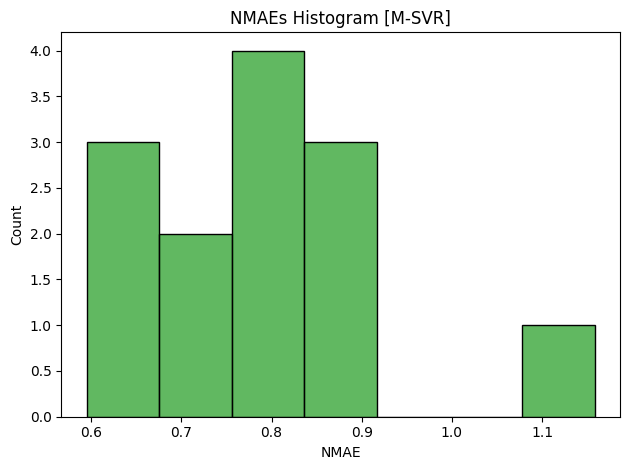

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


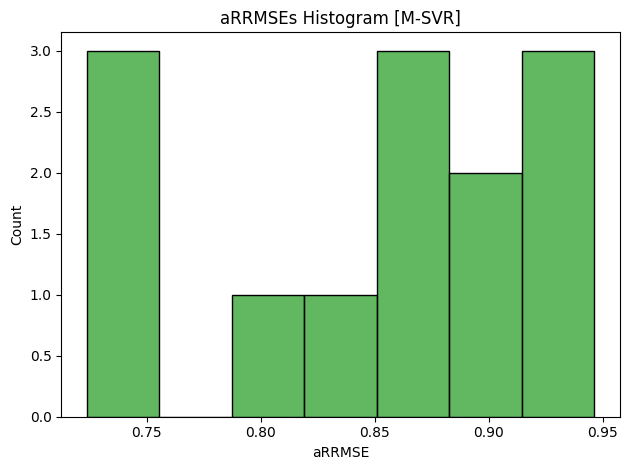

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


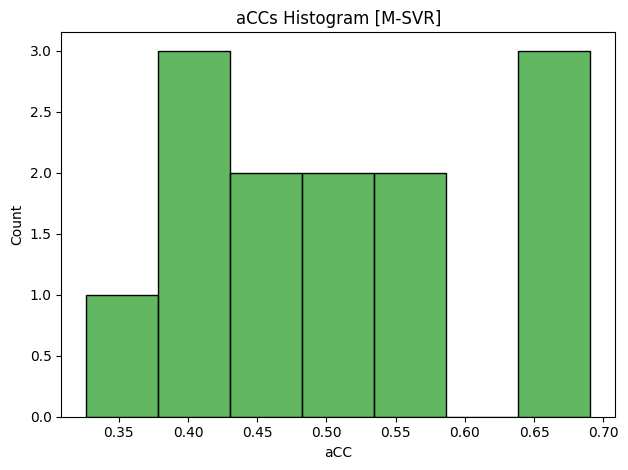

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


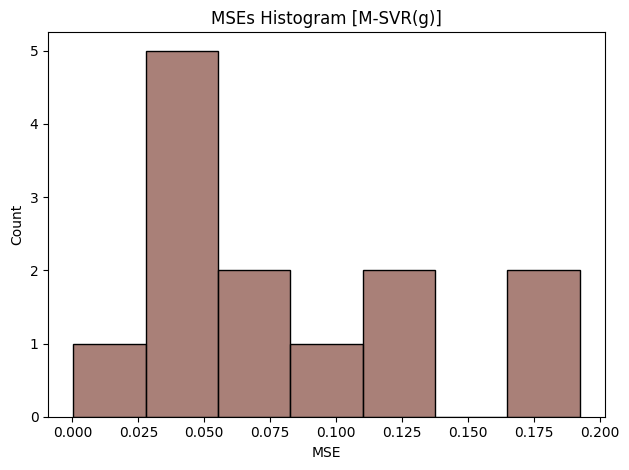

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


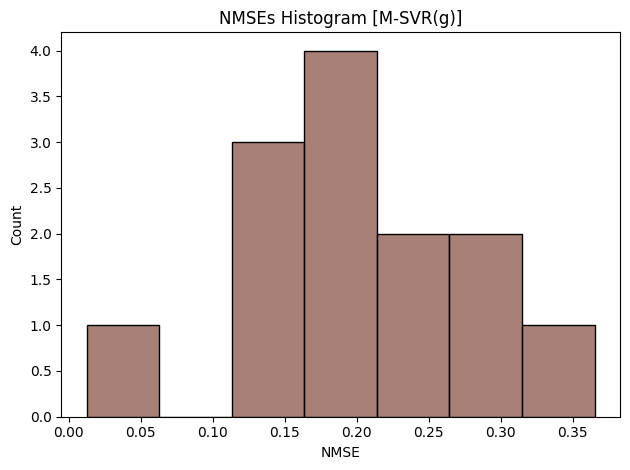

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


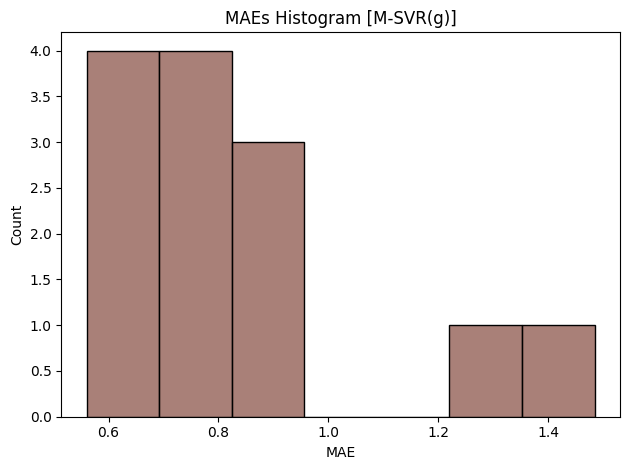

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


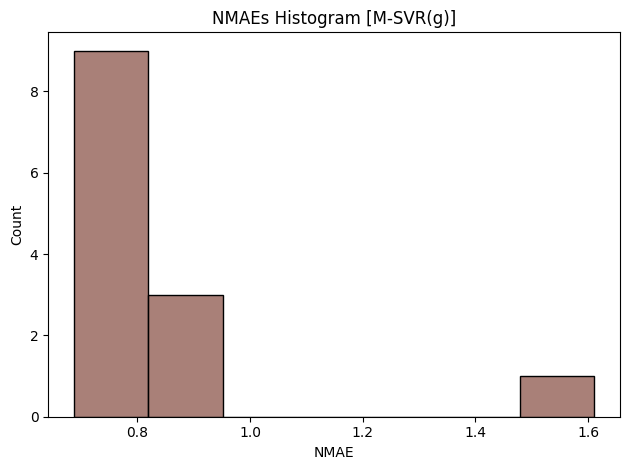

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


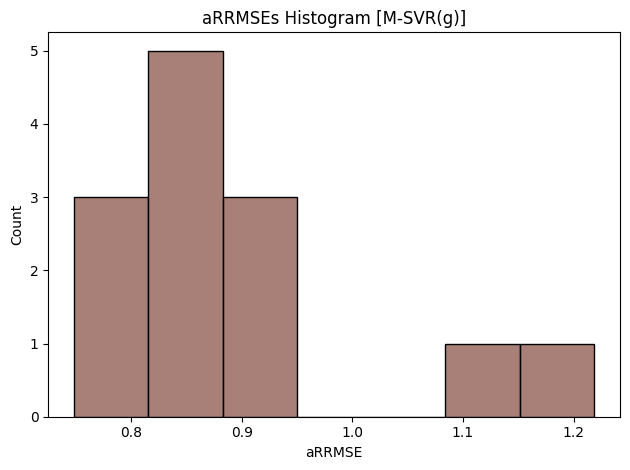

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


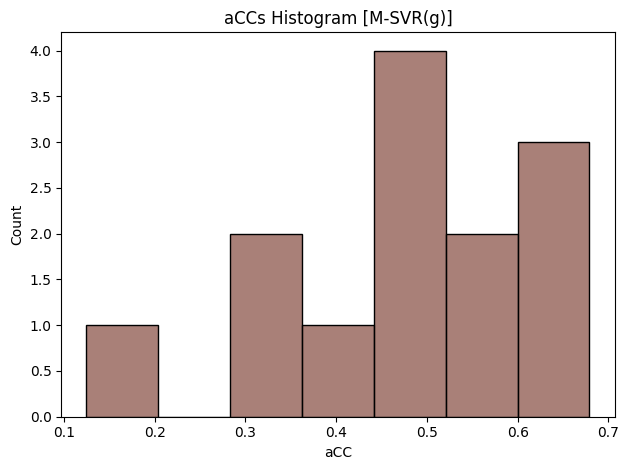

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


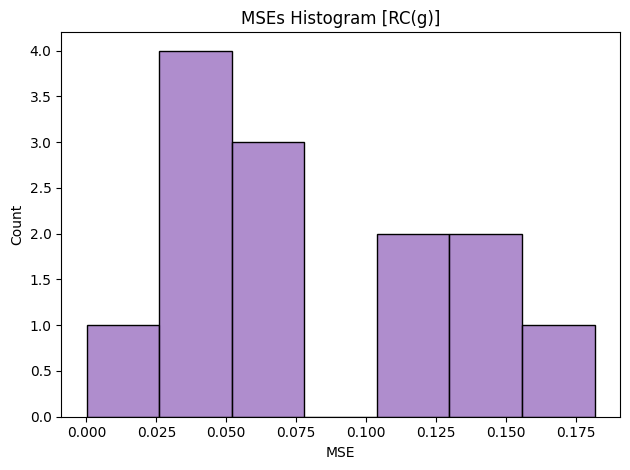

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


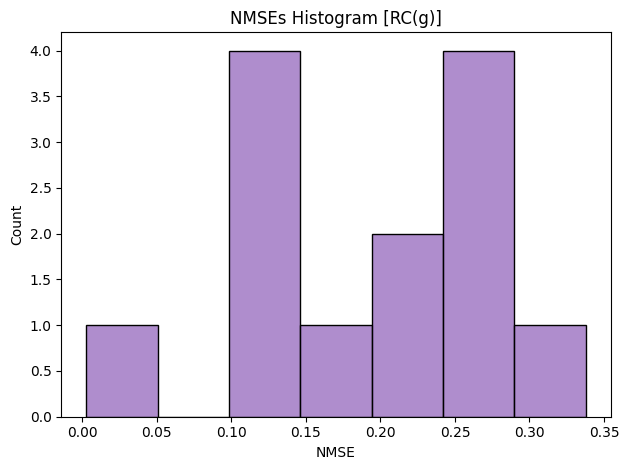

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


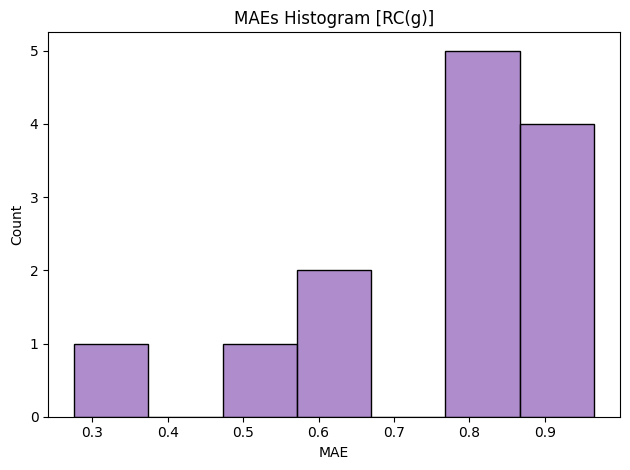

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


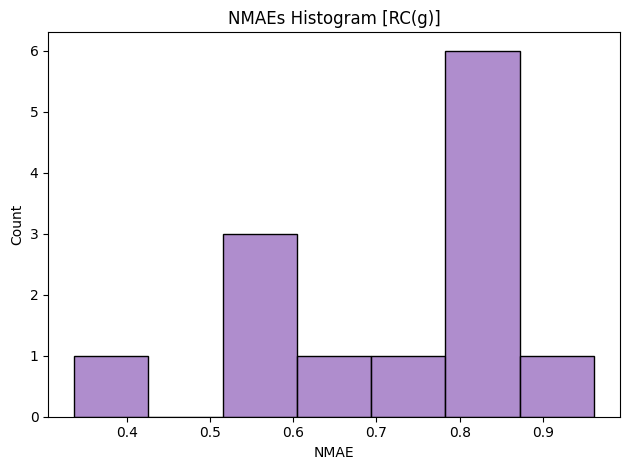

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


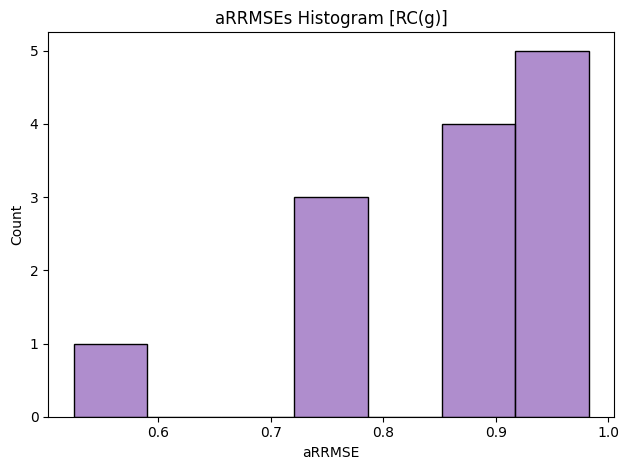

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


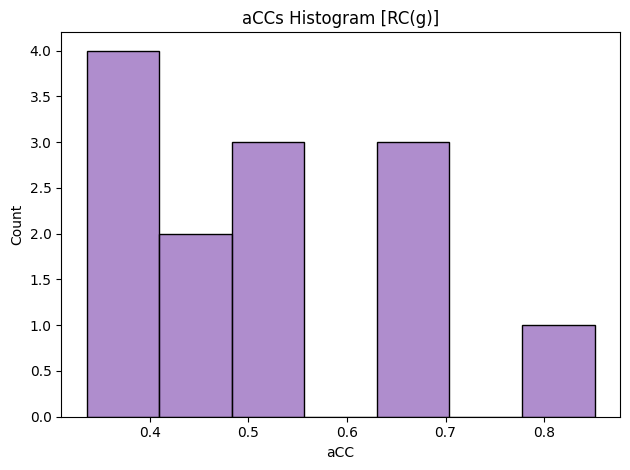

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


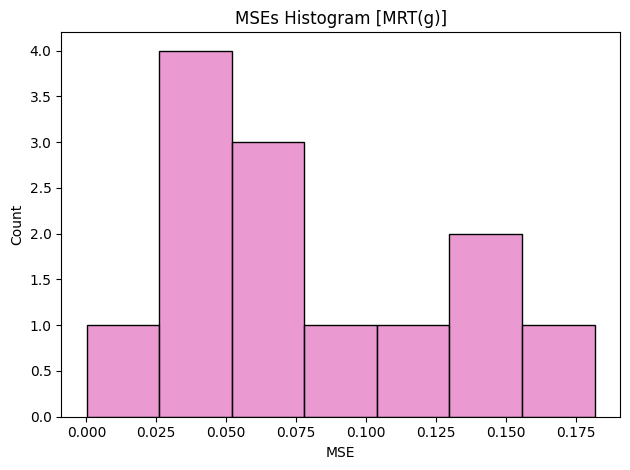

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


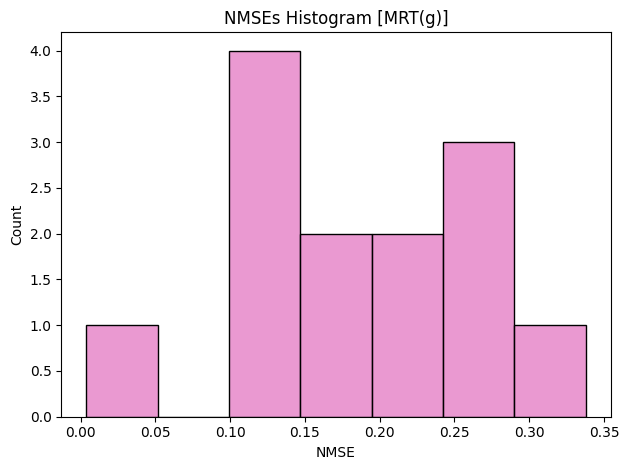

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


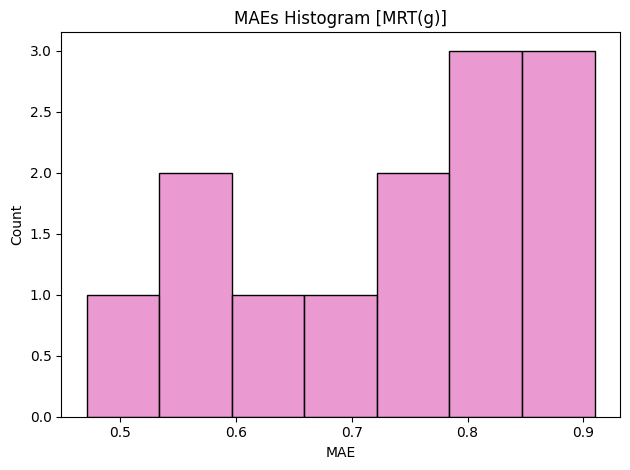

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


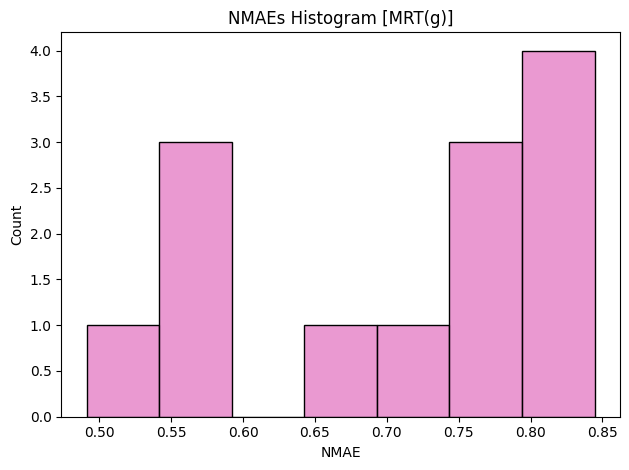

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


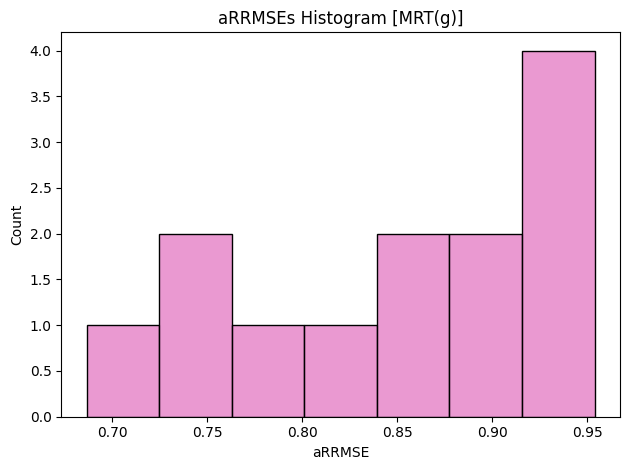

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


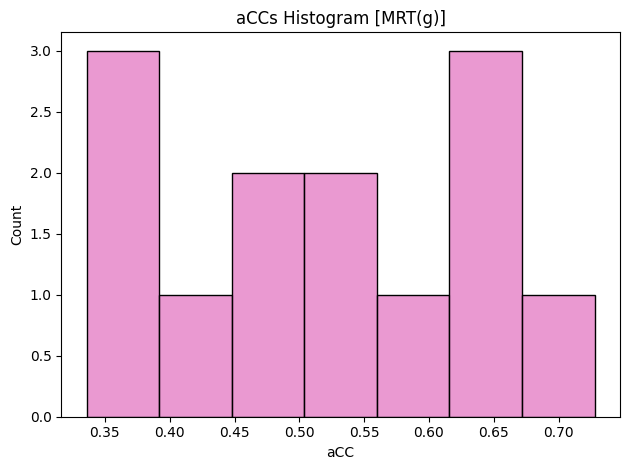

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [56]:
dicio = {'RC': {'color': class_palette[0], 'code': 'RC'},
         'MRT': {'color': class_palette[1], 'code': 'MRT'},
         'ST': {'color': class_palette[3], 'code': 'ST'},
         'M-SVR': {'color': class_palette[2], 'code': 'MSVR'},
         'M-SVR(g)': {'color': class_palette[-2], 'code': 'MSVRG'},
         'RC(g)': {'color': class_palette[-3], 'code': 'RCG'},
         'MRT(g)': {'color': class_palette[-1], 'code': 'MRTG'}}

for a in dicio.keys():
    for mt in ['MSE', 'NMSE', 'MAE', 'NMAE', 'aRRMSE', 'aCC']:
        plt.title(f'{mt}s Histogram [{a}]')
        imgplt = sns.histplot(results_df.loc[results_df['Assessor']==a,['Assessor','Model',mt]], x=mt, bins=7, color=dicio[a]['color'])
        plt.tight_layout()
        plt.show(imgplt)
        imgplt.figure.savefig(f'data/{DIR}/imgs/hg_{dicio[a]["code"]}_{mt.lower()}.eps', format='eps', dpi=300)

In [57]:
results_df

Assessor       Model       MSE       MAE      NMSE      NMAE    aRRMSE  \
0        ST       dtree  0.181723  0.909715  0.337815    0.8446   0.95379   
1        ST         sgd  0.032892  0.565911  0.115303  0.557592  0.752271   
2        ST          lr  0.040547  0.596436  0.131403  0.586247  0.772293   
3        ST         knn  0.116835  0.842509  0.263283  0.798898  0.917883   
4        ST  svm_linear  0.038628  0.576955  0.129083  0.580858  0.759575   
..      ...         ...       ...       ...       ...       ...       ...   
86    RC(g)         kan  0.041679  0.784798  0.133938  0.685187  0.885888   
87    RC(g)     rforest  0.063073  0.824896  0.202312    0.8717  0.908238   
88    RC(g)          gb  0.137709  0.870389  0.270384  0.802271  0.932946   
89    RC(g)        adab  0.000074  0.275801  0.002625  0.336503  0.525168   
90    RC(g)         xgb   0.11083  0.965389  0.275095  0.961565  0.982542   

         aCC  
0   0.335972  
1   0.665716  
2   0.642698  
3   0.422981  
4   0.658345  
..       ...  
86  0.504878  
87  0.509928  
88  0.390141  
89  0.851247  
90  0.392785  

[91 rows x 8 columns]

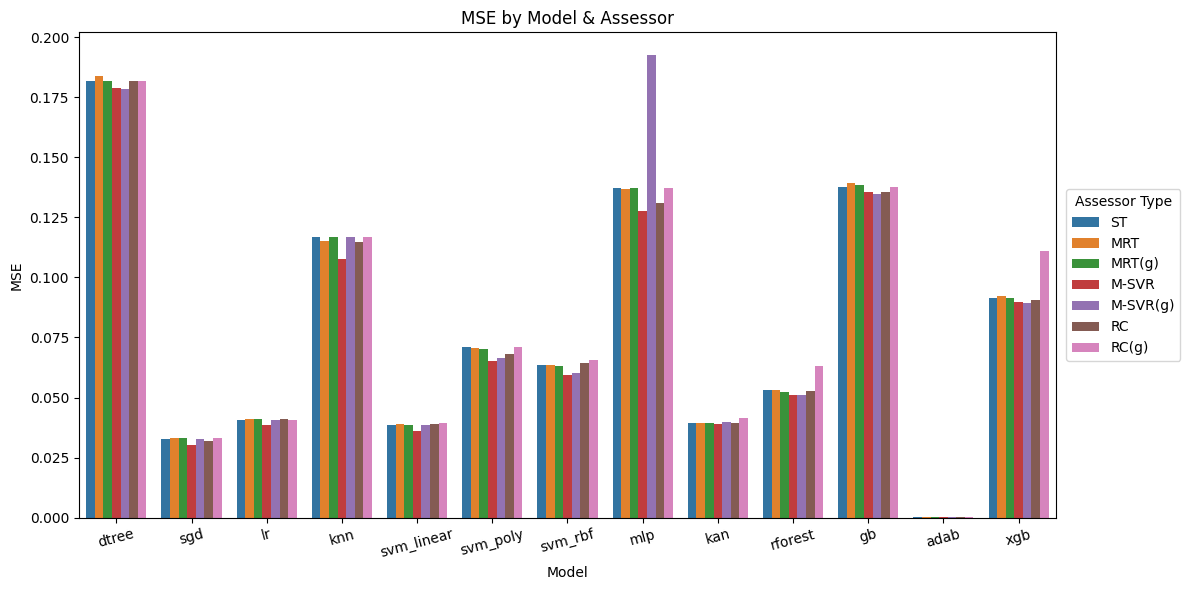

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


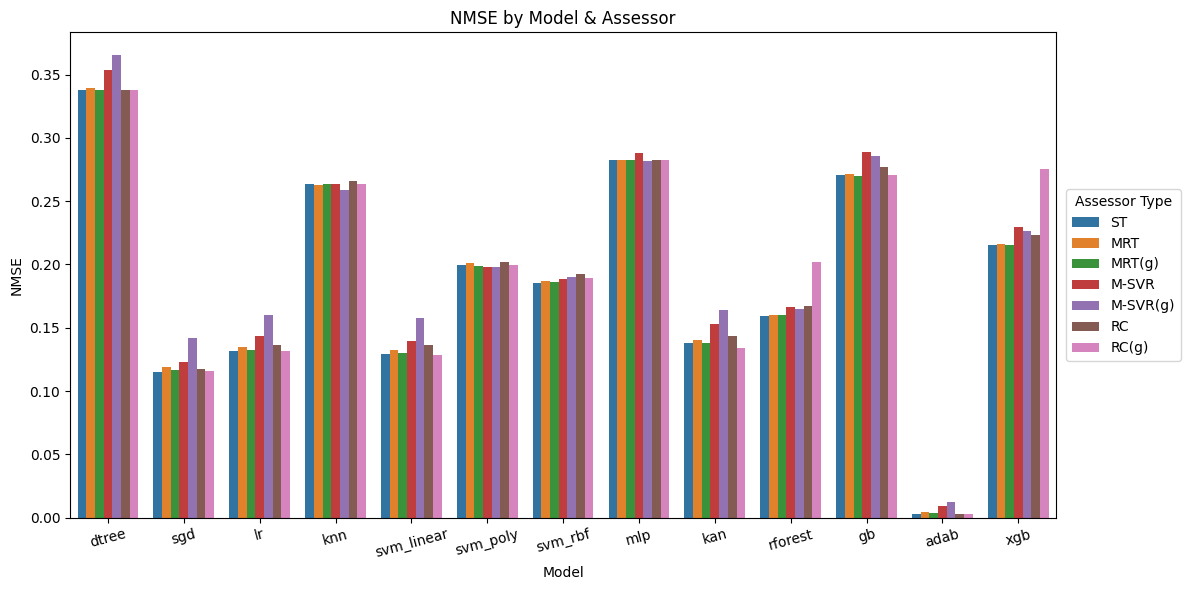

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


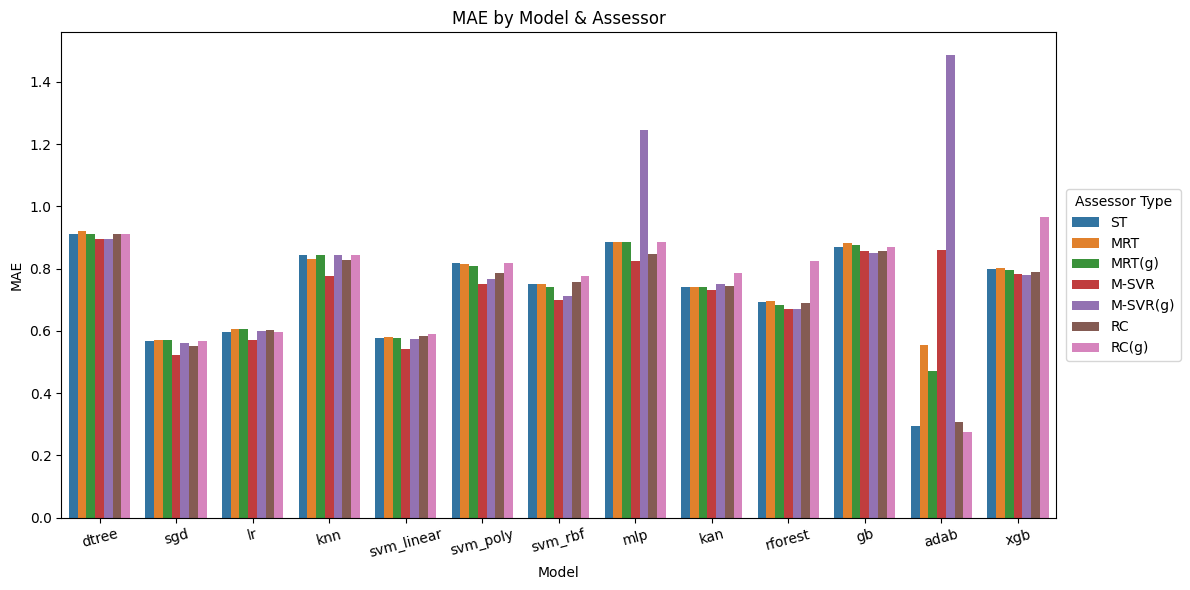

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


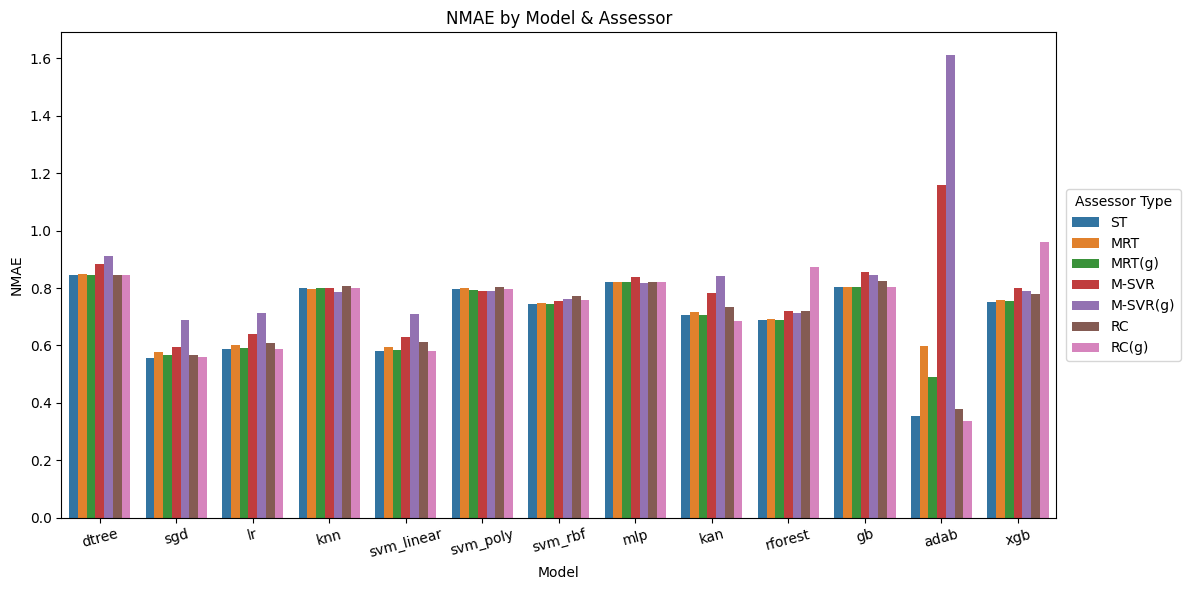

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


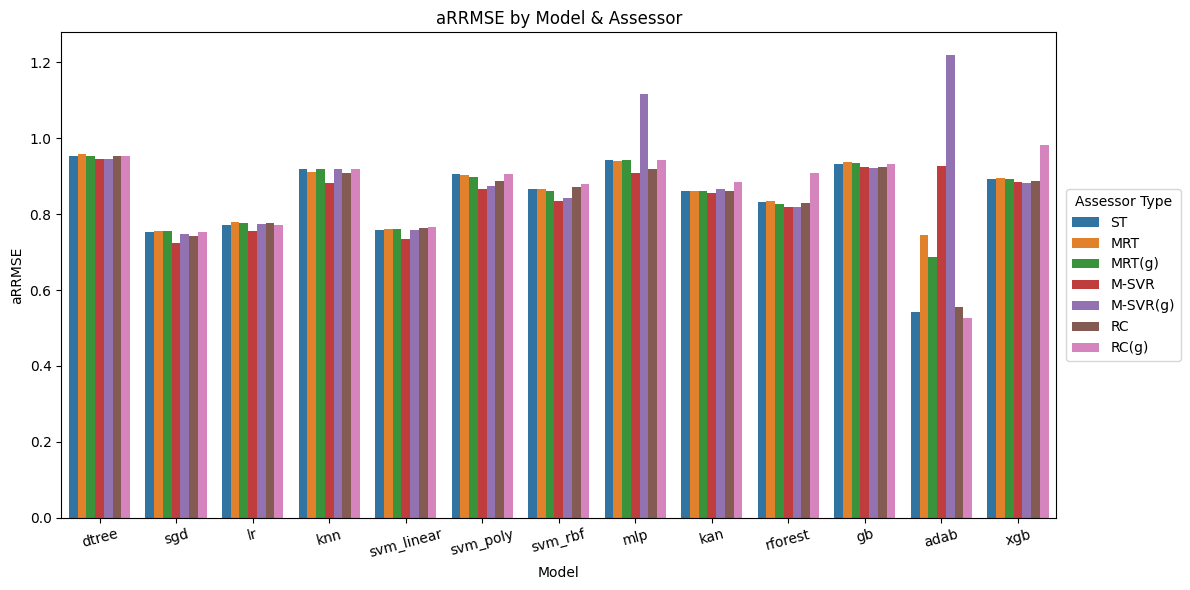

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


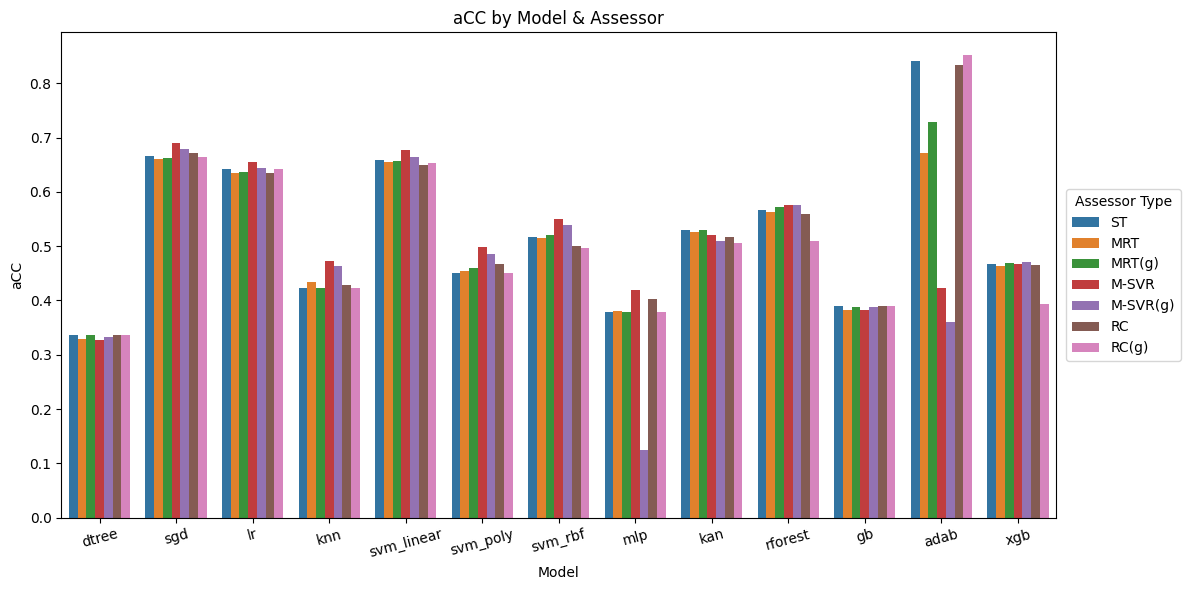

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [58]:
for mt in ['MSE', 'NMSE', 'MAE', 'NMAE', 'aRRMSE', 'aCC']:
    plt.figure(figsize=(12, 6))
    imgplt = sns.barplot(data=results_df, x='Model', y=mt, hue='Assessor', palette=class_palette)
    plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0, title='Assessor Type')
    plt.title(f'{mt} by Model & Assessor')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/{DIR}/imgs/bar_{mt.lower()}.eps', format='eps', dpi=300)

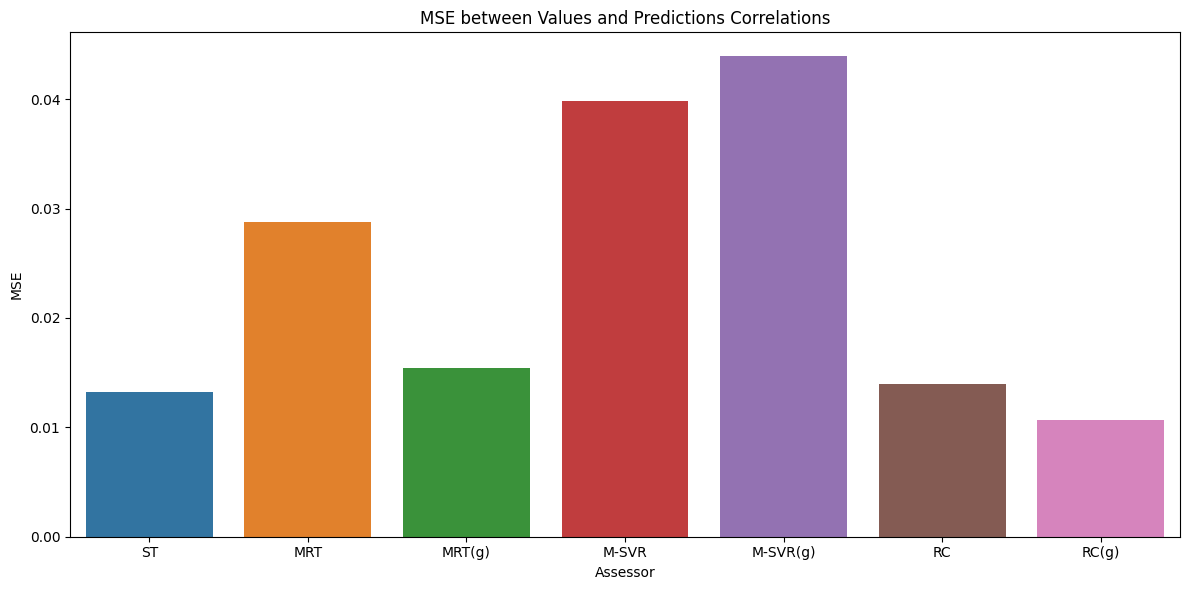

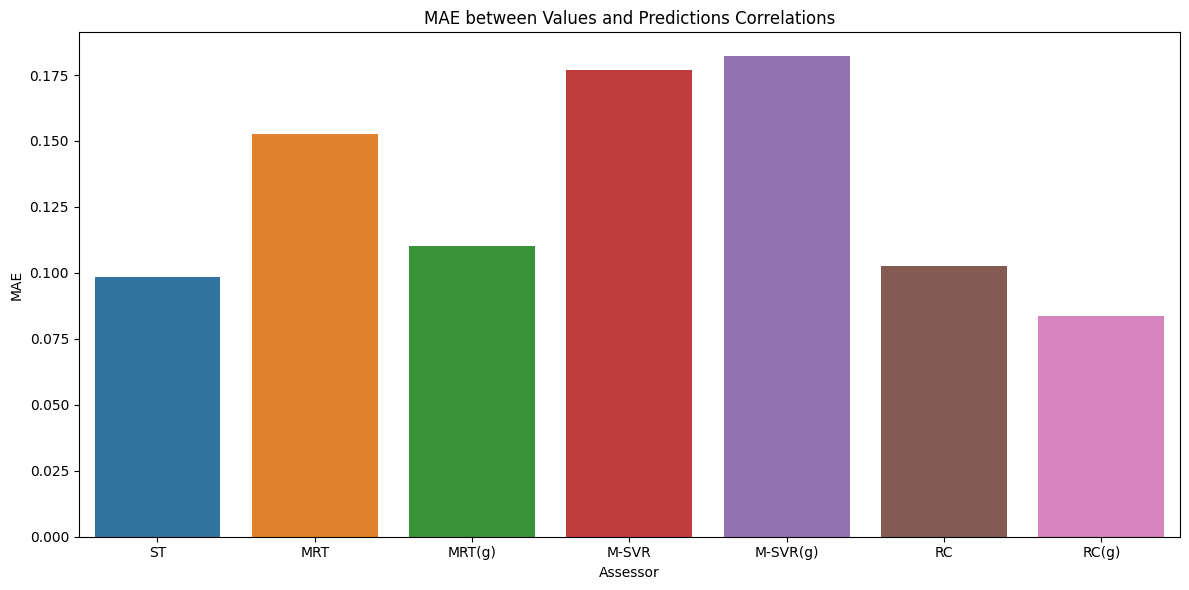

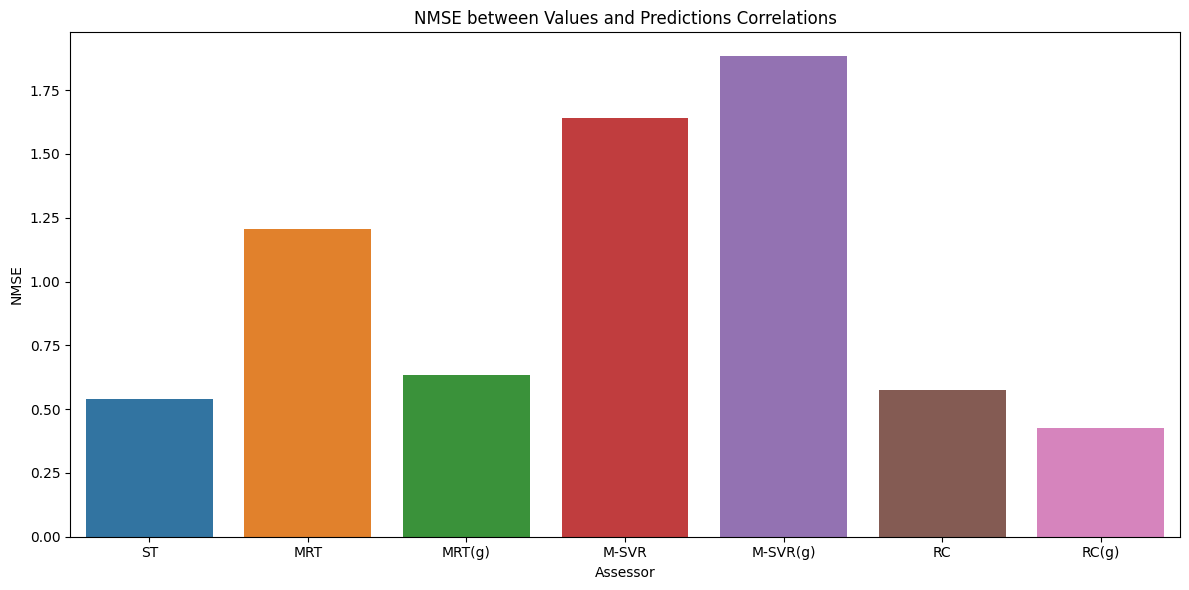

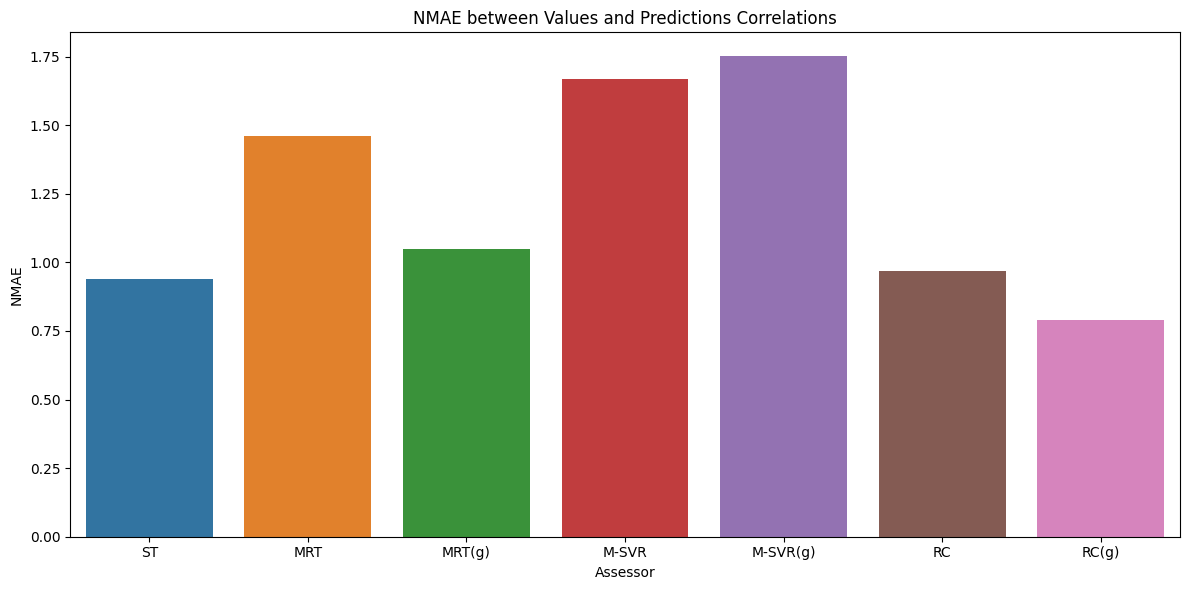

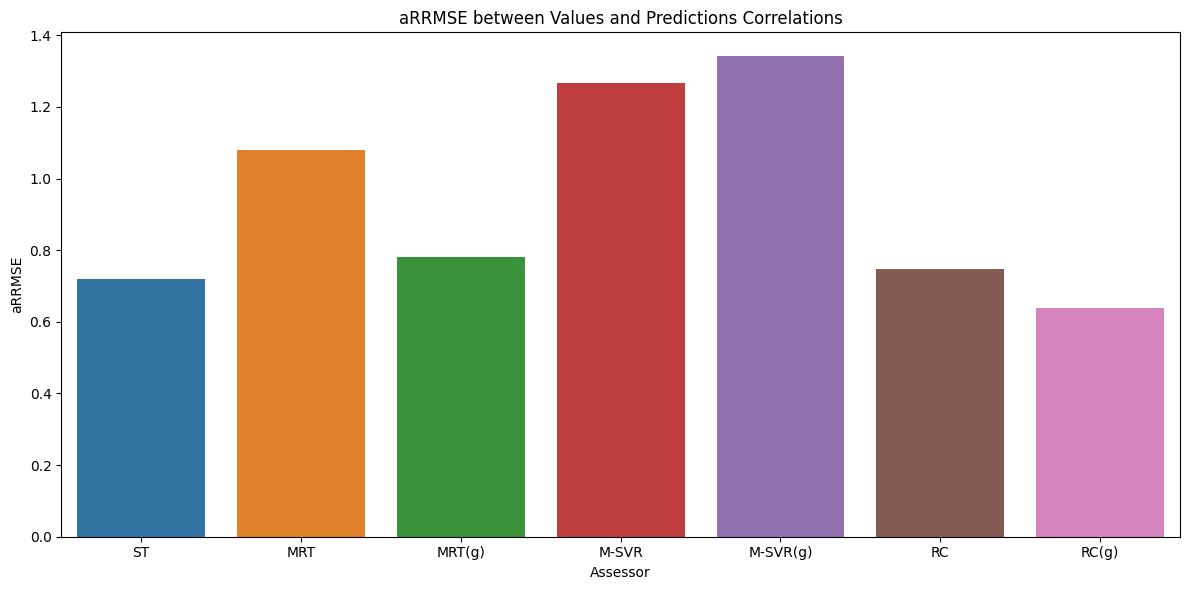

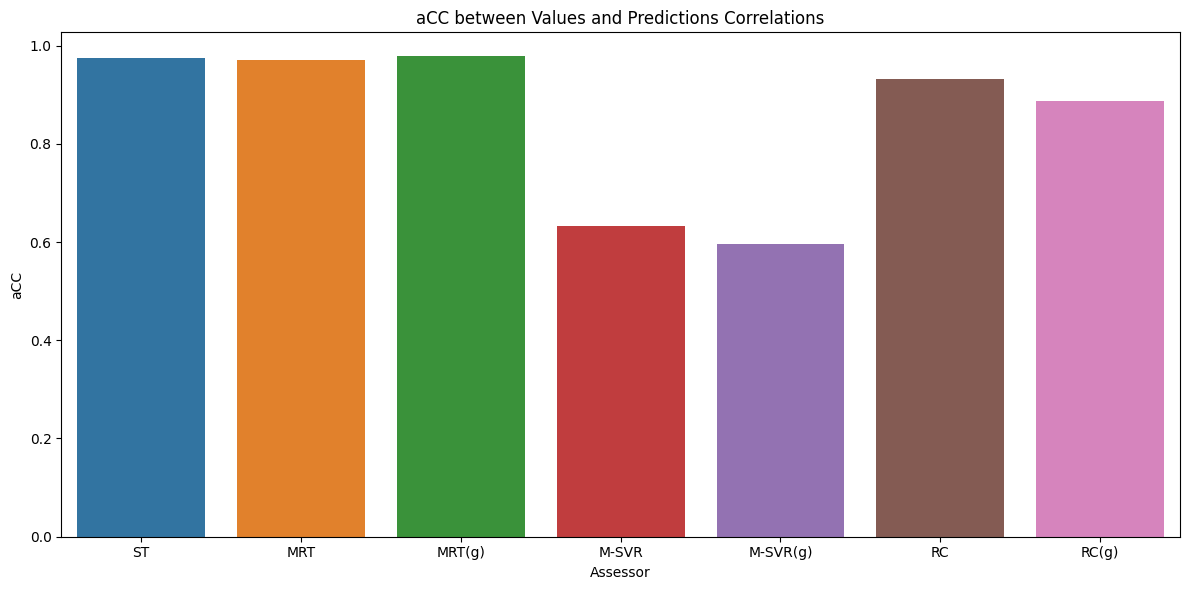

In [59]:
for mt in diff_metrics.columns:
    plt.figure(figsize=(12, 6))
    imgplt = sns.barplot(data=diff_results.loc[:,['Assessor', mt]], x='Assessor', y=mt, hue='Assessor', palette=class_palette)
    plt.title(f"{mt} between Values and Predictions Correlations")
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/{DIR}/imgs/bardiff_{mt.lower()}.eps', format='eps', dpi=300)